# <center><span style="color:DarkBlue">EDA 및 전처리</span></center> <a class="tocSkip">

## 데이터 설명
- [Should This Loan be Approved or Denied?]('https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied')
- 미국 중소기업청(SBA)에서 제공한 데이터
- FedEx, Apple computer 등 SBA 대출 보증을 받은 스타트업의 성공 사례가 있으나, 중소기업이 SBA 보증 대출을 채무 불이행한 사례도 있음.

## 변수 설명
- LoanNr_ChkDgt : 식별 키
- Name : 차용 기업명(Borrower)
- City : 차용 기업이 위치한 도시
- State : 차용 기업이 위치한 주
- Zip : 차용 기업의 우편 번호
- Bank : 은행 이름
- BankState : 은행이 위치한 주
- NAICS : 북미 산업 분류 체계 코드
- ApprovalDate : SBA 약정 발행 날짜
- ApprovalFY : 약정 회계 연도
- Term : 대출 기간(개월)
- NoEmp : 직원 수
- NewExist : 1 = 기존 비즈니스, 2 = 신규 비즈니스
- CreateJob : 창출된 직원 수
- RetainedJob : 유지 직원 수
- FranchiseCode	: 프랜차이즈 여부 (00000 or 00001) = 프랜차이즈 아님
- UrbanRural : 1 = 도시, 2 = 농촌, 0 = 정의되지 않음
- RevLineCr : 리볼빙제도 사용 여부(Y = 예, N = 아니요)
- LowDoc : SBA 대출프로그램 신청 여부(Y = 예, N = 아니요)
- ChgOffDate : 채무 불이행으로 선언되는 날짜
- DisbursementDate : 대금 지급일
- DisbursementGross : 지급된 금액
- BalanceGross : 미결제 총액
- `MIS_Status` : 대출 상태 청구됨 = CHGOFF, 전액 결제됨 = PIF
- ChgOffPrinGr : 청구된 금액
- GrAppv : 은행에서 승인한 대출 금액
- SBA_Appv : SBA의 승인된 대출 보증 금액

## 도메인 지식
- `SBA`는 1953년 미국 중소기업을 육성하고 지원하는 목적으로 설립된 기관임. 은행 대출을 보증함으로써 중소기업이 대출을 원활히 실행할 수 있도록 보장하고, 은행이 받을 수 있는 위험을 감소시켜주는 역할을 하고 있음.
- State 변수 중 `DC`는 워싱턴 DC로 미국 50개의 주에 포함되지 않고 미국의 수도로서 특별행정구를 의미. 미국 연방 정부가 위치한 지역
- `리볼빙`은 신용카드 이용 금액의 일부만 갚으면 나머지 금액은 약간의 이자와 함께 다음 결제 대상으로 연체하여, 연체자로 분류하지 않고 계속해서 카드를 사용할 수 있도록 하는 제도
- `LowDoc`은 SBA의 대출 프로그램으로, 이를 이용하면 $150,000 이하의 대출을 다소 쉽게 신청할 수 있음. LowDoc은 적은 서류(low documentation)을 의미하며, 승인 여부는 신용 등급에 따라 다름.
- NewExist 변수의 경우 기존 비즈니스는 2년 이상, 신규 비즈니스는 2년 미만 비즈니스를 말한다.(데이터 설명 자료)
- The Great Recession(세계 대공황)이 일어난 시기는 전미경제연구소(The National Bureau of Economic Research)에 의하면 2007년 12월부터 2009년 6월까지이다. ('https://money.cnn.com/2010/09/20/news/economy/recession_over/')
- 일반적으로 SBA 대출 만기는 5년~25년이라고 함
- `BalanceGross`는 계약에 따라 지불해야 하는 모든 잔여 금액과 기타 지불해야 하는 금액의 합계를 의미함. 예를 들어, 어떤 대출의 BalanceGross가 100,000 달러라면 이 대출의 현재 잔액이 100,000달러임을 나타낸다. 이는 대출의 원금과 이자 등을 합산한 총액
- `ChgOffPrinGr`는 회수 불능의 원금을 의미함. Charged-Off는 채권이 회수되지 않을 것으로 판단되어 회수 불능으로 처리된 상태를 나타냄. 따라서 이 값이 0이면 모두 회수되었다는 것을 의미

## 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

In [2]:
# 결측치 확인하는 라이브러리
import missingno as msno 

# 다중대체 라이브러리
from fancyimpute import IterativeImputer

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

(CVXPY) May 04 07:33:08 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: 지정된 모듈을 찾을 수 없습니다.')
(CVXPY) May 04 07:33:08 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: 지정된 모듈을 찾을 수 없습니다.')
(CVXPY) May 04 07:33:08 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: 지정된 모듈을 찾을 수 없습니다.')


In [3]:
# Window의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

## 데이터 불러오기

In [4]:
# working directory 확인
os.getcwd() #현재 작업 위치 출력

'C:\\Users\\82105\\비어플\\24-1 프로젝트\\code'

In [5]:
data = pd.read_csv('C:/Users/82105/비어플/24-1 프로젝트/data/SBAnational.csv', low_memory=False)
df = data.copy() #원본 데이터

## EDA 및 전처리
- 데이터 구조 확인
- 중복된 행 여부 확인
- 기술통계량 확인
- 결측치 확인
- 이상치 확인
- 상관계수 확인
- 변수별로 분포 확인

### 1. 데이터 구조 확인

In [6]:
print(df.shape)
display(df.head())
display(df.tail())
print(df.info())

(899164, 27)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,...,Y,N,NaN,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00"
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,...,N,N,NaN,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00"
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"
899163,9996003010,PACIFIC TRADEWINDS FAN & LIGHT,KAILUA,HI,96734,CENTRAL PACIFIC BANK,HI,0,27-Feb-97,1997,...,N,N,NaN,31-May-97,"$30,000.00",$0.00,P I F,$0.00,"$30,000.00","$24,000.00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

=> Name, City, State,Bank, BankState, NewExist, RevLineCr, LowDoc, ChgOffDate, DisbursementDate 변수에 결측치가 있는 것으로 보임.

### 2. 중복된 행 여부 확인

In [7]:
# 중복된 행 여부 확인
df[df.duplicated(keep=False)] #keep=False: 모든 중복행을 표시

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv


=> 중복된 행 없음!

### 3. 기술통계량 확인
- 수치형 변수들의 기술통계량 확인
- 형태는 수치형이지만, 의미상 범주형인 경우 제외

In [11]:
## 수치형으로 데이터 유형 바꾸기
selected_columns = ['DisbursementGross', 'BalanceGross','ChgOffPrinGr', 'GrAppv', 'SBA_Appv'] #금액 변수들
df[selected_columns] = df[selected_columns].replace('[\$,]', '', regex=True).astype(float)
df[selected_columns] = df[selected_columns].astype(str).replace('\.00$', '', regex=True)
df[selected_columns] = df[selected_columns].astype(float).astype(int) # 소수점 이하 ".0" 제거
df[selected_columns]

,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
0,60000,0,0,60000,48000
1,40000,0,0,40000,32000
2,287000,0,0,287000,215250
3,35000,0,0,35000,28000
4,229000,0,0,229000,229000
...,...,...,...,...,...
899159,70000,0,0,70000,56000
899160,85000,0,0,85000,42500
899161,300000,0,0,300000,225000
899162,75000,0,46383,75000,60000


In [8]:
# 수치형 변수들의 기술통계량 확인
df.describe() 

,LoanNr_ChkDgt,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
count,8.991640e+05,899164.000000,899164.000000,899164.000000,899164.000000,899028.000000,899164.000000,899164.000000,899164.000000,899164.000000,8.991640e+05,899164.000000,8.991640e+05,8.991640e+05,8.991640e+05
mean,4.772612e+09,53804.391241,398660.950146,110.773078,11.411353,1.280404,8.430376,10.797257,2753.725933,0.757748,2.011540e+05,2.989349,1.350330e+04,1.926870e+05,1.494888e+05
std,2.538175e+09,31184.159152,263318.312759,78.857305,74.108196,0.451750,236.688165,237.120600,12758.019136,0.646436,2.876408e+05,1442.161912,6.515229e+04,2.832634e+05,2.284146e+05
min,1.000014e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,2.000000e+02,1.000000e+02
25%,2.589758e+09,27587.000000,235210.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.200000e+04,0.000000,0.000000e+00,3.500000e+04,2.125000e+04
50%,4.361439e+09,55410.000000,445310.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+05,0.000000,0.000000e+00,9.000000e+04,6.125000e+04
75%,6.904627e+09,83704.000000,561730.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.380000e+05,0.000000,0.000000e+00,2.250000e+05,1.750000e+05
max,9.996003e+09,99999.000000,928120.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,1.144632e+07,996262.000000,3.512596e+06,5.472000e+06,5.472000e+06


In [10]:
# 형태는 수치형이지만, 의미상 범주형인 변수를 제외하고 수치형 변수들의 기술통계량 확인
description = df[['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'BalanceGross','ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].describe()
description

,Term,NoEmp,NewExist,CreateJob,RetainedJob,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
count,899164.000000,899164.000000,899028.000000,899164.000000,899164.000000,8.991640e+05,899164.000000,8.991640e+05,8.991640e+05,8.991640e+05
mean,110.773078,11.411353,1.280404,8.430376,10.797257,2.011540e+05,2.989349,1.350330e+04,1.926870e+05,1.494888e+05
std,78.857305,74.108196,0.451750,236.688165,237.120600,2.876408e+05,1442.161912,6.515229e+04,2.832634e+05,2.284146e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,2.000000e+02,1.000000e+02
25%,60.000000,2.000000,1.000000,0.000000,0.000000,4.200000e+04,0.000000,0.000000e+00,3.500000e+04,2.125000e+04
50%,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000e+05,0.000000,0.000000e+00,9.000000e+04,6.125000e+04
75%,120.000000,10.000000,2.000000,1.000000,4.000000,2.380000e+05,0.000000,0.000000e+00,2.250000e+05,1.750000e+05
max,569.000000,9999.000000,2.000000,8800.000000,9500.000000,1.144632e+07,996262.000000,3.512596e+06,5.472000e+06,5.472000e+06


In [11]:
# 깔끔하게 보이기 위해 소수점 조절
description = description.round(2)
description

,Term,NoEmp,NewExist,CreateJob,RetainedJob,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
count,899164.00,899164.00,899028.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00,899164.00
mean,110.77,11.41,1.28,8.43,10.80,201154.02,2.99,13503.30,192686.98,149488.79
std,78.86,74.11,0.45,236.69,237.12,287640.85,1442.16,65152.29,283263.39,228414.56
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00,100.00
25%,60.00,2.00,1.00,0.00,0.00,42000.00,0.00,0.00,35000.00,21250.00
50%,84.00,4.00,1.00,0.00,1.00,100000.00,0.00,0.00,90000.00,61250.00
75%,120.00,10.00,2.00,1.00,4.00,238000.00,0.00,0.00,225000.00,175000.00
max,569.00,9999.00,2.00,8800.00,9500.00,11446325.00,996262.00,3512596.00,5472000.00,5472000.00


- NoEmp의 최소값이 0?
- 변수별 분포 확인에서 다시 확인

### 4. 결측치 확인

In [12]:
# 결측치 확인
df.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

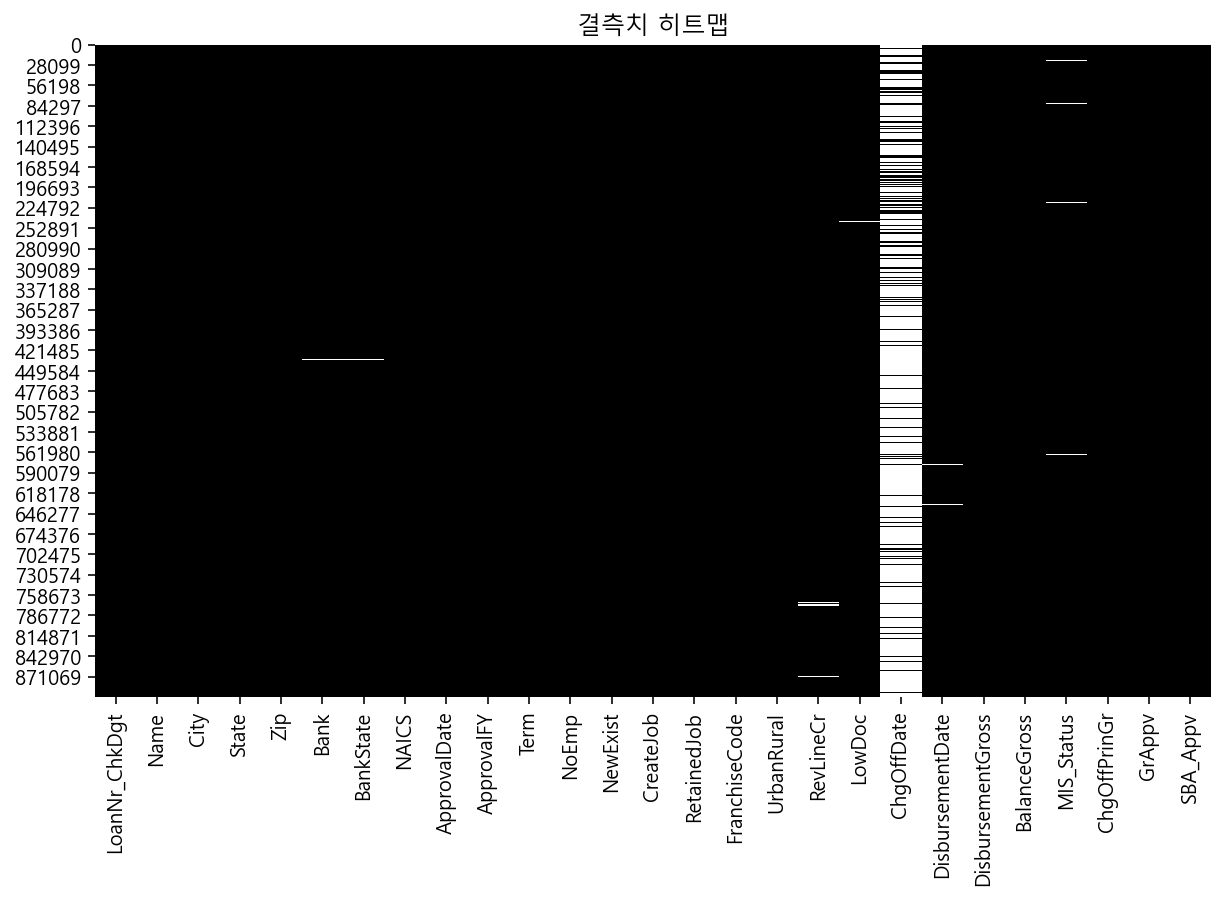

In [15]:
# 결측치 시각화 sns 사용
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap='Greys_r', cbar=False)
plt.title('결측치 히트맵')
plt.show()

<Axes: >

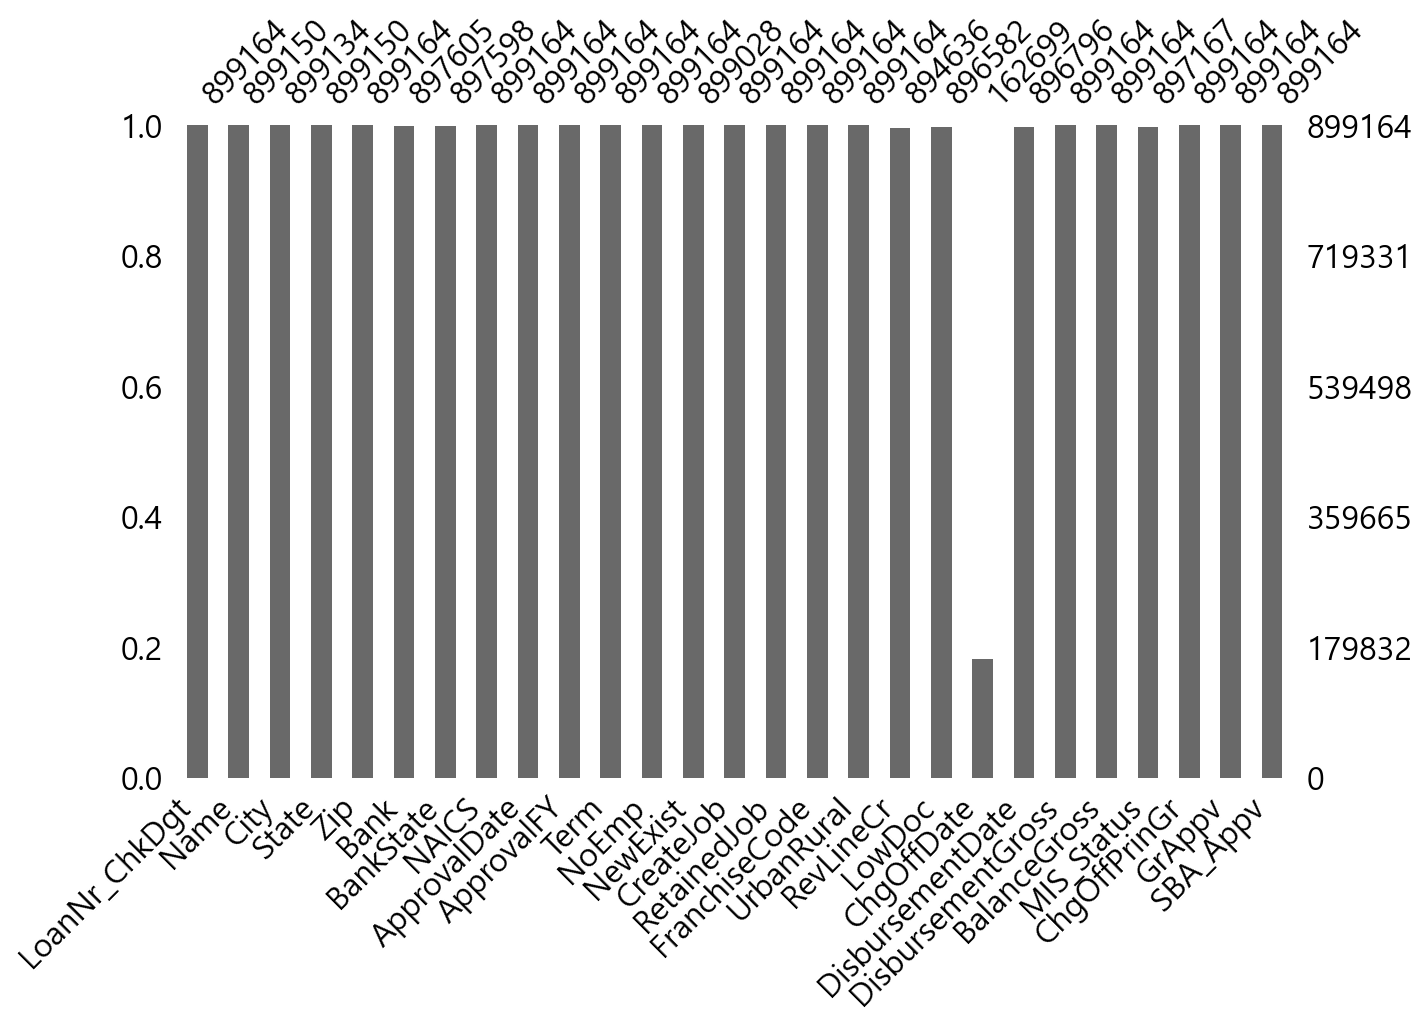

In [11]:
# 결측치 시각화 - msno 사용
msno.bar(df, figsize=(10,6)) #msno.matrix()는 에러로 인해 msno.bar()로 시각화하였음(msno와 matplotlib 간의 호환성 문제인 것으로 보임)

=> ChgOffDate 변수의 결측치가 가장 많은 것으로 나타남.

### 5. 이상치 확인

- 수치형 변수들에 한해 이상치 파악
- 형태는 수치형이지만, 의미상 범주형인 경우 제외

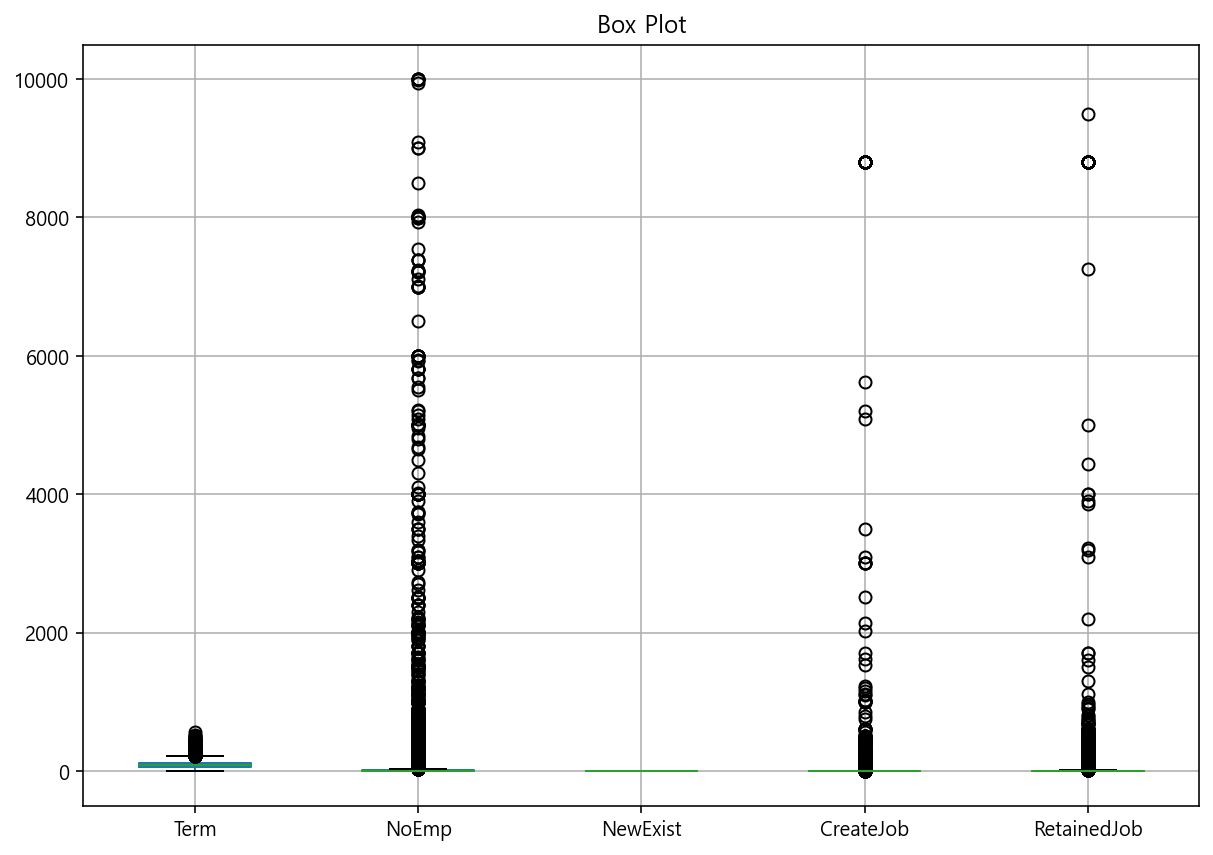

In [41]:
#matplotlib을 이용한 BoxPlot
plt.figure(figsize=(10, 7))
df.boxplot(column=['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob'])
plt.title("Box Plot")
plt.show()

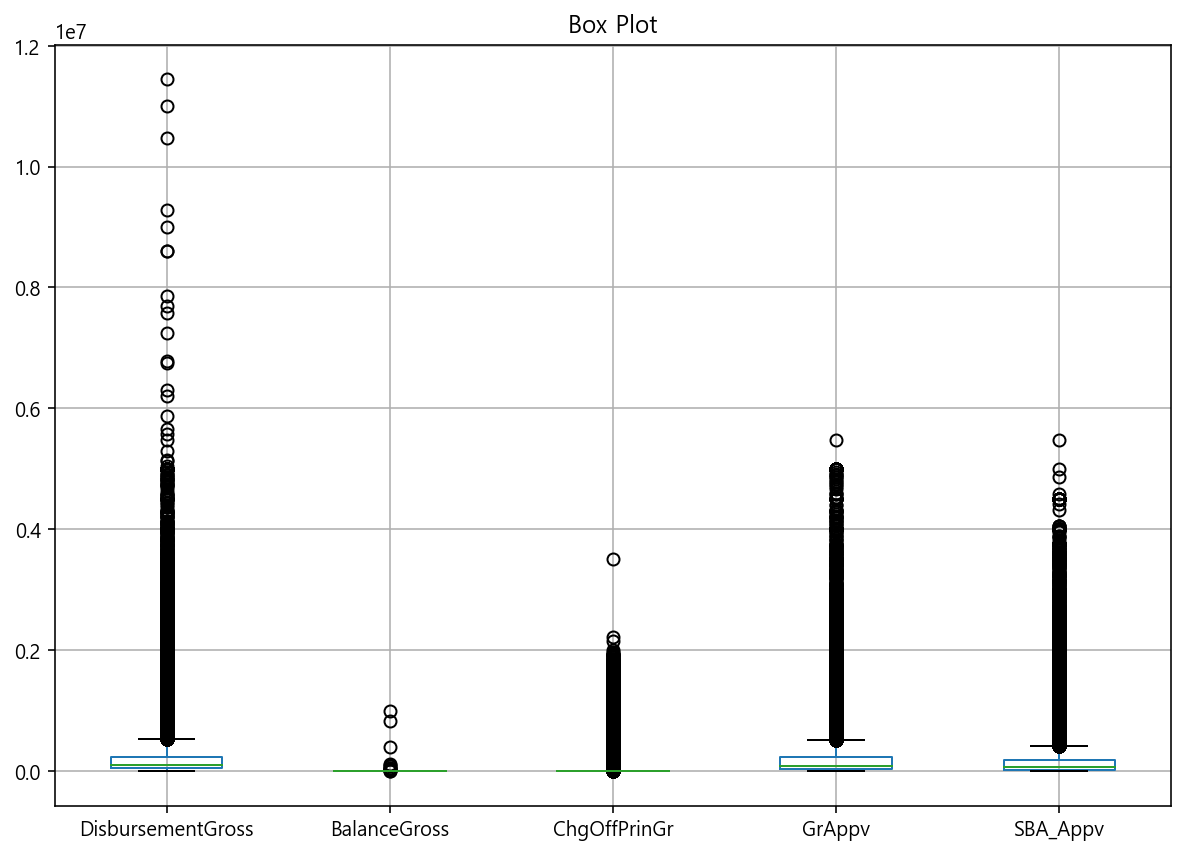

In [42]:
#matplotlib을 이용한 BoxPlot
plt.figure(figsize=(10, 7))
df.boxplot(column=['DisbursementGross', 'BalanceGross','ChgOffPrinGr', 'GrAppv', 'SBA_Appv'])
plt.title("Box Plot")
plt.show()

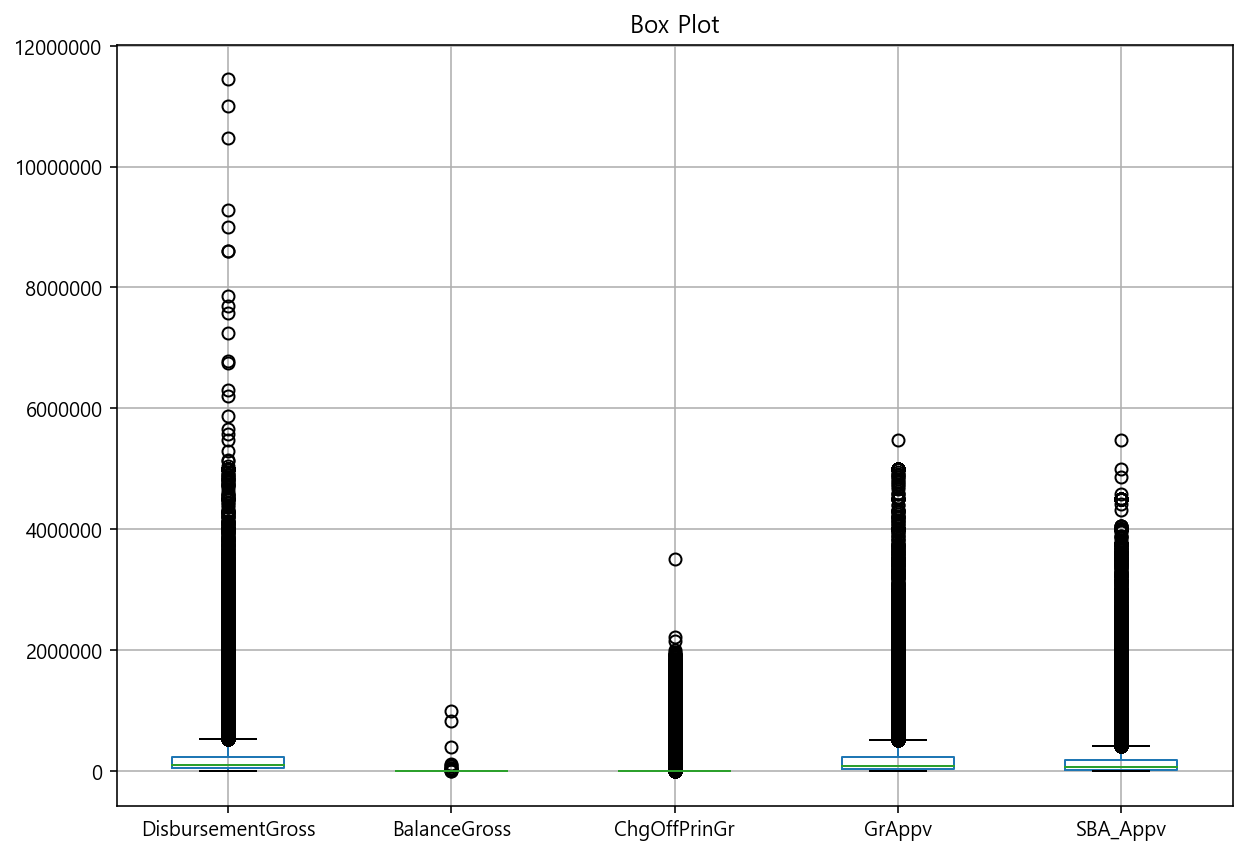

In [43]:
#matplotlib을 이용한 BoxPlot
plt.figure(figsize=(10, 7))
df.boxplot(column=['DisbursementGross', 'BalanceGross','ChgOffPrinGr', 'GrAppv', 'SBA_Appv'])
plt.ticklabel_format(style='plain', axis='y') # 왼쪽 축의 표시 형식 변경
plt.title("Box Plot")
plt.show()

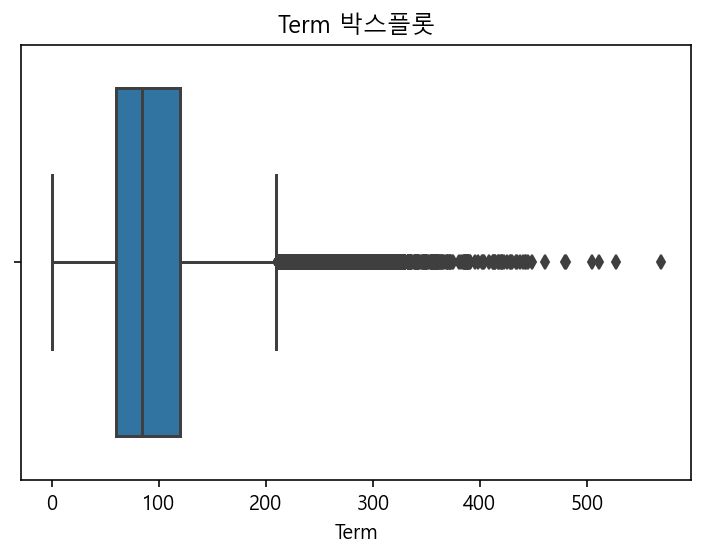

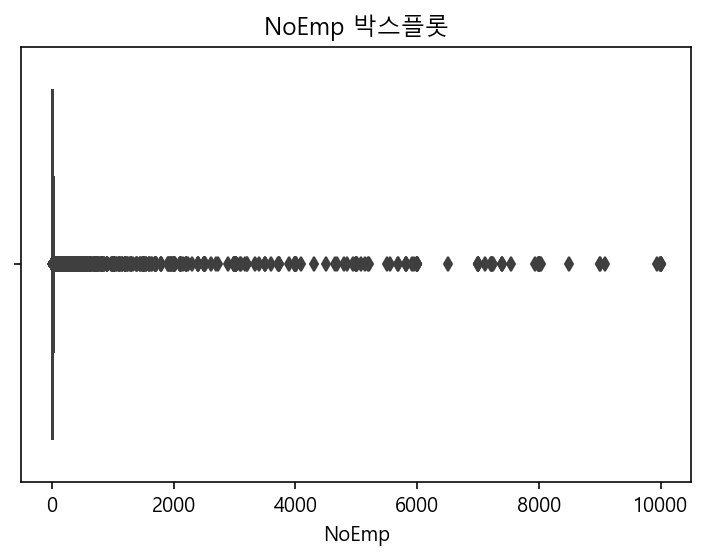

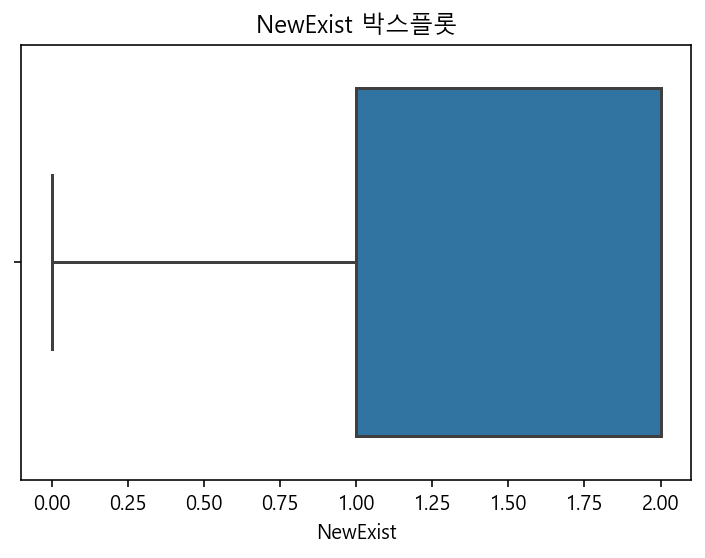

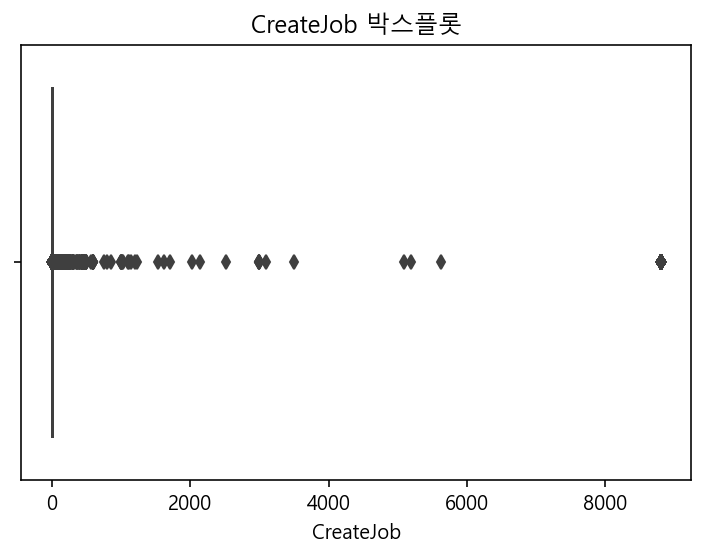

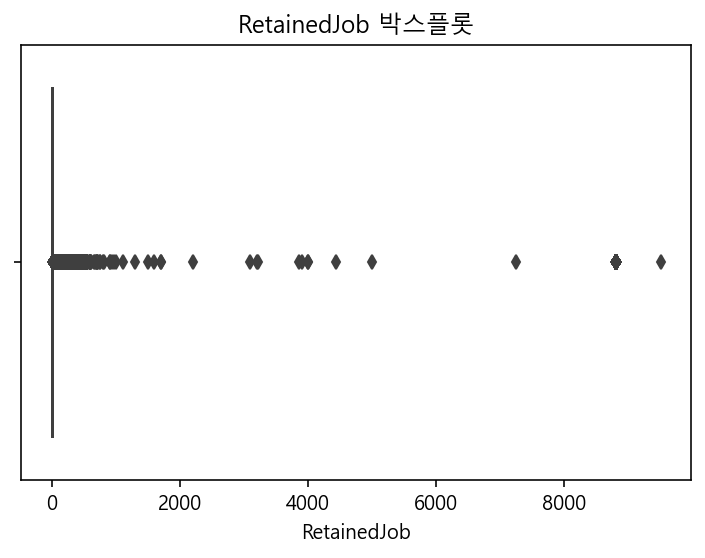

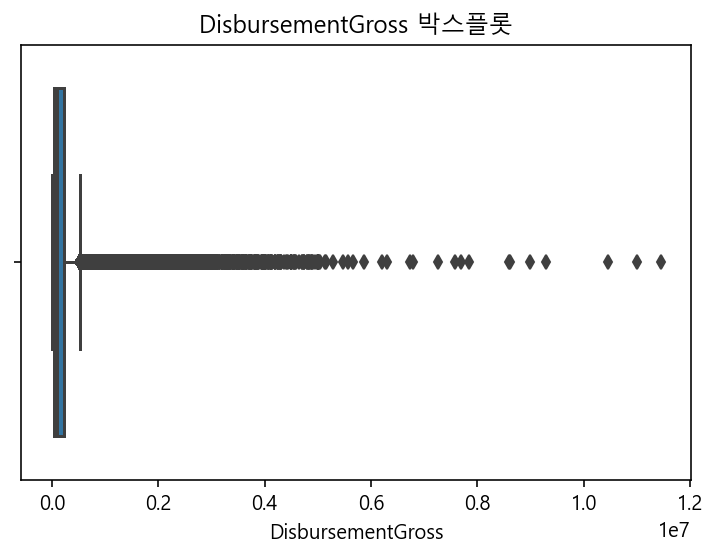

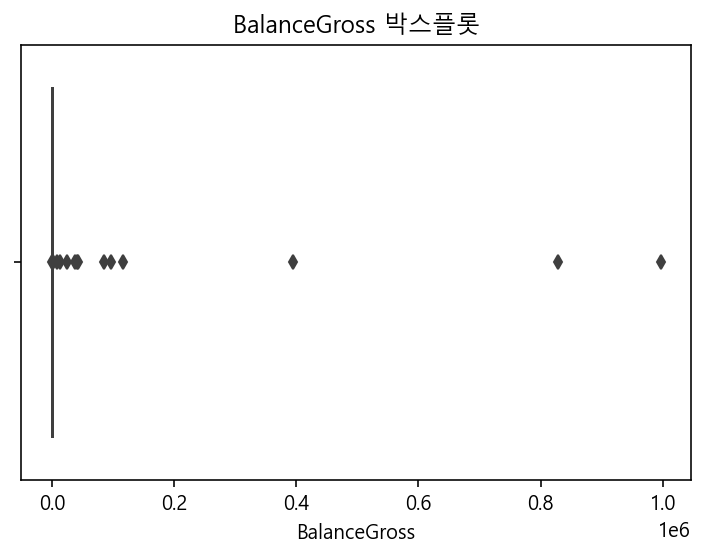

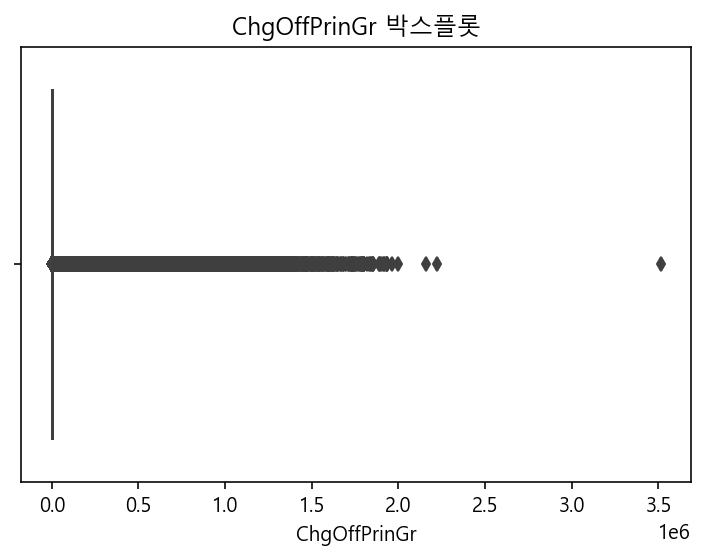

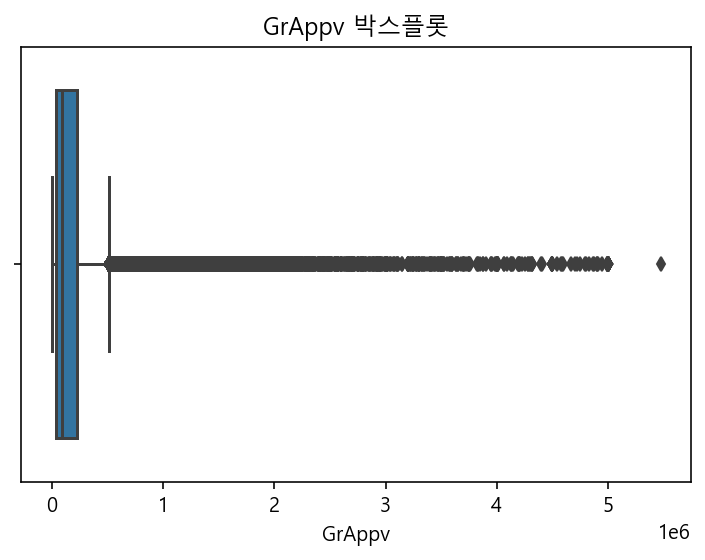

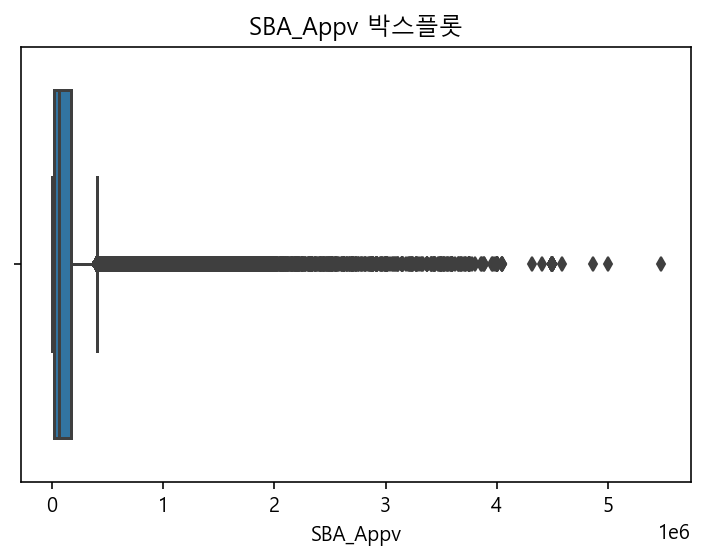

In [34]:
for column in ['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'BalanceGross','ChgOffPrinGr', 'GrAppv', 'SBA_Appv']:
    sns.boxplot(x=column, data=df)
    plt.title('{} 박스플롯'.format(column))
    plt.show()

- NewExist을 제외한 나머지 수치형 변수(Term, NoEmp, CreateJob, RetainedJob, DisbursementGross, BalanceGross, ChgOffPrinGr, GrAppv, SBA_Appv)에 이상치가 존재하는 것처럼 보임. 
- **1차 전처리에서 확인할 필요!**
- 참고로 오른쪽 하단에 1e6은 해당 축이 수백만의 범위를 다루고 있음을 나타냄. 데이터의 값이 매우 크기 때문에 나타난 현상.

## ***데이터 요약**

In [24]:
# 데이터 요약
def report(df1):
    col = []          # 열 이름
    d_type = []       # 데이터 타입
    uniques = []      # 유일값 처음 5개
    n_uniques = []    # 유일값 개수(NaN제외)
    nan_count = []    # 결측치 개수
    nan_percent = []  # 결측치 비율

    for i in df.columns:
        col.append(i)
        d_type.append(df1[i].dtypes)
        uniques.append(df1[i].unique()[:5])
        n_uniques.append(df1[i].nunique())
        nan_count.append(df1[i].isna().sum())
        nan_percent.append(df1[i].isna().sum()/len(df)*100)

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques, 'nan_count': nan_count, 'nan%': nan_percent})


report(df)

,Column,d_type,unique_sample,n_uniques,nan_count,nan%
0,LoanNr_ChkDgt,int64,"[1000014003, 1000024006, 1000034009, 100004400...",899164,0,0.000000
1,Name,object,"[ABC HOBBYCRAFT, LANDMARK BAR & GRILLE (THE), ...",779583,14,0.001557
2,City,object,"[EVANSVILLE, NEW PARIS, BLOOMINGTON, BROKEN AR...",32581,30,0.003336
3,State,object,"[IN, OK, FL, CT, NJ]",51,14,0.001557
4,Zip,int64,"[47711, 46526, 47401, 74012, 32801]",33611,0,0.000000
5,Bank,object,"[FIFTH THIRD BANK, 1ST SOURCE BANK, GRANT COUN...",5802,1559,0.173383
6,BankState,object,"[OH, IN, OK, FL, DE]",56,1566,0.174162
7,NAICS,int64,"[451120, 722410, 621210, 0, 332721]",1312,0,0.000000
8,ApprovalDate,object,"[28-Feb-97, 2-Jun-80, 7-Feb-06, 11-Jun-80, 4-O...",9859,0,0.000000
9,ApprovalFY,object,"[1997, 1980, 2006, 1998, 1999]",52,0,0.000000


### 6. 상관계수 확인
- 수치형 변수들에 한해 상관관계 확인
- 형태는 수치형이지만, 의미상 범주형인 경우 제외

In [16]:
# 변수 간 상관계수 계산
cor = df[['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'BalanceGross','ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].corr()
cor

,Term,NoEmp,NewExist,CreateJob,RetainedJob,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
Term,1.000000,0.046140,-0.073100,0.027581,0.024931,0.466391,0.001701,-0.047319,0.502610,0.524912
NoEmp,0.046140,1.000000,-0.040222,0.008626,0.015350,0.088651,-0.000122,0.007800,0.090430,0.092566
NewExist,-0.073100,-0.040222,1.000000,-0.002130,-0.009128,-0.074405,0.001355,0.018502,-0.066506,-0.063976
CreateJob,0.027581,0.008626,-0.002130,1.000000,0.993953,0.006955,-0.000057,0.009378,0.008182,0.013749
RetainedJob,0.024931,0.015350,-0.009128,0.993953,1.000000,0.010274,-0.000080,0.010632,0.010693,0.014891
DisbursementGross,0.466391,0.088651,-0.074405,0.006955,0.010274,1.000000,0.005595,0.192251,0.971242,0.940134
BalanceGross,0.001701,-0.000122,0.001355,-0.000057,-0.000080,0.005595,1.000000,-0.000430,0.005739,0.005266
ChgOffPrinGr,-0.047319,0.007800,0.018502,0.009378,0.010632,0.192251,-0.000430,1.000000,0.194453,0.165476
GrAppv,0.502610,0.090430,-0.066506,0.008182,0.010693,0.971242,0.005739,0.194453,1.000000,0.974360
SBA_Appv,0.524912,0.092566,-0.063976,0.013749,0.014891,0.940134,0.005266,0.165476,0.974360,1.000000


Text(0.5, 1.0, '상관계수 히트맵')

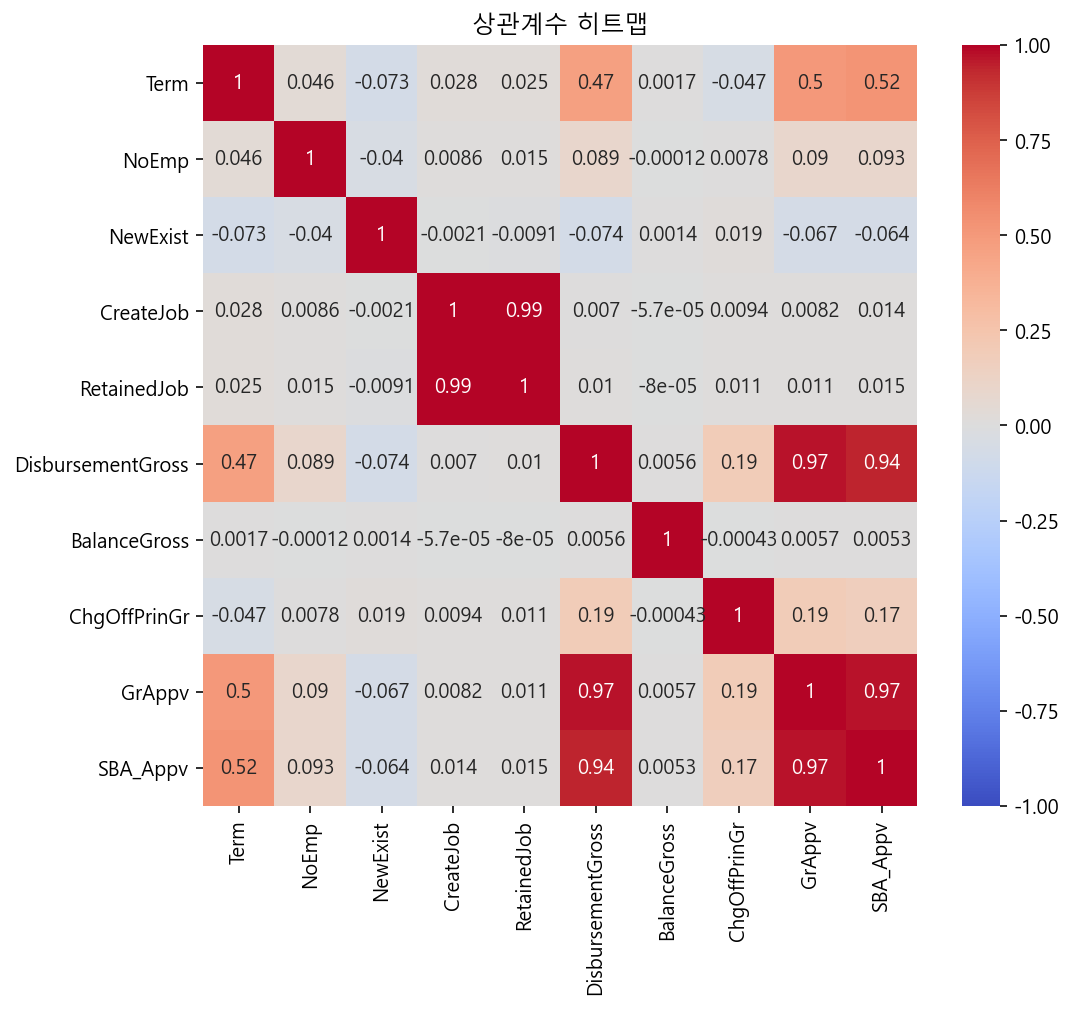

In [17]:
# 히트맵 시각화
plt.figure(figsize=(8,7)) #사이즈 조정
sns.heatmap(cor, cmap="coolwarm", annot=True, vmin=-1,vmax=1)
plt.title('상관계수 히트맵')

#cmap: 컬러맵 설정
#annot=True: 상관계수 표시 여부
#vmin, vmax: 최대, 최소 값 설정

- 전체적으로 변수들 사이에 상관관계가 크지 않음.
- 제일 상관계수가 큰 변수쌍은 (CreateJob, RetainedJob)

Text(0.5, 1.0, '상관계수 히트맵')

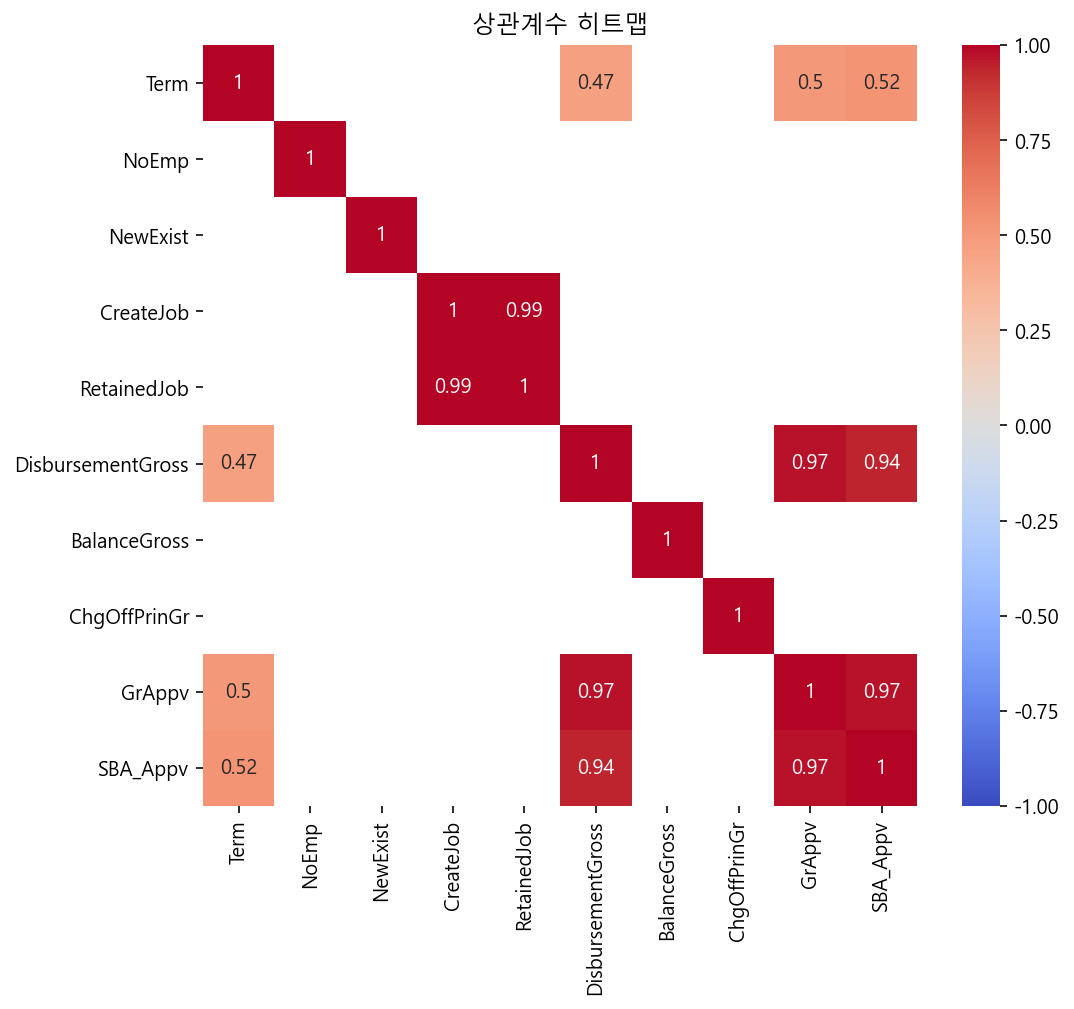

In [18]:
# 히트맵에서 상관계수의 절댓값이 0.4 이상인 경우만 추출
plt.figure(figsize=(8,7))
sns.heatmap(cor[abs(cor) >= 0.4], cmap="coolwarm", annot=True, vmin=-1,vmax=1)
plt.title('상관계수 히트맵')

- 대출기간과 지급된 금액 간의 상관관계는 0.47으로 뚜렷한 양의 상관관계를 보인다.(대출기간이 길어질수록 지급된 금액이 많다)
- 대출기간과 은행에서 승인한 대출 금액 간의 상관관계는 0.5로 뚜렷한 양의 상관관계를 보인다.(대출기간이 길어질수록 은행에서 승인한 대출 금액이 크다)
- 대출기간과 SBA에서 승인한 대출 금액 간의 상관관계는 0.52로 뚜렷한 양의 상관관계를 보인다.(대출기간이 길어질수록 SBA에서 승인한 대출 금액이 크다)
- 장기로 대출을 하는 경우, 실제 대출 금액과 기관에서 승인한 대출 금액 모두 크다.
- 상식적으로 ok

- 창출 직원 수와 유지 직원 수 간의 상관관계는 0.99로 강한 양의 상관관계를 보인다.
- 일자리가 늘어나 직원의 수가 늘어나는 것은 당연하므로 상식적으로 ok

- 지급된 금액과 은행에서 승인한 대출 금액 간의 상관관계는 0.97로 강한 양의 상관관계를 보인다.
- 지급된 금액과 SBA에서 승인한 대출 금액 간의 상관관계는 0.94로 강한 양의 상관관계를 보인다.
- 은행에서 승인한 대출 금액과, SBA에서 승인한 대출 금액 간의 상관관계는 0.97로 강한 양의 상관관계를 보인다.
- 실제로 대출을 해줬을 때, 지급한 금액과 은행/SBA 대출 보증금액 간에 큰 차이가 없다고 해석할 수 있다. 
- 상식적으로 ok

### 7. 변수별 분포 확인

범주형 변수 : MIS_Status, LoanNr_ChkDgt, Name, City, State, Zip, Bank, BankState, NAICS, ApprovalDate, ApprovalFY, NewExist, FranchiseCode, UrbanRural, RevLineCr, LowDoc, ChgOffDate, DisbursementDate (의미상 범주형 변수도 포함)

## (1) MIS_Status : 채무이행 유무(Target Variable)

In [13]:
df.MIS_Status

0          P I F
1          P I F
2          P I F
3          P I F
4          P I F
           ...  
899159     P I F
899160     P I F
899161     P I F
899162    CHGOFF
899163     P I F
Name: MIS_Status, Length: 899164, dtype: object

In [6]:
# 채무이행(0), 채무불이행(1)로 카테고리화
df['MIS_Status']=df['MIS_Status'].replace({'P I F':0, 'CHGOFF':1})
df['MIS_Status']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
899159    0.0
899160    0.0
899161    0.0
899162    1.0
899163    0.0
Name: MIS_Status, Length: 899164, dtype: float64

In [7]:
df['MIS_Status'].unique()

array([ 0.,  1., nan])

In [12]:
# MIS_Status 칼럼이 NA인 경우만 추출해보기
# ChgOffPrinGr 칼럼과 비교하여 값이 0인 경우와 그렇지 않은 경우
df[df['MIS_Status'].isnull()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
343,1002585010,"Chinaberry, LTD",Saratoga Springs,NY,12866,KEYBANK NATIONAL ASSOCIATION,OH,0,18-May-98,1998,...,0,N,NaN,30-Jun-98,474,0,NaN,0,30000,15000
611,1004503009,SMITHFIELD GLASS INC,DANIELSON,CT,6239,NaN,NaN,0,7-Jul-80,1980,...,N,N,22-May-90,NaN,0,0,NaN,144461,300000,300000
738,1005264007,AMERICAN CERTIFIED HOME INSPEC,BOISE,ID,83703,WELLS FARGO BANK NATL ASSOC,SD,0,3-Mar-97,1997,...,T,N,NaN,30-Apr-00,2585,0,NaN,0,10000,5000
740,1005273003,"GENERAL SOLAR COMPANY, INC.",SIOUX CITY,IA,51111,NaN,NaN,0,3-Jul-80,1980,...,N,N,8-Feb-90,NaN,0,0,NaN,142666,350000,350000
833,1005845000,SPROUT KIDS INC.,HUNTINGTON,NY,11743,JPMORGAN CHASE BANK NATL ASSOC,IL,424330,3-Mar-03,2003,...,N,N,NaN,31-Mar-03,1276,0,NaN,0,25000,12500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892340,9855003006,PATHCO,ALAMEDA,CA,94605,WELLS FARGO BANK NATL ASSOC,SD,0,19-Dec-96,1997,...,0,N,NaN,NaN,0,0,NaN,0,50000,25000
893791,9879293006,YAMA SEAFOOD L.A.,SAN GABRIEL,CA,91776,WELLS FARGO BANK NATL ASSOC,SD,0,6-Jan-97,1997,...,0,N,NaN,30-Apr-98,373,0,NaN,0,25000,12500
894290,9889203005,SKY PILOT RESTORATIONS,PORTLAND,OR,97206,WELLS FARGO BANK NATL ASSOC,SD,0,10-Jan-97,1997,...,T,N,NaN,31-Jul-97,20,0,NaN,0,10000,5000
896318,9932493007,"SMITH, CURTIS",RICHMOND,VA,23225,FIRST COMMUNITY BANK,VA,0,30-Jan-97,1997,...,N,Y,NaN,13-Feb-97,3500,0,NaN,0,3500,2800


In [13]:
# 채무 불이행인 경우 중, 청구된 금액이 없는 경우 있는지 추출
df[(df['MIS_Status'] == 1) & (df['ChgOffPrinGr'] == 0)]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
489,1003773007,"BLOOMINGSHIRE, INC.",BLOOMINGDALE,IL,60108,MB FINAN BANK NATL ASSOC,IL,0,30-Jun-80,1980,...,N,N,16-May-90,8-Jan-82,75000,0,1.0,0,120000,108000
900,1006233004,KIDDIE KASTLE INC,MILFORD,CT,6460,"TD BANK, NATIONAL ASSOCIATION",CT,0,10-Jul-80,1980,...,N,N,26-Oct-89,22-Aug-80,25000,0,1.0,0,25000,22500
3589,1024004005,CAN HEATING & AIR CONDITIONING,NORTHRIDGE,CA,91325,"CITIBANK, N.A.",SD,235110,10-Mar-97,1997,...,N,N,NaN,30-Apr-97,159300,0,1.0,0,159300,119475
3713,1025013003,THE AIRMEN INC,KANSAS CITY,MO,64116,COUNTRY CLUB BANK,KS,0,13-Aug-80,1980,...,N,N,22-Aug-89,30-Sep-80,500000,0,1.0,0,500000,450000
5414,1036933003,RUSSELL D. BRAY,MIDVALE,UT,84047,U.S. BANK NATIONAL ASSOCIATION,OH,0,3-Sep-80,1980,...,N,N,26-Jul-89,2-Oct-80,25000,0,1.0,0,25000,22500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885509,9696041006,THE WIGGERY,NASHVILLE,TN,37219,CITIZENS SAVINGS BK & TR CO,TN,0,11-Sep-79,1979,...,N,N,28-Aug-96,30-Oct-79,66000,0,1.0,0,66000,59400
885600,9701691008,P I D ALASKA INC,ANCHORAGE,AK,99502,KEYBANK NATIONAL ASSOCIATION,WA,0,4-Jan-82,1982,...,N,N,22-Aug-95,22-Mar-82,555000,0,1.0,0,555000,499500
888616,9774591003,SEATTLE WESTERN INDUSTRIES INC,PORT ORCHARD,WA,98366,KITSAP BANK,WA,0,18-Jul-79,1979,...,N,N,4-Oct-89,27-Jul-79,90000,0,1.0,0,90000,81000
888681,9775961009,MANDARIN INTERNATIONAL CO INC,SEATTLE,WA,98104,NaN,NaN,0,22-Nov-79,1980,...,N,N,8-Apr-89,11-Jan-80,55000,0,1.0,0,55000,49500


In [14]:
# 채무 이행인 경우 중, 청구된 금액이 있는 경우 있는지 추출
df[(df['MIS_Status'] == 0) & (df['ChgOffPrinGr'] != 0)]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
558,1004176005,GREENLIFE MOBILE,SAN JOSE,CA,95132,BBCN BANK,CA,561730,7-Feb-06,2006,...,0,N,19-Oct-09,28-Feb-06,5000,0,0.0,3330,5000,4250
850,1005925000,GILLIAN'S DELICATESSEN & CATER,FLORAL PARK,NY,11001,JPMORGAN CHASE BANK NATL ASSOC,IL,722320,26-Mar-03,2003,...,N,N,29-Mar-06,31-Mar-03,15000,0,0.0,10270,15000,7500
853,1005936010,TRICAS MANAGEMENT SERVICES LLC,DALLAS,TX,75218,WELLS FARGO BANK NATL ASSOC,SD,621511,8-Feb-06,2006,...,Y,N,2-Feb-09,31-Mar-06,165553,0,0.0,97486,100000,50000
861,1005986003,CAPITAL EXPLOSION GRAPHIC DESI,UPPER MARLBORO (MARLBORO),MD,20774,BBCN BANK,CA,541430,8-Feb-06,2006,...,0,N,14-Aug-12,28-Feb-06,10000,0,0.0,2310,10000,8500
866,1006016007,C-BARB AND CONLEY PROMOTIONAL,HOUSTON,TX,77057,BBCN BANK,CA,421450,8-Feb-06,2006,...,0,N,1-Jun-09,28-Feb-06,5000,0,0.0,3783,5000,4250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895467,9913513005,INFINITE TECH. CORPORATION,RICHARDSON,TX,75080,LEGACYTEXAS BANK,TX,541512,23-Jan-97,1997,...,N,N,29-Dec-11,31-May-97,441000,0,0.0,6462,441000,330750
895669,9918003004,"ANRO INSULATION, INC.",STAFFORD,VA,22554,MANUFACTURERS & TRADERS TR CO,MD,235420,24-Jan-97,1997,...,N,Y,22-Mar-00,19-Feb-97,50000,0,0.0,46165,50000,40000
897114,9950351001,CLUB 191,PORTSMOUTH,IA,51565,NaN,NaN,0,24-Jul-78,1978,...,N,N,23-Nov-88,6-Dec-78,65000,0,0.0,20878,65000,48750
897735,9963813010,"J.T. AUTOMOTIVE SERVICES, LLC",SOUTHINGTON,CT,6489,"TD BANK, NATIONAL ASSOCIATION",DE,0,13-Feb-97,1997,...,N,Y,26-Apr-06,31-May-97,60000,0,0.0,17236,60000,48000


=> 약 90만 개의 데이터 중 7568개는 전체 데이터의 0.84%이므로 버려도 된다고 판단. 

In [97]:
# 두 번째 방법 채택
df2 = df.drop(df[(df['MIS_Status'] == 1) & (df['ChgOffPrinGr'] == 0)].index) #청구된 금액이 0인데도 채무불이행으로 판정된 경우 제거
df2 = df2.drop(df2[(df2['MIS_Status'] == 0) & (df2['ChgOffPrinGr'] != 0)].index) #청구된 금액이 0이 아닌데도 채무이행으로 판정된 경우 제거
df3 = df2.drop(df[df['MIS_Status'].isnull()].index) #MIS_Status가 NA인 경우 제거
df3

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,60000,0,0.0,0,60000,48000
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,40000,0,0.0,0,40000,32000
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,287000,0,0.0,0,287000,215250
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,35000,0,0.0,0,35000,28000
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,229000,0,0.0,0,229000,229000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,70000,0,0.0,0,70000,56000
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,...,Y,N,NaN,31-Oct-97,85000,0,0.0,0,85000,42500
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,...,N,N,NaN,30-Sep-97,300000,0,0.0,0,300000,225000
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,N,Y,8-Mar-00,31-Mar-97,75000,0,1.0,46383,75000,60000


In [16]:
df3.shape

(891596, 27)

In [17]:
df3['MIS_Status'].unique()

array([0., 1.])

=> NA값 없는 거 확인

In [98]:
df3['MIS_Status'] = df3['MIS_Status'].astype(int)

In [99]:
df3['MIS_Status'].value_counts()

0    734725
1    156871
Name: MIS_Status, dtype: int64

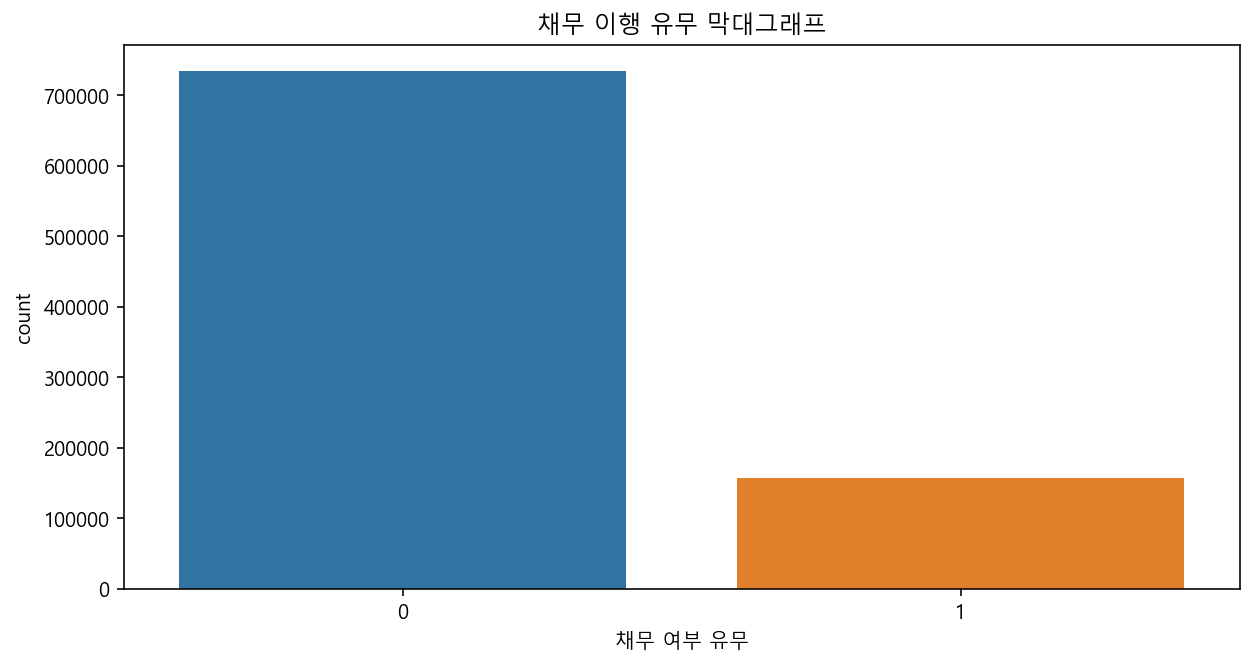

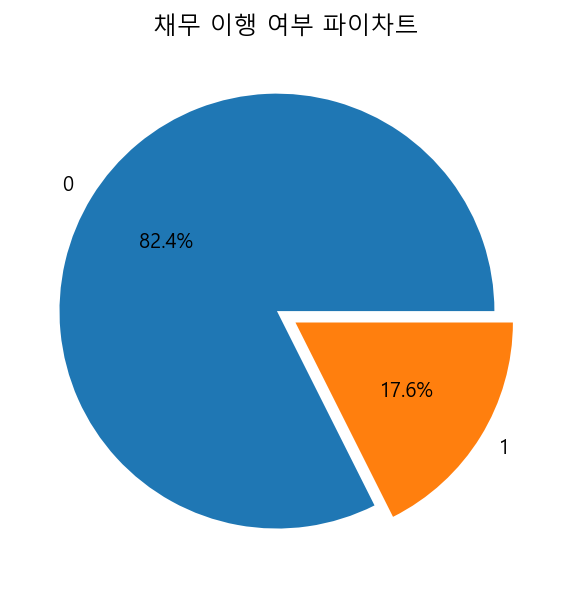

In [100]:
# 분포 확인하기
# 막대그래프
plt.figure(figsize=(10, 5))
sns.countplot(x='MIS_Status', data=df3)
plt.title('채무 이행 유무 막대그래프')
plt.xlabel('채무 여부 유무')
plt.show()

# 파이차트
plt.figure(figsize=(10, 5))
df3['MIS_Status'].value_counts().plot.pie(explode=[0.05, 0.05], autopct='%.1f%%')
plt.title('채무 이행 여부 파이차트')
plt.ylabel('')
plt.show()

=> 채무 이행 : 채무 불이행 = 약 8:2 정도로 불균형한 데이터임을 확인할 수 있다.

## (2) LoanNr_ChkDgt : 고유 식별 키

In [101]:
df3['LoanNr_ChkDgt']

0         1000014003
1         1000024006
2         1000034009
3         1000044001
4         1000054004
             ...    
899159    9995573004
899160    9995603000
899161    9995613003
899162    9995973006
899163    9996003010
Name: LoanNr_ChkDgt, Length: 891596, dtype: int64

In [102]:
#'LoanNr_ChkDgt' 칼럼을 기준으로 중복된 값 확인
duplicate_rows = df3[df3.duplicated(['LoanNr_ChkDgt'], keep=False)]

if duplicate_rows.empty:
    print("중복된 고유 식별키가 없습니다.")
else:
    print("중복된 고유 식별키가 존재합니다.")
    print(duplicate_rows)

중복된 고유 식별키가 없습니다.


In [103]:
len(df3['LoanNr_ChkDgt'].unique())

891596

- 식별 키에 중복된 값이 없는 것을 확인할 수 있다.
- 고윳값의 개수와 전체 데이터 개수가 동일하므로 정상
- LoanNr_ChkDgt는 차용자 고유 ID로 index와 동일한 역할

## (3) Name : 차용 기업명

In [104]:
df3.Name

0                         ABC HOBBYCRAFT
1            LANDMARK BAR & GRILLE (THE)
2                  WHITLOCK DDS, TODD M.
3          BIG BUCKS PAWN & JEWELRY, LLC
4            ANASTASIA CONFECTIONS, INC.
                       ...              
899159                      FABRIC FARMS
899160                      FABRIC FARMS
899161      RADCO MANUFACTURING CO.,INC.
899162             MARUTAMA HAWAII, INC.
899163    PACIFIC TRADEWINDS FAN & LIGHT
Name: Name, Length: 891596, dtype: object

In [105]:
len(df3['Name'].unique())

773787

=> 고윳값의 개수가 Name 데이터 개수(891596)와 다르므로 확인 필요.(2회 이상 빌린 기업이 있다는 뜻)

In [106]:
# 중복된 이름 추출
duplicate_names = df3[df3.duplicated(['Name'], keep=False)]
duplicate_names

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,229000,0,0,0,229000,229000
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,N,24-Jun-91,22-Jul-80,600000,0,1,208959,600000,499998
12,1000146010,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,445299,7-Feb-06,2006,...,N,N,NaN,31-Mar-06,253400,0,0,0,253400,190050
15,1000244002,"ENVIRONMENTAL ROOFING SYSTEMS,",OKLAHOMA CITY,OK,73112,BANK OF AMERICA NATL ASSOC,NC,421330,28-Feb-97,1997,...,N,N,NaN,30-Sep-97,350000,0,0,0,350000,262500
18,1000284003,FANTASTIC SAMS,PLANO,TX,75093,NEWTEK SMALL BUS. FINANCE INC.,NY,0,28-Feb-97,1997,...,N,Y,NaN,31-May-97,57500,0,0,0,57500,46000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899152,9995403010,D D MUDD,IDAHO FALLS,ID,83405,BANK OF IDAHO,ID,0,27-Feb-97,1997,...,N,Y,NaN,31-Mar-97,38000,0,0,0,38000,30400
899154,9995423005,"LITWIN LIVERY SERVICES, INC.",CAMPBELL,OH,44405,JPMORGAN CHASE BANK NATL ASSOC,IL,0,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,10000,0,0,0,10000,5000
899157,9995493004,PULLTARPS MFG.,EL CAJON,CA,92020,U.S. BANK NATIONAL ASSOCIATION,CA,314912,27-Feb-97,1997,...,N,N,NaN,31-Mar-97,200000,0,0,0,200000,150000
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,70000,0,0,0,70000,56000


In [107]:
duplicate_names['Name'].value_counts()

SUBWAY                           1267
QUIZNO'S SUBS                     432
COLD STONE CREAMERY               365
QUIZNO'S                          345
DAIRY QUEEN                       328
                                 ... 
CHEZ THUY CORPORATION               2
OWNERENT                            2
PAUL DAVIS SYSTEMS OF THE RED       2
COUNTERTOPS UNLIMITED               2
U.C. Precision, Inc.                2
Name: Name, Length: 71739, dtype: int64

In [108]:
# Name 빈도 중 가장 많은 값을 차지하고 있는 SUBWAY만 추출해보기
subway = df3[df3.Name == 'SUBWAY']
subway

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
24,1000446006,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,722211,7-Feb-06,2006,...,N,N,NaN,30-Apr-06,137300,0,0,0,137300,116705
3156,1020836002,SUBWAY,GLEN MILLS,PA,19342,"PNC BANK, NATIONAL ASSOCIATION",DE,722211,10-Feb-06,2006,...,0,N,NaN,31-Mar-06,50000,0,0,0,50000,25000
7461,1050586000,SUBWAY,MANCHESTER,ME,4351,BANGOR SAVINGS BANK,ME,722211,16-Feb-06,2006,...,0,N,NaN,31-Mar-06,102000,0,0,0,102000,86700
8287,1056105001,SUBWAY,NORWICH,CT,6360,BANK OF AMERICA NATL ASSOC,RI,722211,8-Sep-04,2004,...,Y,N,NaN,31-Oct-04,47000,0,0,0,47000,23500
10198,1071404010,SUBWAY,ATHENS,TX,75751,COMMUNITY NATL BK & TR OF TEXA,TX,0,1-Apr-97,1997,...,N,Y,NaN,30-Apr-97,77600,0,0,0,77600,62080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896071,9927733002,SUBWAY,NASHVILLE,TN,37219,FIRST TENNESSEE BANK NATL ASSO,TN,0,29-Jan-97,1997,...,N,Y,NaN,31-Jul-97,72000,0,0,0,72000,57600
898205,9975573007,SUBWAY,MEMPHIS,TN,38118,TRI-STATE BANK OF MEMPHIS,TN,0,20-Feb-97,1997,...,N,Y,NaN,31-Mar-99,100000,0,0,0,100000,80000
898282,9976863002,SUBWAY,EDMONDS,WA,98026,WELLS FARGO BANK NATL ASSOC,SD,0,20-Feb-97,1997,...,0,N,NaN,30-Jun-97,200000,0,0,0,200000,150000
898629,9984303009,SUBWAY,DURANT,OK,74701,LANDMARK BANK NATL ASSOC,OK,0,24-Feb-97,1997,...,N,Y,NaN,31-May-97,100000,0,0,0,100000,80000


In [109]:
# subway의 채무이행 : 채무불이행 빈도 확인
subway.MIS_Status.value_counts()

0    1201
1      66
Name: MIS_Status, dtype: int64

In [110]:
subway.City.value_counts()

CHICAGO         28
NEW YORK        17
CHARLOTTE       13
INDIANAPOLIS    13
COLUMBUS        11
                ..
CANANDAIQUA      1
WEST WARWICK     1
JACKSONVILLE     1
ENOLA            1
DUMFRIES         1
Name: City, Length: 815, dtype: int64

In [111]:
subway.State.value_counts()

NY    97
PA    91
OH    77
TX    62
CA    61
NJ    61
MA    58
IL    51
IN    48
OK    47
WI    47
WA    47
NC    45
MO    39
FL    31
KY    28
AZ    26
KS    24
VA    22
MI    22
MD    21
GA    18
RI    16
CT    16
IA    15
MN    15
ID    15
CO    14
LA    14
AL    13
SC    12
MT    11
WV    10
TN    10
NE     9
HI     8
AR     8
OR     8
NM     8
SD     8
ME     6
NH     5
NV     4
ND     4
MS     3
DE     3
VT     3
DC     2
UT     2
AK     1
WY     1
Name: State, dtype: int64

In [112]:
subway.FranchiseCode.value_counts()

78760    1112
1         144
78759       5
0           3
21425       1
78755       1
78640       1
Name: FranchiseCode, dtype: int64

- SUBWAY는 프랜차이즈 기업인데 0과 1로 분류(프랜차이즈 아님)되어 있는 경우도 있음 => 시간 차이 때문에 그런 것인지?
- SUBWAY는 프랜차이즈 기업이므로 미국의 특정 도시나 주에만 있지 않은 것을 확인할 수 있다.

### Name 결측치 처리

In [113]:
df3.Name.isna().sum()

14

In [114]:
df3[df3.Name.isnull()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
272,1002095005,NaN,Logan,UT,84321,JPMORGAN CHASE BANK NATL ASSOC,IL,421910,17-Feb-98,1998,...,0,N,NaN,31-Mar-00,50000,0,0,0,50000,25000
409,1003125003,NaN,Cobleskill,NY,12043,KEYBANK NATIONAL ASSOCIATION,OH,0,11-Sep-98,1998,...,Y,N,NaN,30-Apr-99,100000,0,0,0,100000,50000
465,1003575009,NaN,Tarrytown,NY,10591,KEYBANK NATIONAL ASSOCIATION,OH,541512,23-Feb-99,1999,...,Y,N,NaN,31-May-99,100000,0,0,0,100000,50000
466,1003585001,NaN,Mahopac,NY,10541,KEYBANK NATIONAL ASSOCIATION,OH,311920,4-Mar-99,1999,...,N,N,NaN,31-Mar-99,25000,0,0,0,25000,12500
51439,1395235010,NaN,Morton,IL,61550,HEARTLAND BK & TR CO,IL,811219,1-Aug-05,2005,...,N,N,NaN,31-Aug-06,150000,0,0,0,150000,75000
82751,1616875008,NaN,Cleveland,OH,44128,"FIRSTMERIT BANK, N.A.",OH,238350,17-Jan-06,2006,...,T,N,NaN,31-Jul-06,22044,0,0,0,10000,5000
103696,1763546010,NaN,LANSDALE,PA,19446,SUSQUEHANNA BANK,PA,423990,14-Apr-06,2006,...,N,N,NaN,28-Feb-07,340000,0,0,0,340000,306000
143179,2046175001,NaN,Waterloo,IA,50703,WELLS FARGO BANK NATL ASSOC,SD,442110,28-Sep-06,2006,...,N,N,12-Aug-14,31-Dec-06,74500,0,1,49935,74500,63325
197401,2392194003,NaN,TROY,NY,12180,MANUFACTURERS & TRADERS TR CO,NY,0,16-Oct-98,1999,...,0,Y,NaN,30-Nov-98,40000,0,0,0,40000,32000
197428,2392384001,NaN,E. AMHERST,NY,14051,BANK OF AMERICA NATL ASSOC,RI,811310,16-Oct-98,1999,...,0,Y,NaN,28-Feb-99,28000,0,0,0,28000,22400


In [117]:
14/len(df3)*100

0.0015702179013813429

=> Name이 결측인 경우는 14개로, 전체 데이터의 약 0.001% 정도를 차지한다. 따라서 제거해도 무방할 것 같음.

In [118]:
df3 = df3.dropna(subset=['Name'])
df3.Name.isna().sum()

0

In [119]:
df3.shape

(891582, 27)

=> Name은 기업명에 대한 정보만 파악하는 정도로 사용할 것 같음

## (4) City : 차용 기업이 위치한 city

In [120]:
df3.City

0              EVANSVILLE
1               NEW PARIS
2             BLOOMINGTON
3            BROKEN ARROW
4                 ORLANDO
               ...       
899159    UPPER ARLINGTON
899160           COLUMBUS
899161        SANTA MARIA
899162           HONOLULU
899163             KAILUA
Name: City, Length: 891582, dtype: object

In [121]:
df3.City.value_counts()

LOS ANGELES        11431
HOUSTON            10124
NEW YORK            7767
CHICAGO             5941
MIAMI               5530
                   ...  
SIMI VALLEY, CA        1
Indian Orchard         1
WARMINISTERE           1
S LONDONDERRY          1
Land O' Lakes          1
Name: City, Length: 32478, dtype: int64

### City 결측치 처리하기

In [122]:
df3.City.isna().sum()

30

In [123]:
df3[df3.City.isnull()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
42535,1330603010,BUSATH PHOTOGRAPHY,NaN,UT,84109,MOUNTAIN W. SMALL BUS. FINAN,UT,0,15-Dec-81,1982,...,N,N,NaN,6-Jan-82,190000,0,0,0,190000,190000
177891,2268732010,"HAYES/DOCKSIDE,INC",NaN,LA,70130,NEW ORLEANS REGIONAL BUS. DEVE,LA,0,17-Dec-81,1982,...,N,N,NaN,10-Feb-82,500000,0,0,0,500000,500000
243450,2716822007,"YACHTING &NAVIGATION, LTD",NaN,IL,60624,BANK - AMERICA NATL ASSOC,IL,0,10-Apr-81,1981,...,N,N,NaN,4-Nov-81,150000,0,0,0,150000,150000
243452,2716832010,"ACE PLATING COMPANY,INC.",NaN,IL,60636,NaN,NaN,0,15-May-81,1981,...,N,N,NaN,4-Nov-81,49000,0,0,0,49000,49000
270263,2884182004,"HERMANOS LOPEZ,INC. ""B""",NaN,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,16-Apr-81,1981,...,N,N,NaN,6-Jan-82,488000,0,0,0,488000,488000
270265,2884192007,"RODIECK PLUMBING SUPPLY,INC ""A",NaN,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,15-Jun-81,1981,...,N,N,NaN,10-Sep-81,203000,0,0,0,211000,211000
270268,2884202008,"SAN DIEGO REFRIGERATD SVCS,INC",NaN,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,26-Jun-81,1981,...,N,N,NaN,10-Sep-81,407000,0,0,0,407000,407000
270270,2884212000,"EMACO, INC. ""B""",NaN,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,13-Jul-81,1981,...,N,N,NaN,10-Sep-81,105000,0,0,0,105000,105000
270277,2884232006,"MAYER BLUEPRINT,INC. ""B""",NaN,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,29-Jul-81,1981,...,N,N,NaN,10-Sep-81,159000,0,0,0,159000,159000
270284,2884252001,TEX-WIPE COMPANY,NaN,CA,92102,CDC SMALL BUS. FINAN CORP,CA,0,31-Aug-81,1981,...,N,N,NaN,4-Nov-81,365000,0,0,0,365000,365000


In [124]:
30/len(df3)*100

0.0033648054805951668

=> 결측치는 전체 데이터의 약 0.003%을 차지한다. 제거해도 상관없을 것 같음.

In [125]:
df3 = df3.dropna(subset=['City'])
df3.City.isna().sum()

0

City에 따른 MIS_Status 비율

In [126]:
# City에 따른 MIS_Status 비율
city_mis_ratio = df3.groupby('City')['MIS_Status'].mean()
city_mis_ratio

City
#115, BALTIMORE             0.0
&12151 ALCOSTA BLVD. SAN    0.0
(BOX 79) CAMP SHERMAN       0.0
(RODERFIELD) JOLO           0.0
-                           0.0
                           ... 
warrensville heights        1.0
washington                  0.5
watertown                   0.0
westfield                   0.0
weston                      0.5
Name: MIS_Status, Length: 32478, dtype: float64

=> City에 따른 MIS_Status 비율을 확인하는 것보다, State에 따른 MIS_Status 비율을 확인하는 게 더 좋아보임.(City는 고윳값이 너무 많은 반면, State는 골고루 분포되어 있기 때문)

=> City는 Name과 유사하게 기업이 위치한 도시에 대한 정보만 파악하는 정도로 사용할 것 같음

In [127]:
df3.shape

(891552, 27)

## (5) State : 차용 기업이 위치한 state

In [128]:
df3.State

0         IN
1         IN
2         IN
3         OK
4         FL
          ..
899159    OH
899160    OH
899161    CA
899162    HI
899163    HI
Name: State, Length: 891552, dtype: object

In [129]:
df3.State.value_counts()

CA    129634
TX     69927
NY     56989
FL     40760
PA     34608
OH     32386
IL     29359
MA     24980
MN     24308
NJ     23849
WA     23145
GA     22104
WI     20966
MO     20529
CO     20526
MI     20401
UT     18690
AZ     17533
NC     14153
IN     14002
VA     13083
MD     13027
CT     12059
NH     11984
IA     11947
KS     11402
OR     11006
OK      9874
LA      9462
ID      9457
TN      9303
RI      8905
MT      8698
AL      8286
NV      7968
KY      7688
MS      7622
NE      6357
AR      6313
NM      5997
ME      5910
SC      5539
VT      5420
ND      5202
SD      4407
HI      3572
WV      3255
WY      2828
AK      2384
DE      2173
DC      1562
Name: State, dtype: int64

In [130]:
len(df3.State.value_counts())

51

=> 미국 주의 개수는 50개인데, 51개?

In [131]:
df_state = pd.DataFrame(df3.State.value_counts()).reset_index()
df_state.columns=['State','Count']
print(df_state)

   State   Count
0     CA  129634
1     TX   69927
2     NY   56989
3     FL   40760
4     PA   34608
5     OH   32386
6     IL   29359
7     MA   24980
8     MN   24308
9     NJ   23849
10    WA   23145
11    GA   22104
12    WI   20966
13    MO   20529
14    CO   20526
15    MI   20401
16    UT   18690
17    AZ   17533
18    NC   14153
19    IN   14002
20    VA   13083
21    MD   13027
22    CT   12059
23    NH   11984
24    IA   11947
25    KS   11402
26    OR   11006
27    OK    9874
28    LA    9462
29    ID    9457
30    TN    9303
31    RI    8905
32    MT    8698
33    AL    8286
34    NV    7968
35    KY    7688
36    MS    7622
37    NE    6357
38    AR    6313
39    NM    5997
40    ME    5910
41    SC    5539
42    VT    5420
43    ND    5202
44    SD    4407
45    HI    3572
46    WV    3255
47    WY    2828
48    AK    2384
49    DE    2173
50    DC    1562


In [132]:
df_state.sort_values(by='State')

,State,Count
48,AK,2384
33,AL,8286
38,AR,6313
17,AZ,17533
0,CA,129634
14,CO,20526
22,CT,12059
50,DC,1562
49,DE,2173
3,FL,40760


- DC는 워싱턴 DC로 미국 50개의 주에 포함되지 않고 미국의 수도로서 특별행정구를 의미. 미국 연방 정부가 위치한 지역
- WA는 미국 서북부 지역에 위치한 주로, 시애틀을 비롯한 주요 도시가 있음.

In [133]:
# State가 DC인 경우 City 확인해보기
df3[df3.State=='DC'].head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
1778,1011916000,COLD STONE CREAMERY,WASHINGTON,DC,20008,"PNC BANK, NATIONAL ASSOCIATION",DE,722310,9-Feb-06,2006,...,0,N,NaN,28-Feb-06,420000,0,0,0,420000,315000
2717,1018005005,Shooter's Inc,WASHINGTON,DC,20003,BANK OF AMERICA NATL ASSOC,NC,448150,28-Jun-04,2004,...,Y,N,NaN,31-Jul-04,124275,0,0,0,100000,50000
2777,1018376007,JARVAISE INC,WASHINGTON,DC,20009,"PNC BANK, NATIONAL ASSOCIATION",DE,424340,10-Feb-06,2006,...,0,N,24-Mar-11,31-Mar-06,225000,0,1,149350,225000,168750
3112,1020485008,Merrill M Schnipple dba George,WASHINGTON,DC,20024,BANK OF AMERICA NATL ASSOC,NC,325998,6-Jul-04,2004,...,Y,N,NaN,31-Jul-04,12697,0,0,0,10000,5000
4166,1028455004,"Renaissance Development, LLC",WASHINGTON,DC,20003,BANK OF AMERICA NATL ASSOC,NC,541618,27-Jul-04,2004,...,Y,N,NaN,31-Aug-04,95907,0,0,0,80000,40000


In [134]:
df3[df3.State=='WA'].head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
66,1000764005,"LABELLE MARIEE, INC.",KIRKLAND,WA,98033,BANK OF AMERICA NATL ASSOC,WA,448120,28-Feb-97,1997,...,0,N,NaN,31-Dec-97,30000,0,0,0,30000,15000
83,1000836005,URBAN BEAST-SEATTLE LLC,SEATTLE,WA,98109,U.S. BANK NATIONAL ASSOCIATION,OH,453910,7-Feb-06,2006,...,0,N,24-May-10,31-Aug-06,28090,0,1,28090,28300,24055
92,1000915009,Christian Hinderer,Waterville,WA,98858,WELLS FARGO BANK NATL ASSOC,SD,422720,8-Apr-97,1997,...,0,N,NaN,30-Nov-97,4987,0,0,0,10000,5000
95,1000935004,Hairline Inc.,Vancouver,WA,98663,WELLS FARGO BANK NATL ASSOC,SD,0,8-Apr-97,1997,...,0,N,NaN,28-Feb-99,10000,0,0,0,10000,5000
103,1001015001,The Cheese Box,Moses Lake,WA,98837,WELLS FARGO BANK NATL ASSOC,SD,445310,21-Apr-97,1997,...,0,N,1-Oct-02,28-Feb-98,10000,0,1,9161,10000,5000


- State는 기업이 위치한 주에 대한 정보를 파악하는 정도로 사용할 예정
**BankState와 동일하면 0, 동일하지 않으면 1의 값을 가지는 파생변수 생성할 예정*

### State 결측치 처리하기

In [135]:
df3.State.isna().sum()

13

In [136]:
df3[df3.State.isnull()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
49244,1380800010,TRYON COATS & LEATHER,JOHNSTOWN NY,NaN,0,KEYBANK NATIONAL ASSOCIATION,NY,0,18-May-66,1966,...,N,N,29-Mar-90,16-Aug-66,60000,0,1,6084,60000,54000
264664,2850643009,CENTURY 21 PHILLIPS REALTY,CAMERON PARK,NaN,95682,SBA - EDF ENFORCEMENT ACTION,CO,0,12-Feb-87,1987,...,N,N,NaN,17-Jun-87,81000,0,0,0,83000,83000
306274,3113583009,THE COMPUTER EDGE,"BOX 267, APO AP",NaN,96205,RTC/WESTPORT SAVINGS BANK,CA,541511,21-Jan-88,1988,...,N,N,18-Sep-93,16-Mar-88,50000,0,1,30589,50000,45000
328526,3280213000,KING'S TRUCK WASH,WICHITA,NaN,67219,SOUTH CENT. KANSAS ECONOMIC DE,KS,811192,5-Aug-88,1988,...,N,N,NaN,12-Jul-89,119000,0,0,0,119000,119000
351072,3445553007,JAMES A. NICHOLS,"1542,TABUK,SAUDI ARABIA",NaN,79925,WELLS FARGO BANK NATL ASSOC,TX,532230,19-May-89,1989,...,N,N,NaN,31-Jul-89,60000,0,0,0,60000,54000
366139,3556993002,"GOLF SHOES UNLIMITED, INC.",PALM BEACH GARDENS,NaN,33410,"BEAL BANK, SSB",TX,451110,19-Oct-89,1990,...,N,N,NaN,31-Jan-90,75000,0,0,0,75000,67500
366158,3557093005,CASCO SERVICE,CASCO,NaN,54205,UNION STATE BANK,WI,0,19-Oct-89,1990,...,N,N,NaN,30-Apr-90,300000,0,0,0,300000,252600
367007,3563473008,P & P TOOL INC,SOMERSET,NaN,54025,FIRST BANK OF BALDWIN,WI,0,26-Oct-89,1990,...,N,N,NaN,31-Jan-90,82000,0,0,0,82000,73800
379174,3664443009,WILLIAMS JEWELERS,SALT LAKE CITY,NaN,84124,ZIONS FIRST NATIONAL BANK,UT,448310,14-Dec-89,1990,...,N,N,NaN,31-Jul-90,250000,0,0,0,250000,212500
385418,3714383003,"LAKE MOVIE TYMES, INC.",LAKE OZARK,NaN,65049,CENTRAL BK OF LAKE OF OZARKS,MO,532230,4-Jan-90,1990,...,N,N,NaN,31-Jan-90,75000,0,0,0,75000,67500


In [137]:
13/len(df3)*100

0.0014581314382111194

=> 결측치는 전체 데이터의 약 0.001% 정도를 차지한다. 따라서 제거해도 무방해 보인다.

In [138]:
df3 = df3.dropna(subset=['State'])
df3.State.isna().sum()

0

In [139]:
df3.shape

(891539, 27)

In [140]:
# State에 따른 MIS_Status 비율
state_mis_ratio = df3.groupby('State')['MIS_Status'].mean()
state_mis_ratio

State
AK    0.113255
AL    0.166425
AR    0.167749
AZ    0.208065
CA    0.185592
CO    0.178116
CT    0.140310
DC    0.247119
DE    0.180396
FL    0.275883
GA    0.240907
HI    0.153135
IA    0.114673
ID    0.140531
IL    0.227460
IN    0.176546
KS    0.129802
KY    0.194459
LA    0.181674
MA    0.129824
MD    0.199816
ME    0.096616
MI    0.226067
MN    0.117040
MO    0.152272
MS    0.159145
MT    0.066567
NC    0.194376
ND    0.073049
NE    0.112317
NH    0.106893
NJ    0.202356
NM    0.107721
NV    0.233183
NY    0.200249
OH    0.164793
OK    0.155459
OR    0.152826
PA    0.146440
RI    0.113532
SC    0.205994
SD    0.075562
TN    0.212835
TX    0.188997
UT    0.176351
VA    0.189712
VT    0.073801
WA    0.140160
WI    0.122055
WV    0.162519
WY    0.068600
Name: MIS_Status, dtype: float64

In [141]:
# 데이터프레임으로 생성
state_mis_df = pd.DataFrame({'State': state_mis_ratio.index, 'MIS_Ratio': state_mis_ratio.values})

# MIS_Ratio의 값이 0.2 이상인 경우만 추출
state_mis_df_2 = state_mis_df[state_mis_df['MIS_Ratio'] > 0.2]
state_mis_df_2.sort_values(by='MIS_Ratio', ascending=False) #채무 불이행 비율이 높은 순서대로 정렬

,State,MIS_Ratio
9,FL,0.275883
7,DC,0.247119
10,GA,0.240907
33,NV,0.233183
14,IL,0.227460
22,MI,0.226067
42,TN,0.212835
3,AZ,0.208065
40,SC,0.205994
31,NJ,0.202356


=> FL(플로리다), DC(워싱턴 D.C.), GA(조지아) 순으로 채무불이행률이 높게 나타났다.

## (6) Zip : 차용 기업의 우편 번호

In [142]:
df3.Zip

0         47711
1         46526
2         47401
3         74012
4         32801
          ...  
899159    43221
899160    43221
899161    93455
899162    96830
899163    96734
Name: Zip, Length: 891539, dtype: int64

In [143]:
#'Zip' 칼럼을 기준으로 중복된 값 확인
duplicate_rows = df3[df3.duplicated(['Zip'], keep=False)]

if duplicate_rows.empty:
    print("중복된 고유 식별키가 없습니다.")
else:
    print("중복된 고유 식별키가 존재합니다.")
    display(duplicate_rows)

중복된 고유 식별키가 존재합니다.


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,60000,0,0,0,60000,48000
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,40000,0,0,0,40000,32000
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,287000,0,0,0,287000,215250
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,35000,0,0,0,35000,28000
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,229000,0,0,0,229000,229000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,70000,0,0,0,70000,56000
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,...,Y,N,NaN,31-Oct-97,85000,0,0,0,85000,42500
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,...,N,N,NaN,30-Sep-97,300000,0,0,0,300000,225000
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,N,Y,8-Mar-00,31-Mar-97,75000,0,1,46383,75000,60000


- 중복되는 우편 번호가 있는 것을 확인할 수 있다.
- 우편번호 별로 나눠보기(우편번호는 City, State, BankState, UrbanRural과 연관이 있을 거라고 예상됨)

In [144]:
df3.Zip.value_counts()

10001    924
90015    918
93401    755
90010    729
33166    666
        ... 
47452      1
97364      1
84322      1
92518      1
75045      1
Name: Zip, Length: 33536, dtype: int64

In [145]:
# Zip에서 빈도가 가장 높은 경우만 미리보기
display(df3[df3['Zip']==10001].head())
display(df3[df3['Zip']==90015].head())
display(df3[df3['Zip']==93401].head())

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
306,1002345008,"BACHRACH JACOBS SEARCH GROUP,",NEW YORK,NY,10001,"KEY DIRECT, A BRANCH OF",OH,0,7-Apr-98,1998,...,0,N,NaN,30-Jun-98,100000,0,0,0,100000,50000
2200,1014774009,"J.P.T. DESIGN TEAM, INC.",NEW YORK,NY,10001,BNB HANA BANK NATL ASSOC,NJ,422330,6-Mar-97,1997,...,0,N,NaN,30-Jun-97,50000,0,0,0,50000,40000
8194,1055576007,MEGACARE SERVICES INC,NEW YORK,NY,10001,JPMORGAN CHASE BANK NATL ASSOC,NV,561320,17-Feb-06,2006,...,Y,N,NaN,28-Feb-06,79634,0,0,0,30000,15000
8389,1056746001,SUPERIOR RESOURCE PRINTING & G,NEW YORK,NY,10001,"CITIBANK, N.A.",NY,323115,17-Feb-06,2006,...,Y,N,NaN,28-Feb-06,99900,0,0,0,50000,25000
8933,1061494000,"MEYER JEGER,ESQ",NEW YORK,NY,10001,JPMORGAN CHASE BANK NATL ASSOC,IL,541110,24-Mar-97,1997,...,0,N,NaN,30-Jun-97,35000,0,0,0,35000,17500


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
1006,1006966010,CARE LOVE MEDICAL CENTER,LOS ANGELES,CA,90015,OPEN BANK,CA,621310,8-Feb-06,2006,...,Y,N,16-Jan-08,28-Feb-06,330000,0,1,200000,200000,100000
1937,1012994001,ASRIEL FASHION/SENSHI OF CALIF,LOS ANGELES,CA,90015,BBCN BANK,CA,0,5-Mar-97,1997,...,0,N,NaN,30-Apr-97,185000,0,0,0,185000,138750
2719,1018035003,Hebron Textile Corporation,LOS ANGELES,CA,90015,BANK OF AMERICA NATL ASSOC,NC,448120,28-Jun-04,2004,...,Y,N,NaN,31-Jul-04,100000,0,0,0,100000,50000
3022,1019835009,"Angelica Fashions, Corp",LOS ANGELES,CA,90015,BANK OF AMERICA NATL ASSOC,NC,448120,2-Jul-04,2004,...,Y,N,NaN,30-Nov-04,10000,0,0,0,10000,5000
3141,1020696008,TALENT INTERNATIONAL INC,LOS ANGELES,CA,90015,MUFG UNION BANK NATL ASSOC,CA,424990,10-Feb-06,2006,...,Y,N,NaN,31-Mar-06,52000,0,0,0,50000,25000


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
4846,1033265000,"A. Owen Company, Inc.",SAN LUIS OBISPO,CA,93401,BANK OF AMERICA NATL ASSOC,NC,722211,3-Aug-04,2004,...,Y,N,NaN,31-Oct-04,10000,0,0,0,10000,5000
4873,1033415008,"Anthony O. Company, Inc.",SAN LUIS OBISPO,CA,93401,BANK OF AMERICA NATL ASSOC,NC,722211,3-Aug-04,2004,...,Y,N,NaN,31-Jan-05,10000,0,0,0,10000,5000
4885,1033474008,TRIPLETT HARPS,SAN LUIS OBISPO,CA,93401,MUFG UNION BANK NATL ASSOC,CA,451140,13-Mar-97,1997,...,N,N,NaN,31-May-97,184100,0,0,0,184144,138108
16040,1116595000,Reid's Autobody Incorporated,San Luis Obispo,CA,93401,CAPITAL ONE NATL ASSOC,VA,811111,1-Dec-04,2005,...,N,N,NaN,31-Dec-04,35000,0,0,0,35000,17500
23596,1177244008,ADOBE INN,SAN LUIS OBISPO,CA,93401,COMMUNITY W. BANK NATL ASSOC,CA,0,29-Apr-97,1997,...,0,N,NaN,30-Jun-97,600000,0,0,0,600000,450000


=> Zip의 빈도가 가장 높은 10001은 뉴욕, 다음으로 높은 93401은 샌 루이스 오비스포(캘리포니아), 90015는 LA(캘리포니아)임을 알 수 있음.

### (7) Bank : 은행명

In [146]:
df3.Bank

0                       FIFTH THIRD BANK
1                        1ST SOURCE BANK
2                GRANT COUNTY STATE BANK
3          1ST NATL BK & TR CO OF BROKEN
4                FLORIDA BUS. DEVEL CORP
                       ...              
899159    JPMORGAN CHASE BANK NATL ASSOC
899160    JPMORGAN CHASE BANK NATL ASSOC
899161    RABOBANK, NATIONAL ASSOCIATION
899162                    BANK OF HAWAII
899163              CENTRAL PACIFIC BANK
Name: Bank, Length: 891539, dtype: object

In [147]:
df3.Bank.value_counts()

BANK OF AMERICA NATL ASSOC        85719
WELLS FARGO BANK NATL ASSOC       63196
JPMORGAN CHASE BANK NATL ASSOC    47851
U.S. BANK NATIONAL ASSOCIATION    34919
CITIZENS BANK NATL ASSOC          33535
                                  ...  
COMPASS BANK-DALLAS                   1
FDIC/FIRST CITY BANK OF ATOKA         1
FIRST STATE BANCORPORATION            1
PAN PACIFIC BANK                      1
ZAVALA COUNTY BANK                    1
Name: Bank, Length: 5779, dtype: int64

- NATIONAL BANK가 빈도가 많다. 규모가 큰 은행이 자산이 많고, 차용자는 규모가 큰 은행을 선호하기 때문이라고 추측됨  
- Bank의 경우, 은행명에 대한 정보를 파악하는 정도로만 사용할 예정. 추후 은행의 특성, 규모 등까지 생각할 수도 있다.

### Bank 결측치 처리하기

In [148]:
df3.Bank.isna().sum()

1489

In [149]:
df3[df3.Bank.isnull()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
407,1003113008,MOUNTVILLE WALL PAPER CO,MOUNTVILLE,PA,17554,NaN,NaN,0,27-Jun-80,1980,...,N,N,4-Jun-90,25-Jul-80,600000,0,1,320976,600000,499998
680,1004933009,TAYLOR BROTHERS COMPANY,CLEVELAND,OH,44114,NaN,NaN,0,8-Jul-80,1980,...,N,N,8-Feb-89,21-Aug-80,275000,0,1,181916,275000,247500
16108,1117074003,ASSURED CORP/SMART DRYWALL CO.,DALLAS,TX,75220,NaN,NaN,235420,10-Apr-97,1997,...,N,Y,NaN,31-May-97,100000,0,0,0,100000,80000
18188,1133353008,GALESBURG GRAIN INC,GALESBURG,KS,66740,NaN,NaN,0,15-Dec-80,1981,...,N,N,17-Mar-89,15-Dec-81,200000,0,1,150243,200000,180000
27779,1209213009,"LONE STAR FORD, INC.",LONGVIEW,TX,75606,NaN,NaN,0,7-Apr-81,1981,...,N,N,30-Jul-91,22-Apr-81,500000,0,1,362262,500000,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885560,9699121001,ENERGY MANAGEMENT SYSTEMS,FAIRBANKS,AK,99701,NaN,NaN,0,23-Oct-80,1981,...,N,N,15-Aug-89,19-Nov-80,260000,0,1,251308,260000,234000
886790,9730213006,ANGELS INN,GARDEN GROVE,CA,92640,NaN,NaN,0,5-Nov-96,1997,...,N,N,NaN,30-Nov-96,1000000,0,0,0,1000000,750000
888026,9760513003,FRAZIER INC,ABILENE,TX,79606,NaN,NaN,0,15-Nov-96,1997,...,N,N,NaN,31-Dec-96,224000,0,0,0,224000,168000
897474,9958533004,"ROMES CONSTRUCTION, INC.",FORT WAYNE,IN,46804,NaN,NaN,233210,12-Feb-97,1997,...,N,N,NaN,30-Apr-97,25000,0,0,0,25000,20000


In [150]:
1489/len(df3)*100

0.16701456694547293

=> Bank가 결측치이면 BankState도 NA임. Bank가 결측치인 경우는 전체 데이터의 약 0.1% 정도 차지하므로, 결측치를 제거해도 무방해 보임.

In [151]:
df3 = df3.dropna(subset=['Bank'])
df3.Bank.isna().sum()

0

In [152]:
df3.shape

(890050, 27)

## (8) BankState : 은행이 위치한 주(State)

In [153]:
df3.BankState

0         OH
1         IN
2         IN
3         OK
4         FL
          ..
899159    IL
899160    IL
899161    CA
899162    HI
899163    HI
Name: BankState, Length: 890050, dtype: object

In [154]:
# BankState과 State이 동일한지 확인해보기
diff_state = df3[df3['State'] != df3['BankState']]
diff_state

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,60000,0,0,0,60000,48000
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,N,NaN,30-Jun-97,517000,0,0,0,517000,387750
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,N,24-Jun-91,22-Jul-80,600000,0,1,208959,600000,499998
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,N,Y,NaN,30-Jun-98,45000,0,0,0,45000,36000
10,1000134004,COMMERCIAL TRUCKING MAINTENANC,CHARLOTTE,NC,28256,SUNTRUST BANK,GA,811111,28-Feb-97,1997,...,N,Y,NaN,23-Feb-98,70000,0,0,0,70000,56000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899150,9995383006,SHARON HATFIELD & KENNETH CHIP,CHARLESTON,SC,29412,BANK OF AMERICA NATL ASSOC,MD,114210,27-Feb-97,1997,...,0,N,NaN,31-Jul-98,45000,0,0,0,45000,22500
899154,9995423005,"LITWIN LIVERY SERVICES, INC.",CAMPBELL,OH,44405,JPMORGAN CHASE BANK NATL ASSOC,IL,0,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,10000,0,0,0,10000,5000
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,N,Y,NaN,30-Jun-97,79000,0,0,0,79000,63200
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,70000,0,0,0,70000,56000


차용 기업이 위치한 State와 BankState가 대부분 동일할 거라고 생각했는데, 예상 외로 기업이 위치한 State와 BankState가 다른 경우가 약 42만 건이나 있음.

### <span style="color:Blue">파생변수 생성(SameState)</span>
- 일반적으로 기업의 주와 은행 소재지가 다르면 같은 것에 비해 은행과 기업 간 정보 비대칭 문제가 더 크다고 함.
- 은행의 관할 지역이 아닌 기업이라도 채무를 이행해야 은행의 입장에선 좋기 때문에, 오히려 채무 이행율이 높게 나타날 수도 있음.
- 아니면 은행이 기업에게 불완전한 정보를 제공함으로써 기업에게 맞는 대출 상품을 판매하지 못해 채무 불이행율이 높게 나타날 수 있음.

In [155]:
# State와 BankState가 동일하지 않으면 0, 동일하면 1의 값을 가지는 파생변수 만들기
df3['SameState'] = (df3['State'] == df3['BankState']).astype(int)

In [156]:
display(df3[df3['SameState']==0].head()) 
display(df3[df3['SameState']==1].head())

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,Y,NaN,28-Feb-99,60000,0,0,0,60000,48000,0
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,28-Feb-97,1997,...,N,NaN,30-Jun-97,517000,0,0,0,517000,387750,0
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,24-Jun-91,22-Jul-80,600000,0,1,208959,600000,499998,0
7,1000094005,WEAVER PRODUCTS,SUMMERFIELD,FL,34491,REGIONS BANK,AL,811118,28-Feb-97,1997,...,Y,NaN,30-Jun-98,45000,0,0,0,45000,36000,0
10,1000134004,COMMERCIAL TRUCKING MAINTENANC,CHARLOTTE,NC,28256,SUNTRUST BANK,GA,811111,28-Feb-97,1997,...,Y,NaN,23-Feb-98,70000,0,0,0,70000,56000,0


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,Y,NaN,31-May-97,40000,0,0,0,40000,32000,1
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,NaN,31-Dec-97,287000,0,0,0,287000,215250,1
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,Y,NaN,30-Jun-97,35000,0,0,0,35000,28000,1
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,NaN,14-May-97,229000,0,0,0,229000,229000,1
8,1000104006,TURTLE BEACH INN,PORT SAINT JOE,FL,32456,CENTENNIAL BANK,FL,721310,28-Feb-97,1997,...,N,NaN,31-Jul-97,305000,0,0,0,305000,228750,1


### BankState 결측치 처리하기

In [157]:
df3.BankState.isna().sum()

7

In [158]:
df3[df3.BankState.isnull()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
145106,2060334001,"IBA AND KANG TRADING, INC",NEW YORK,NY,10001,KOREA EXCHANGE BANK,NaN,421940,15-May-98,1998,...,Y,NaN,31-Jul-98,30000,0,0,0,30000,24000,0
424311,4102493005,"CHASE INTERNATIONAL, INC.",CHICAGO,IL,60609,STANDARD CHARTERED BK KOREA LT,NaN,339931,21-May-90,1990,...,N,NaN,31-Oct-90,500000,0,0,0,500000,425000,0
444679,4317873009,LIBERTY RESEARCH GROUP INC,GREAT FALLS,MT,59401,HONGKONG & SHANGHAI BK. CORP,NaN,0,5-Dec-90,1991,...,N,NaN,31-Jan-91,125000,0,0,0,125000,112500,0
447971,4346453000,"ACME MFG. SPECIALTY, INC.",ELK GROVE VILLAGE,IL,60007,STANDARD CHARTERED BK KOREA LT,NaN,0,15-Jan-91,1991,...,N,1-Dec-93,30-Apr-91,500000,0,1,129654,500000,425000,0
674674,6910891001,SOMIS SAND & ROCK,SAN DIMAS,CA,91773,HONGKONG & SHANGHAI BK. CORP,NaN,0,14-Dec-73,1974,...,N,13-Jan-89,25-Jan-74,350000,0,1,323336,350000,315000,0
793950,8462443003,ATEN-RA INT. GOURMET DELI,NEW YORK,NY,10002,"THE BANK OF EAST ASIA, LIMITED",NaN,0,27-Jun-95,1995,...,Y,NaN,31-Oct-95,20000,0,0,0,20000,18000,0
859233,9236363010,"SACO INTERNATIONAL, INC.",NEW YORK,NY,10017,"THE BANK OF EAST ASIA, LIMITED",NaN,422330,30-Apr-96,1996,...,N,NaN,24-May-96,400000,0,0,0,400000,300000,0


=> 은행명을 알 수는 있으나, 해당 은행이 위치한 주는 정확히 모름. 또한 결측인 경우는 전체 데이터의 약 0.0008% 정도이므로 제거해도 무방

In [159]:
df3 = df3.dropna(subset=['BankState'])
df3.BankState.isna().sum()

0

In [160]:
df3.shape

(890043, 28)

## SameState에 따른 MIS_Status 비율 확인

In [165]:
df3['SameState'] = df3['SameState'].replace({0: '불일치', 1: '일치'})

In [166]:
# SameState 변수에 따른 MIS_Status 비율 계산
samestate_ratio = df3.groupby('SameState')['MIS_Status'].value_counts(normalize=True).unstack()
display(samestate_ratio)

MIS_Status,0,1
SameState,,
불일치,0.743014,0.256986
일치,0.895464,0.104536


In [167]:
tmp = pd.DataFrame(samestate_ratio)
tmp

MIS_Status,0,1
SameState,,
불일치,0.743014,0.256986
일치,0.895464,0.104536


<Figure size 1080x576 with 0 Axes>

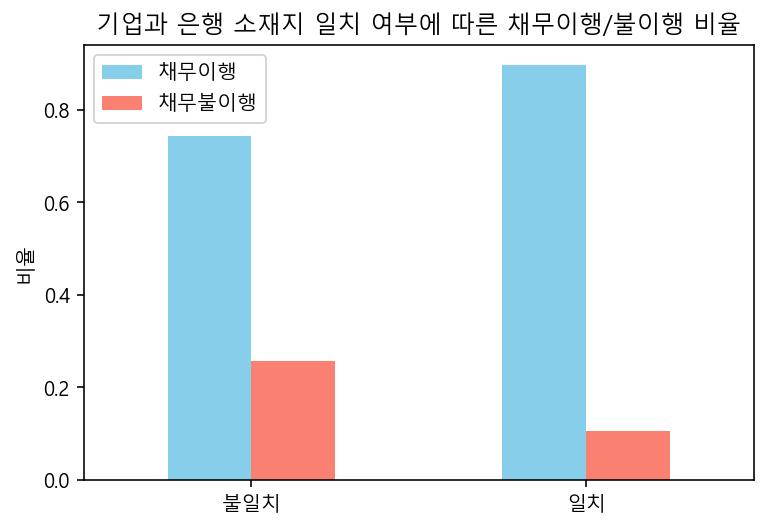

In [169]:
# 막대그래프로 시각화
plt.figure(figsize=(15, 8))
tmp.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])

# 그래프 제목과 축 라벨 설정
plt.xlabel('')
plt.ylabel('비율')
plt.title('기업과 은행 소재지 일치 여부에 따른 채무이행/불이행 비율')

# 범례 추가
plt.legend(['채무이행', '채무불이행'], title='')
plt.xticks(rotation=0)
plt.show()

In [170]:
df3['SameState'] = df3['SameState'].replace({'불일치': 0, '일치': 1})

### (9) NAICS : 북미 산업 분류 체계 코드

In [171]:
df3.NAICS

0         451120
1         722410
2         621210
3              0
4              0
           ...  
899159    451120
899160    451130
899161    332321
899162         0
899163         0
Name: NAICS, Length: 890043, dtype: int64

In [172]:
# 어떤 분류 코드가 제일 많은지 확인
df3.NAICS.value_counts()

0         199702
722110     27759
722211     19347
811111     14436
621210     14000
           ...  
315240         1
311311         1
314992         1
212210         1
111336         1
Name: NAICS, Length: 1312, dtype: int64

**=> 분류코드가 0인 경우가 20만개로 전체 데이터의 약 20%을 차지.**

In [173]:
# 분류코드가 0인 경우만 추출
df3[df3.NAICS==0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,Y,NaN,30-Jun-97,35000,0,0,0,35000,28000,1
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,NaN,14-May-97,229000,0,0,0,229000,229000,1
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,...,N,24-Jun-91,22-Jul-80,600000,0,1,208959,600000,499998,0
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,28-Feb-97,1997,...,Y,NaN,30-Apr-97,70000,0,0,0,70000,56000,1
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,28-Feb-97,1997,...,N,NaN,31-May-97,370000,0,0,0,370000,277500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899152,9995403010,D D MUDD,IDAHO FALLS,ID,83405,BANK OF IDAHO,ID,0,27-Feb-97,1997,...,Y,NaN,31-Mar-97,38000,0,0,0,38000,30400,1
899154,9995423005,"LITWIN LIVERY SERVICES, INC.",CAMPBELL,OH,44405,JPMORGAN CHASE BANK NATL ASSOC,IL,0,27-Feb-97,1997,...,N,NaN,30-Sep-97,10000,0,0,0,10000,5000,0
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,...,Y,NaN,30-Jun-97,79000,0,0,0,79000,63200,0
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,Y,8-Mar-00,31-Mar-97,75000,0,1,46383,75000,60000,1


In [174]:
display(df3[df3.NAICS==722110].head())
display(df3[df3.NAICS==811111].head())

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
123,1001116003,ONE BITE JAPANESE GRILL,OVERLAND PARK,KS,66213,VALLEY VIEW STATE BANK,KS,722110,7-Feb-06,2006,...,N,NaN,31-Mar-06,95000,0,0,0,95000,80750,1
224,1001786005,505 MENDOCINO AVENUE,SANTA ROSA,CA,95401,SAFE-BIDCO,CA,722110,7-Feb-06,2006,...,N,5-May-10,31-Mar-06,250000,0,1,234033,250000,187500,1
388,1002926001,O YA LLC,BOSTON,MA,2111,CITIZENS BANK NATL ASSOC,RI,722110,7-Feb-06,2006,...,N,NaN,31-May-06,450000,0,0,0,450000,337500,0
404,1003086000,FAIRNMAR ORIGINAL WHOPPA INC,LYNBROOK,NY,11563,BBCN BANK,CA,722110,7-Feb-06,2006,...,N,2-May-08,28-Feb-06,5000,0,1,4314,5000,4250,0
411,1003136002,THE ORIGINAL ITALIAN PIE,SLIDELL,LA,70458,FIRST A NATL BK. ASSOC,LA,722110,7-Feb-06,2006,...,N,NaN,31-Jul-06,120000,0,0,0,120000,102000,1


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
10,1000134004,COMMERCIAL TRUCKING MAINTENANC,CHARLOTTE,NC,28256,SUNTRUST BANK,GA,811111,28-Feb-97,1997,...,Y,NaN,23-Feb-98,70000,0,0,0,70000,56000,0
70,1000785007,Baltazar Garza,Fresno,CA,93612,WELLS FARGO BANK NATL ASSOC,SD,811111,1-Apr-97,1997,...,N,NaN,31-Aug-02,10000,0,0,0,10000,5000,0
131,1001154001,ALL TUNE & LUBE CENTER #1148,GARDEN GROVE,CA,92644,"READYCAP LENDING, LLC",CA,811111,28-Feb-97,1997,...,N,NaN,31-May-97,95000,0,0,0,95000,76000,1
163,1001344010,AUTOMOTIVE SPECIALTIES,GLEN GARDER,NJ,8826,"TD BANK, NATIONAL ASSOCIATION",NJ,811111,28-Feb-97,1997,...,N,NaN,30-Jun-97,700000,0,0,0,700000,525000,1
355,1002666006,"AGN COMPANY, LLC.",ROCK HILL,SC,29732,FIRST BANK,MO,811111,7-Feb-06,2006,...,N,26-Mar-12,31-Mar-06,126353,0,1,116869,149000,126650,0


- 0이 가장 많은데, 분류가 아직 안된 것 같음 (1차 전처리 과정에서 산업 분류를 다시 할 필요가 있어보임!)
- 다음으로 많은 것은 72로 시작하는 숙박시설 및 음식점, 81로 시작하는 기타 서비스(공공서비스 제외)이다.
- <span style="color:Blue">산업코드 기준으로 State가 가장 높은 걸 구하고, 그 값으로 대체(ex. 제조업이 가장 높은 State가 DC라면 DC인 행의 NAICS를 제조업으로 채우기)</span>

### NAICS==0인 경우 처리하기

In [175]:
# df3 데이터프레임에서 NAICS 열의 값이 한 자리 숫자이면서 0이 아닌 행 필터링
filtered_df = df3[df3['NAICS'].astype(str).str.len() == 1] #한자리인 경우
filtered_df = filtered_df[filtered_df['NAICS'] != 0] #0이 아닌 경우

# 결과 출력
filtered_df

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState


=> 한자리 숫자이면서 0인 경우 없음 -> 0 을 제외하고 똑바로 재분류 가능

In [176]:
# 선행연구 기반 재분류
# NAICS 열의 값을 변경하는 함수 정의
def update_naics(naics):
    if naics.startswith('72'):
        return '01'
    elif naics.startswith('56'):
        return '02'
    elif naics.startswith('11'):
        return '03'
    elif naics.startswith('71'):
        return '04'
    elif naics.startswith('23'):
        return '05'
    elif naics.startswith('61'):
        return '06'
    elif naics.startswith('52'):
        return '07'
    elif naics.startswith('62'):
        return '08'
    elif naics.startswith('51'):
        return '09'
    elif naics.startswith('31') or naics.startswith('32') or naics.startswith('33'):
        return '10'
    elif naics.startswith('55'):
        return '11'
    elif naics.startswith('21'):
        return '12'
    elif naics.startswith('81'):
        return '13'
    elif naics.startswith('54'):
        return '14'
    elif naics.startswith('92'):
        return '15'
    elif naics.startswith('53'):
        return '16'
    elif naics.startswith('44') or naics.startswith('45'):
        return '17'
    elif naics.startswith('48') or naics.startswith('49'):
        return '18'
    elif naics.startswith('20') or naics.startswith('22'):
        return '19'
    elif naics.startswith('42'):
        return '20'
    else:
        return naics

# NAICS 열의 값을 변경
df3['NAICS'] = df3['NAICS'].astype(str).apply(update_naics)

# 결과 출력
print(df3)

        LoanNr_ChkDgt                            Name             City State  \
0          1000014003                  ABC HOBBYCRAFT       EVANSVILLE    IN   
1          1000024006     LANDMARK BAR & GRILLE (THE)        NEW PARIS    IN   
2          1000034009           WHITLOCK DDS, TODD M.      BLOOMINGTON    IN   
3          1000044001   BIG BUCKS PAWN & JEWELRY, LLC     BROKEN ARROW    OK   
4          1000054004     ANASTASIA CONFECTIONS, INC.          ORLANDO    FL   
...               ...                             ...              ...   ...   
899159     9995573004                    FABRIC FARMS  UPPER ARLINGTON    OH   
899160     9995603000                    FABRIC FARMS         COLUMBUS    OH   
899161     9995613003    RADCO MANUFACTURING CO.,INC.      SANTA MARIA    CA   
899162     9995973006           MARUTAMA HAWAII, INC.         HONOLULU    HI   
899163     9996003010  PACIFIC TRADEWINDS FAN & LIGHT           KAILUA    HI   

          Zip                          

In [177]:
df3.NAICS

0         17
1         01
2         08
3          0
4          0
          ..
899159    17
899160    17
899161    10
899162     0
899163     0
Name: NAICS, Length: 890043, dtype: object

In [178]:
# 'NAICS' 열의 값들의 빈도수 계산
naics_distribution = df3['NAICS'].value_counts()

# 결과 출력
print(naics_distribution)

0     199702
17    125930
13     71913
10     67516
14     67298
01     67136
05     65969
08     54970
20     48359
02     32208
18     22159
04     14520
16     13462
09     11226
07      9398
03      8954
06      6342
12      1837
19       661
11       256
15       227
Name: NAICS, dtype: int64


- 00 : 결측치
- 01 : 숙박 및 요식업
- 02 : 폐기물 관리업
- 03 : 농, 임, 어업
- 04 : 엔터테인먼트
- 05 : 건설업
- 06 : 교육 서비스
- 07 : 재무 및 보험
- 08 : 의료
- 09 : 정보산업
- 10 : 제조업
- 11 : 메니지먼트
- 12 : 광업
- 13 : 기타 서비스
- 14 : 과학 및 전문산업
- 15 : 행정
- 16 : 부동산업
- 17 : 소매업
- 18 : 운송업
- 19 : 공익사업
- 20 : 도매업

In [179]:
# 각 지역에서 가장 많이 나타나는 NAICS 코드 찾기
most_common_naics_by_state = df3.groupby('State')['NAICS'].agg(lambda x: x.value_counts().index[0])

# 결과 출력
print(most_common_naics_by_state)

State
AK     0
AL     0
AR     0
AZ     0
CA     0
CO     0
CT     0
DC    14
DE     0
FL     0
GA     0
HI     0
IA     0
ID     0
IL     0
IN     0
KS     0
KY     0
LA     0
MA     0
MD     0
ME     0
MI     0
MN     0
MO     0
MS    03
MT     0
NC     0
ND     0
NE     0
NH     0
NJ     0
NM     0
NV     0
NY     0
OH     0
OK     0
OR     0
PA     0
RI     0
SC     0
SD     0
TN     0
TX     0
UT     0
VA     0
VT     0
WA     0
WI     0
WV     0
WY     0
Name: NAICS, dtype: object


=> 0이 제일 많이 나옴.

In [180]:
# NAICS 값이 0인 행을 제외한 후 각 지역에서 가장 많이 나타나는 NAICS 코드 찾기
most_common_naics_by_state = df3[df3['NAICS'] != '0'].groupby('State')['NAICS'].agg(lambda x: x.value_counts().index[0])

# 결과 출력
print(most_common_naics_by_state)

State
AK    17
AL    17
AR    17
AZ    17
CA    17
CO    17
CT    17
DC    14
DE    17
FL    17
GA    17
HI    17
IA    17
ID    17
IL    17
IN    17
KS    17
KY    17
LA    17
MA    17
MD    17
ME    17
MI    17
MN    17
MO    17
MS    03
MT    17
NC    17
ND    17
NE    17
NH    17
NJ    17
NM    17
NV    17
NY    17
OH    17
OK    17
OR    17
PA    17
RI    17
SC    17
SD    17
TN    17
TX    17
UT    17
VA    17
VT    17
WA    17
WI    17
WV    17
WY    17
Name: NAICS, dtype: object


- 0을 제외하지 않으면 주별로 가장 많이 나타나는 산업이 0이고, 0을 제외하면 17이 되어버림
- 따라서 최빈값으로 결측치를 대체하는 게 큰 의미가 없음. (0이 거의 다 17로 대체되므로)
- 따라서 지역별 0 제외 비율을 맞춰서 0을 변경해봄

In [181]:
# NAICS 값이 0인 행을 제외한 후 각 State에 대해 NAICS 코드의 비율을 계산
naics_distribution_by_state = df3[df3['NAICS'] != '0'].groupby('State')['NAICS'].value_counts(normalize=True)

# 각 State에서 NAICS 값이 0인 행에 대해 비율에 따라 대체 NAICS 코드로 변경
for state, naics_distribution in naics_distribution_by_state.groupby(level=0):
    zero_indices = df3[(df3['State'] == state) & (df3['NAICS'] == '0')].index
    if len(zero_indices) > 0:
        replacements = naics_distribution.index.get_level_values(1).tolist()
        probabilities = naics_distribution.tolist()
        replacement_naics = np.random.choice(replacements, size=len(zero_indices), p=probabilities)

        # 0을 대체하는 부분 추가
        for idx, new_naics in zip(zero_indices, replacement_naics):
            df3.at[idx, 'NAICS'] = new_naics

# 결과 출력
display(df3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,28-Feb-97,1997,...,Y,NaN,28-Feb-99,60000,0,0,0,60000,48000,0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,01,28-Feb-97,1997,...,Y,NaN,31-May-97,40000,0,0,0,40000,32000,1
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,08,28-Feb-97,1997,...,N,NaN,31-Dec-97,287000,0,0,0,287000,215250,1
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,01,28-Feb-97,1997,...,Y,NaN,30-Jun-97,35000,0,0,0,35000,28000,1
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,28-Feb-97,1997,...,N,NaN,14-May-97,229000,0,0,0,229000,229000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,27-Feb-97,1997,...,N,NaN,30-Sep-97,70000,0,0,0,70000,56000,0
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,27-Feb-97,1997,...,N,NaN,31-Oct-97,85000,0,0,0,85000,42500,0
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,27-Feb-97,1997,...,N,NaN,30-Sep-97,300000,0,0,0,300000,225000,1
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,01,27-Feb-97,1997,...,Y,8-Mar-00,31-Mar-97,75000,0,1,46383,75000,60000,1


In [182]:
# 각 지역에서 NAICS 코드의 빈도수 계산
naics_distribution_by_state = df3[df3['NAICS'] != '0'].groupby('State')['NAICS'].value_counts()

# 결과 출력
print(naics_distribution_by_state)

State  NAICS
AK     17       570
       01       269
       05       245
       08       224
       03       208
               ... 
WY     16        42
       09        33
       19        15
       07         8
       06         5
Name: NAICS, Length: 993, dtype: int64


In [183]:
# 산업(NAICS 코드)별 주(State)별 빈도수 계산
state_naics_distribution = df3[df3['NAICS'] != '0'].groupby('NAICS')['State'].value_counts()

# 결과 출력
print(state_naics_distribution)

NAICS  State
01     CA       11376
       TX        6754
       NY        5423
       PA        3909
       OH        3585
                ...  
20     WV         150
       DE         132
       WY          87
       AK          70
       DC          55
Name: State, Length: 993, dtype: int64


In [184]:
# 'NAICS' 열의 값들의 빈도수 계산
naics_distribution = df3['NAICS'].value_counts()

# 결과 출력
print(naics_distribution)

17    162985
13     92921
10     86777
01     86531
14     86389
05     85137
08     70867
20     61898
02     41405
18     28539
04     18737
16     17380
09     14429
07     12017
03     11989
06      8108
12      2472
19       875
11       309
15       278
Name: NAICS, dtype: int64


In [185]:
naics_zero_rows = df3[df3['NAICS'] == '0']
naics_zero_rows[['State','NAICS']]

,State,NAICS


### NAICS에 따른 MIS_Status 비율 확인

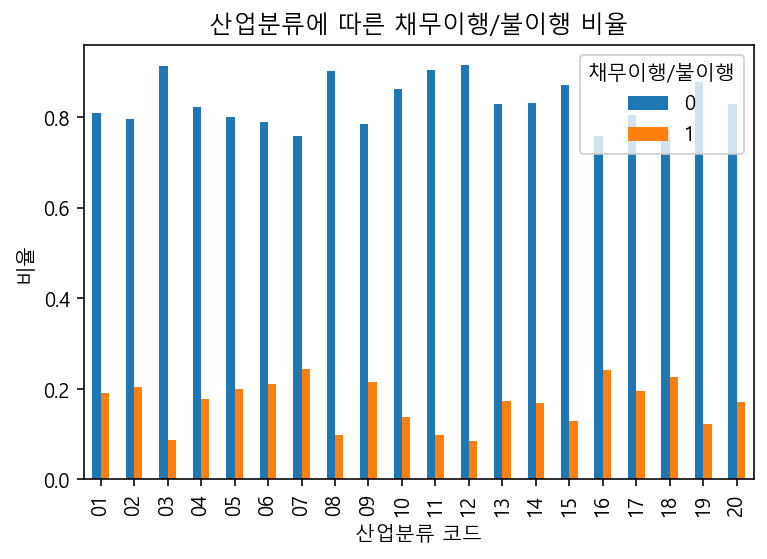

In [186]:
# NAICS 변수에 따른 MIS_Status 비율 계산
naics_mis_ratio = df3.groupby('NAICS')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
naics_mis_ratio.plot(kind='bar', stacked=False)
plt.xlabel('산업분류 코드')
plt.ylabel('비율')
plt.title('산업분류에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 모든 산업군에서 채무이행 비율은 약 0.7% 이상인 것으로 나타났다.
- 채무 불이행 비율이 높은 곳은 재무 및 보험(07), 부동산업(16), 운송업(18)인 것으로 나타났다.
- 채무 불이행 비율이 가장 낮은 곳은 농, 임, 어업(03)이었다.

## (10) ApprovalDate : SBA 약정 발행 날짜

In [187]:
df3.ApprovalDate

0         28-Feb-97
1         28-Feb-97
2         28-Feb-97
3         28-Feb-97
4         28-Feb-97
            ...    
899159    27-Feb-97
899160    27-Feb-97
899161    27-Feb-97
899162    27-Feb-97
899163    27-Feb-97
Name: ApprovalDate, Length: 890043, dtype: object

In [188]:
# 일별로 쪼개보기
# ApprovalDate 변수를 datetime 형식으로 변환
df3['ApprovalDate'] = pd.to_datetime(df3['ApprovalDate'], format='%d-%b-%y')
df3['ApprovalDate'].dt.day.value_counts().sort_index()

1     23425
2     26766
3     26810
4     25828
5     26684
6     28818
7     30291
8     29462
9     30130
10    28986
11    26634
12    29725
13    29091
14    30237
15    28833
16    29814
17    28950
18    29798
19    29637
20    29723
21    30239
22    29943
23    30133
24    29894
25    28326
26    29016
27    30667
28    31420
29    30058
30    32445
31    18260
Name: ApprovalDate, dtype: int64

=> 모든 day에 대해 비슷한 빈도를 보이므로 특정 day에만 발행해주는 게 아니라는 것을 확인할 수 있음.

In [189]:
# 월별로 쪼개보기
df3['Month'] = df3['ApprovalDate'].dt.month

# 월별 빈도 분석
df3['Month'].value_counts().sort_index()

1     66333
2     65624
3     82828
4     79417
5     76469
6     77541
7     75691
8     78024
9     82168
10    69014
11    67690
12    69244
Name: Month, dtype: int64

=> 모든 month에 대해 대체적으로 비슷한 빈도를 보이지만 3월과 9월이 다른 month에 비해 빈도 수가 많음.

In [190]:
# 연도별로 쪼개보기
df3['Year'] = df3['ApprovalDate'].dt.year

# 연도별 빈도 분석
df3['Year'].value_counts().sort_values(ascending=False)

2006    76131
2005    73756
2004    70503
2007    66002
2003    61655
2002    47195
1995    41598
1996    40655
2001    38248
1997    37643
1999    37608
1994    36819
2000    36702
1998    35702
2008    30503
1993    24849
1992    20870
2009    19597
2010    16722
1991    16231
1990    14689
1989    13229
2011     9648
2012     5045
1988     4208
1986     2127
1987     2070
1984     1914
1985     1904
1983     1751
2013     1730
1982      800
1981      502
1980      457
1979      287
1978      227
2014      128
1977      108
1976       66
1975       38
1973       35
1972       34
1974       25
1970       17
1971       10
1969        3
2068        2
Name: Year, dtype: int64

- 2000년대 초중반(글로벌금융위기 직전)에 SBA 약정이 발행된 경우가 가장 많았음.
- 2068은 이상치인 것 같다. => 제거하기

In [191]:
df3 = df3[df3['Year'] != 2068]
df3.Year.value_counts()

2006    76131
2005    73756
2004    70503
2007    66002
2003    61655
2002    47195
1995    41598
1996    40655
2001    38248
1997    37643
1999    37608
1994    36819
2000    36702
1998    35702
2008    30503
1993    24849
1992    20870
2009    19597
2010    16722
1991    16231
1990    14689
1989    13229
2011     9648
2012     5045
1988     4208
1986     2127
1987     2070
1984     1914
1985     1904
1983     1751
2013     1730
1982      800
1981      502
1980      457
1979      287
1978      227
2014      128
1977      108
1976       66
1975       38
1973       35
1972       34
1974       25
1970       17
1971       10
1969        3
Name: Year, dtype: int64

<span style="color:Blue">파생변수 생성(Recession)</span>
- 글로벌 금융위기에 해당하면 1, 해당하지 않으면 0의 값을 가지는 파생변수 생성하기

In [192]:
df3['Recession'] = (df3['ApprovalDate'].dt.year.between(2007, 2009)) & (df3['ApprovalDate'].dt.month.between(12, 12) | df3['ApprovalDate'].dt.year.between(2008, 2009) & df3['ApprovalDate'].dt.month.between(1, 6)).astype(int)

In [193]:
df3.Recession = df3.Recession.astype(int)

In [194]:
df3.Recession.value_counts()

0    854481
1     35560
Name: Recession, dtype: int64

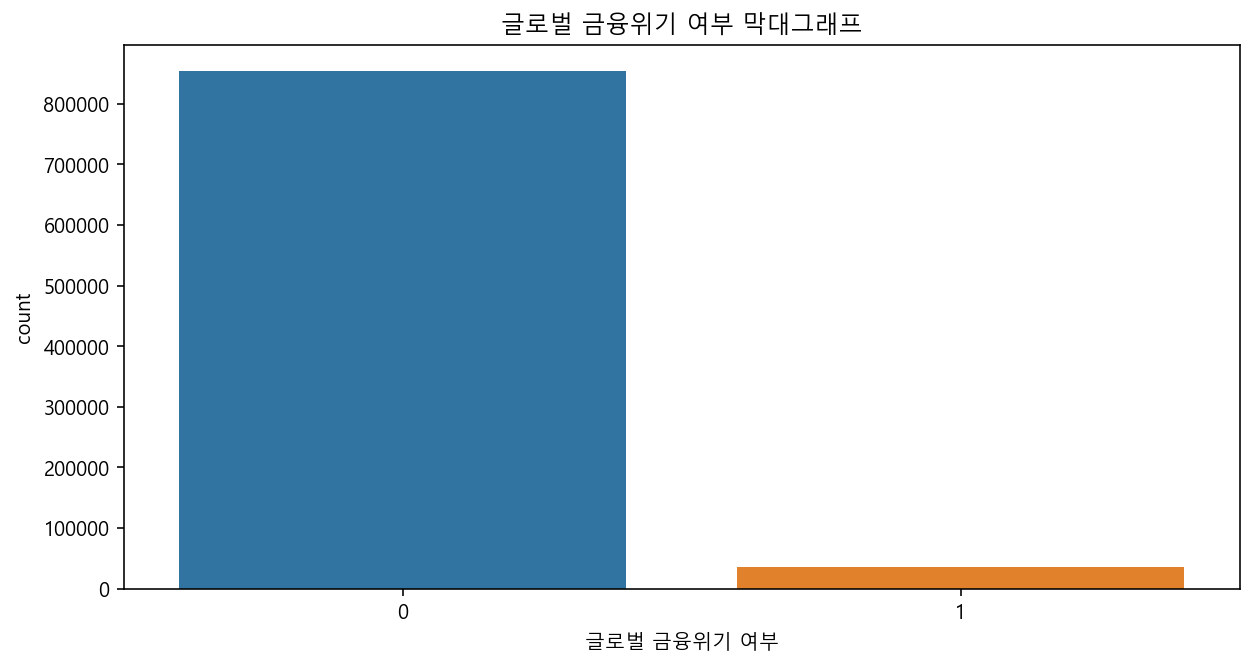

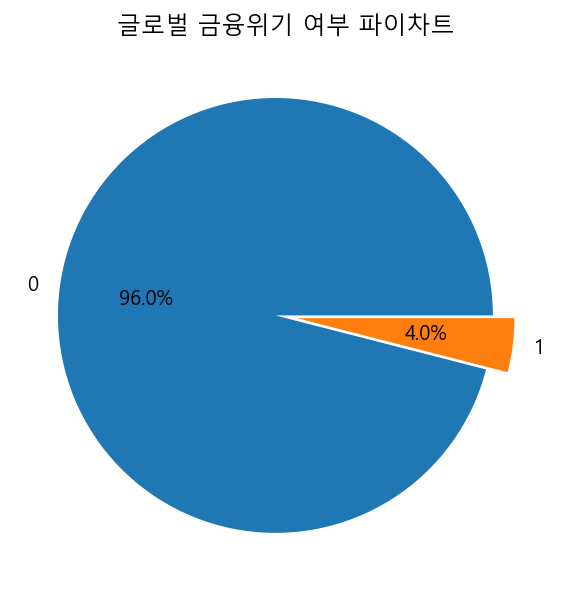

In [195]:
# 분포 확인하기
# 막대그래프
plt.figure(figsize=(10, 5))
sns.countplot(x='Recession', data=df3)
plt.title('글로벌 금융위기 여부 막대그래프')
plt.xlabel('글로벌 금융위기 여부')
plt.show()

# 파이차트
plt.figure(figsize=(10, 5))
df3['Recession'].value_counts().plot.pie(explode=[0.05, 0.05], autopct='%.1f%%')
plt.title('글로벌 금융위기 여부 파이차트')
plt.ylabel('')
plt.show()

### Recession에 따른 MIS_Status 비율 확인

In [197]:
df3['Recession'] = df3['Recession'].replace({0: '그외', 1: '금융위기'})

In [198]:
# Recession 변수에 따른 MIS_Status 비율 계산
recession_mis_ratio = df3.groupby('Recession')['MIS_Status'].value_counts(normalize=True).unstack()
recession_mis_ratio

MIS_Status,0,1
Recession,,
그외,0.830773,0.169227
금융위기,0.656918,0.343082


In [199]:
tmp = pd.DataFrame(recession_mis_ratio)
tmp

MIS_Status,0,1
Recession,,
그외,0.830773,0.169227
금융위기,0.656918,0.343082


<Figure size 1080x576 with 0 Axes>

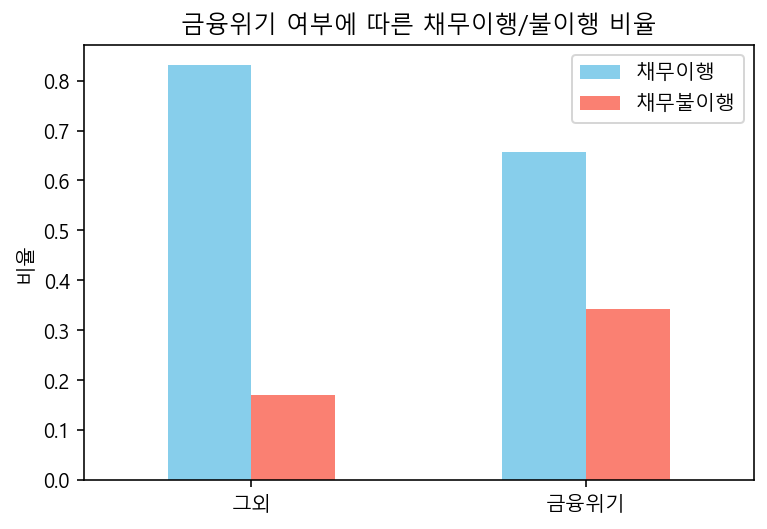

In [200]:
# 막대그래프로 시각화
plt.figure(figsize=(15, 8))
tmp.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])

# 그래프 제목과 축 라벨 설정
plt.xlabel('')
plt.ylabel('비율')
plt.title('금융위기 여부에 따른 채무이행/불이행 비율')

# 범례 추가
plt.legend(['채무이행', '채무불이행'], title='')
plt.xticks(rotation=0)
plt.show()

- 예상했던 대로 금융위기 시기에는 채무 불이행 비율이 그렇지 않은 시기보다 높게 나타났다.
- 또한 채무 이행 비율도 금융위기 시기에 낮아졌다. 

In [ ]:
df3['Recession'] = df3['Recession'].replace({'그외': 0, '금융위기':1})

## (11) ApprovalFY : 약정 회계 연도

In [201]:
df3.ApprovalFY

0         1997
1         1997
2         1997
3         1997
4         1997
          ... 
899159    1997
899160    1997
899161    1997
899162    1997
899163    1997
Name: ApprovalFY, Length: 890041, dtype: object

In [202]:
# SBA 약정 발행 연도와 다른 행이 있는지 확인
df3['ApprovalFY'] = df3['ApprovalFY'].astype(int) #데이터 유형 통일
df3[df3['Year'] != df3['ApprovalFY']]

ValueError: invalid literal for int() with base 10: '1976A'

In [203]:
# 회계연도에 1976A와 같이 문자형이 있는 것 같아 확인
df3[df3['ApprovalFY'].str.contains('[A-Za-z]')]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Month,Year,Recession
699732,7268591001,FASHION NOVELTY CORP OF NJ,CARLSTADT,NJ,7072,VALLEY NATIONAL BANK,NJ,08,1976-09-29,1976A,...,350000,0,1,48361,350000,315000,1,9,1976,그외
704030,7319361003,J W HUGHES HUGHES 66 GLDN PLNS,FOLLETT,TX,79034,FIRSTBANK SOUTHWEST,TX,02,1976-09-17,1976A,...,325000,0,1,45910,325000,292500,1,9,1976,그외
710381,7389331000,BAUMAN'S APPLIANCE,ODESSA,NY,14869,CHEMUNG CANAL TRUST COMPANY,NY,10,1976-07-19,1976A,...,15000,0,1,475,15000,13500,1,7,1976,그외
713245,7420741004,THE TOGGERY,SPRINGFIELD,MA,1103,BANK OF AMERICA NATL ASSOC,RI,16,1976-08-30,1976A,...,73000,0,1,827,73000,40150,0,8,1976,그외
748029,7799101004,"JUSTIN TYME,INC.",COLUMBUS,OH,43265,"PNC BANK, NATIONAL ASSOCIATION",OH,20,1976-08-20,1976A,...,150000,0,1,87037,150000,135000,1,8,1976,그외
751519,7848911008,MICHAELS TRUCK STOP,CHICAGO,IL,60633,BANK OF AMERICA NATL ASSOC,NC,14,1976-09-29,1976A,...,550000,0,1,572877,550000,495000,0,9,1976,그외
769515,8108191005,MIKE ESPARZA FUNERAL HOME,UVALDE,TX,78801,BANK OF AMERICA NATL ASSOC,TX,13,1976-07-19,1976A,...,85000,0,1,63850,85000,76500,1,7,1976,그외
775002,8191291000,JUG & JIGGER,YUCAIPA,CA,92399,BANK OF AMERICA NATL ASSOC,CA,17,1976-08-20,1976A,...,94500,0,1,63182,94500,85050,1,8,1976,그외
775978,8204371000,AUTOMOTIVE ELECTRIC REBUILDERS,FAIRBANKS,AK,99701,KEYBANK NATIONAL ASSOCIATION,OR,03,1976-09-01,1976A,...,164679,0,1,439,165000,148500,0,9,1976,그외
780120,8260831001,"WALKER-NEER MANUFACTURING CO.,",WICHITA FALLS,TX,76307,BANK OF AMERICA NATL ASSOC,TX,08,1976-07-29,1976A,...,650000,0,1,253484,750000,499500,1,7,1976,그외


=> 1976A를 1976으로 바꿔도 되지 않을까?

In [204]:
df3['ApprovalFY'] = df3['ApprovalFY'].replace('1976A', '1976')

In [205]:
# SBA 약정 발행 연도와 다른 행이 있는지 확인
df3['ApprovalFY'] = df3['ApprovalFY'].astype(int) #데이터 유형 통일
df3[df3['Year'] != df3['ApprovalFY']]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Month,Year,Recession
44,1000655003,Sun Service Center,Newburgh,NY,12550,WELLS FARGO BANK NATL ASSOC,SD,18,1996-10-04,1997,...,25000,0,0,0,25000,12500,0,10,1996,그외
222,1001775006,Independent Computer Services,Watertown (Town of),MA,2172,BANK OF AMERICA NATL ASSOC,RI,14,1997-10-09,1998,...,10000,0,0,0,10000,5000,0,10,1997,그외
223,1001785009,West Reading Used Furniture,West Reading,PA,19611,WELLS FARGO BANK NATL ASSOC,PA,14,1997-10-10,1998,...,20000,0,0,0,20000,10000,1,10,1997,그외
226,1001795001,"Real Time Executives, Inc.",Wrentham (census name Wrentham,MA,2093,BANK OF AMERICA NATL ASSOC,RI,14,1997-10-10,1998,...,25000,0,0,0,25000,12500,0,10,1997,그외
227,1001805002,Tola Painting,Hartford,CT,6114,BANK OF AMERICA NATL ASSOC,RI,05,1997-10-14,1998,...,10000,0,0,0,10000,5000,0,10,1997,그외
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893534,9874313000,THE MONROVIAN FAMILY RESTAURAN,MONROVIA,CA,92407,CITIZENS BUSINESS BANK,CA,20,1996-12-31,1997,...,400000,0,0,0,400000,256000,1,12,1996,그외
893535,9874323003,THE MONROVIAN FAMILY RESTAURAN,MONROVIA,CA,91016,CITIZENS BUSINESS BANK,CA,17,1996-12-31,1997,...,215000,0,0,0,215000,161250,1,12,1996,그외
893537,9874343009,"DAIZEN, INC.",KAMUELA,HI,96743,FIRST HAWAIIAN BANK,HI,13,1996-12-31,1997,...,46000,0,0,0,46000,36800,1,12,1996,그외
898351,9978031001,ONE STOP SUPPLY,WARWICK,RI,2888,OCEAN ST. BUS. DEVEL AUTHORITY,RI,08,1981-10-19,1982,...,135000,0,0,0,135000,135000,1,10,1981,그외


=> 회계연도와 SBA 약정 발행 연도가 다른 경우 약 2만 7천 건 존재.(크게 중요해보이진 않음.)

In [206]:
# Month와 Year 변수 삭제
df3.drop(columns=['Month', 'Year'], inplace=True)

## (12) NewExist : 1 = 기존 비즈니스, 2 = 신규 비즈니스

In [207]:
df3.NewExist

0         2.0
1         2.0
2         1.0
3         1.0
4         1.0
         ... 
899159    1.0
899160    1.0
899161    1.0
899162    1.0
899163    2.0
Name: NewExist, Length: 890041, dtype: float64

In [208]:
df3.NewExist.value_counts()

1.0    638590
2.0    250300
0.0      1017
Name: NewExist, dtype: int64

**=> 0은 무엇을 의미?**

In [209]:
# 예전 데이터라 기존 비즈니스인지, 신규인지 알 수 없는 경우인가?
df3[df3.NewExist == 0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession
142,1001235008,"NEW ENGLAND PAINT & SUPPLY, IN",READING (TOWN OF),MA,1867,DANVERSBANK,MA,14,1997-05-21,1997,...,NaN,31-Mar-99,100000,0,0,0,100000,50000,1,그외
170,1001385007,Mill City Club,Lawrence,MA,1841,BANK OF AMERICA NATL ASSOC,NC,01,1997-06-16,1997,...,NaN,30-Nov-97,70000,0,0,0,70000,35000,0,그외
185,1001485002,"LBC BILLING, LLC",PROVIDENCE,RI,2908,BANK OF AMERICA NATL ASSOC,NC,09,1997-07-02,1997,...,NaN,30-Apr-99,10000,0,0,0,10000,5000,0,그외
211,1001685003,Comprehensive Psychiatric Asso,Weston (Town of),MA,2193,BANK OF AMERICA NATL ASSOC,NC,18,1997-09-19,1997,...,NaN,30-Nov-97,100000,0,0,0,100000,50000,0,그외
223,1001785009,West Reading Used Furniture,West Reading,PA,19611,WELLS FARGO BANK NATL ASSOC,PA,14,1997-10-10,1998,...,NaN,30-Apr-98,20000,0,0,0,20000,10000,1,그외
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895872,9923063005,"VAN-JONES HARDWOOD CO., INC",CRYSTAL SPRING,PA,15536,FARMERS & MERCHANTS TR CO,PA,20,1997-01-27,1997,...,NaN,28-Feb-97,250000,0,0,0,250000,225000,1,그외
895976,9925253007,"ACO ENTERPRISES, INC.",SALT LAKE CITY,UT,84050,WELLS FARGO BANK NATL ASSOC,SD,10,1997-01-28,1997,...,NaN,28-Feb-97,50000,0,0,0,50000,45000,0,그외
896382,9933633003,"FIRST CLASS TAN, INC.",HOT SPRINGS,AR,71913,BANK OF AMERICA NATL ASSOC,AR,02,1997-01-30,1997,...,NaN,28-Feb-97,18700,0,0,0,23000,18400,1,그외
896633,9939223010,BO SHANNON GRAPHIC PRODUCTION,LEE'S SUMMIT,MO,64064,COUNTRY CLUB BANK,KS,05,1997-02-03,1997,...,NaN,30-Jun-97,60000,0,0,0,60000,48000,0,그외


In [210]:
# NA 확인
df3[df3['NewExist'].isna()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession
395231,3808405000,J.W.Chipping Corp,BETHLEHEM,NH,3574,FIRST COLEBROOK BANK,NH,20,2009-12-15,2010,...,NaN,15-Dec-09,117000,0,0,0,117000,99450,1,금융위기
399884,3854945010,D & R Foods Inc.,INDIANOLA,MS,38751,TRUSTMARK NATIONAL BANK,MS,17,2010-01-13,2010,...,NaN,1-Feb-10,150000,0,0,0,150000,135000,1,그외
400052,3856405005,"Luna Design Group, Inc.",LYNNFIELD,MA,1940,PEOPLE'S UNITED BANK,CT,14,2010-01-14,2010,...,NaN,25-Mar-10,25000,0,0,0,25000,25000,0,그외
400203,3857955008,Lisbon Market Inc,LISBON,OH,44432,THE CITIZENS SAVINGS BANK,OH,17,2010-01-15,2010,...,NaN,15-Jan-10,350000,0,0,0,350000,175000,1,그외
400300,3858915009,"George F. Gales, Jr. MD",QUINCY,MA,2170,EASTERN BANK,MA,08,2010-01-15,2010,...,NaN,1-Apr-10,52395,0,0,0,50000,25000,1,그외
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470308,4540125002,"GG&M, LLC",GENESEE,ID,83832,ZIONS FIRST NATIONAL BANK,UT,20,2011-02-10,2011,...,28-Feb-13,10-Feb-11,21176,0,1,12842,15000,7500,0,그외
471939,4553585010,"MORGAN VENTURES, INC",COLLINS,MS,39428,COVINGTON COUNTY BANK,MS,01,2011-02-23,2011,...,NaN,23-Feb-11,20500,0,0,0,20500,17425,1,그외
498244,4820745005,Goodcare LLC,DELL RAPIDS,SD,57022,MINNWEST BANK,SD,08,2011-08-12,2011,...,NaN,19-Aug-11,129717,0,0,0,100000,50000,1,그외
512594,4957935004,"912 Enterprises Franchising, I",CRANBERRY TWP,PA,16066,FIRST COMMONWEALTH BANK,PA,10,2011-11-16,2012,...,NaN,16-Nov-11,43000,0,0,0,43000,21500,1,그외


In [211]:
# NewExist 칼럼이 보이지 않으므로 해당 열만 출력
df3.loc[df3['NewExist'].isna(), 'NewExist']

395231   NaN
399884   NaN
400052   NaN
400203   NaN
400300   NaN
          ..
470308   NaN
471939   NaN
498244   NaN
512594   NaN
611835   NaN
Name: NewExist, Length: 134, dtype: float64

=> NewExist가 0인 경우와 결측인 경우는 전체 데이터의 약 0.1%을 차지한다. 따라서 제거해도 무방해보인다.

In [212]:
df3 = df3[(df3['NewExist'] != 0) & (~df3['NewExist'].isna())] #0이 아닌 경우와 na가 아닌 경우만 남기기

In [213]:
df3.shape

(888890, 29)

In [214]:
# 기존 비즈니스(1)과 신규 비즈니스(2)를 각각 0과 1로 재분류
df3['NewExist'] = df3['NewExist'].replace({1: 0, 2: 1})
df3.NewExist.value_counts()

0.0    638590
1.0    250300
Name: NewExist, dtype: int64

In [215]:
# 소수점 제거
df3['NewExist'] = df3['NewExist'].astype(int)
df3.NewExist.value_counts()

0    638590
1    250300
Name: NewExist, dtype: int64

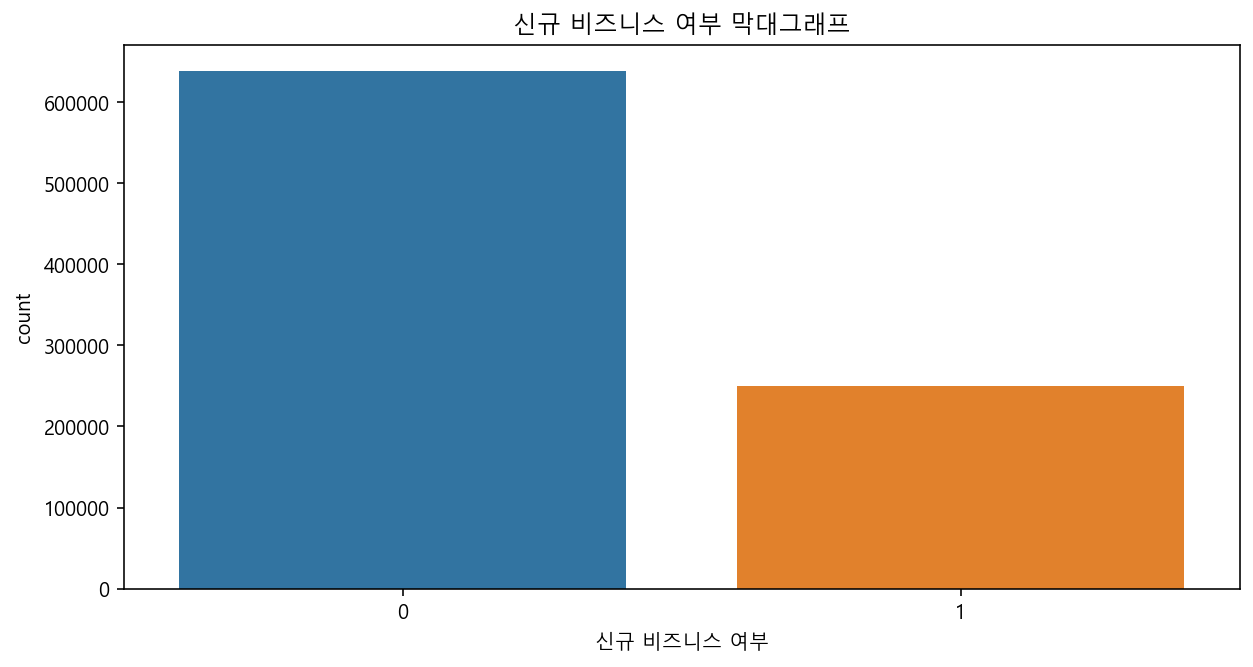

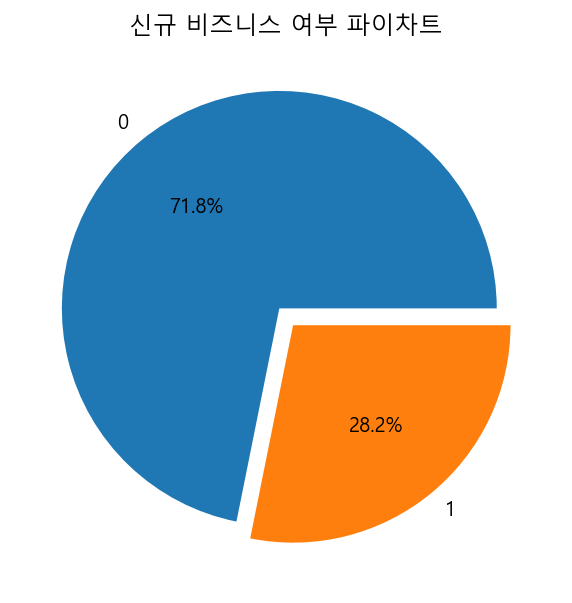

In [216]:
# 분포 확인하기
# 막대그래프
plt.figure(figsize=(10, 5))
sns.countplot(x='NewExist', data=df3)
plt.title('신규 비즈니스 여부 막대그래프')
plt.xlabel('신규 비즈니스 여부')
plt.show()

# 파이차트
plt.figure(figsize=(10, 5))
df3['NewExist'].value_counts().plot.pie(explode=[0.05, 0.05], autopct='%.1f%%')
plt.title('신규 비즈니스 여부 파이차트')
plt.ylabel('')
plt.show()

- 전체 데이터 중 기존 사업이 약 70%, 신규 사업이 약 30% 정도 차지
- 도메인 지식(데이터 설명 자료)을 통해 기존 비즈니스는 2년 이상, 신규 비즈니스는 2년 미만 사업을 의미
- 그렇다면 신규 비즈니스가 기존 비즈니스보다 채무 불이행률이 더 높게 나타나지 않을까?

### NewExist에 따른 MIS_Status 비율 확인하기

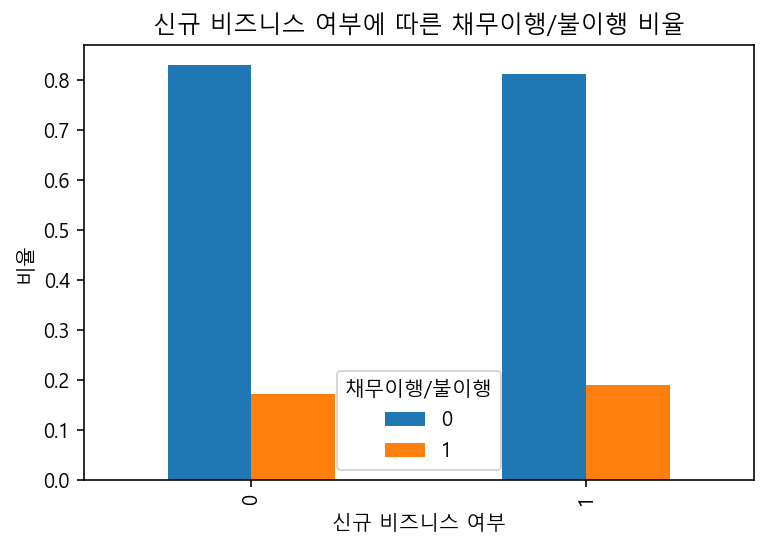

In [217]:
# NewExist 변수에 따른 MIS_Status 비율 계산
newexist_mis_ratio = df3.groupby('NewExist')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
newexist_mis_ratio.plot(kind='bar', stacked=False)
plt.xlabel('신규 비즈니스 여부')
plt.ylabel('비율')
plt.title('신규 비즈니스 여부에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 예상과 달리 신규 비즈니스라고 해서 채무 불이행 비율이 더 높게 나타나지 않았다.
- 기존 비즈니스와 신규 비즈니스 간 채무 이행/불이행 비율의 차이는 뚜렷하게 나타나지 않았다.
- 2년이라는 기준이 채무 이행/불이행에 크게 영향을 주지는 않는 것 같다.

## (13) FranchiseCode : 프랜차이즈 여부

In [218]:
df3.FranchiseCode

0         1
1         1
2         1
3         1
4         1
         ..
899159    1
899160    1
899161    1
899162    1
899163    1
Name: FranchiseCode, Length: 888890, dtype: int64

In [219]:
df3.FranchiseCode.value_counts()

1        632537
0        204944
78760      3357
68020      1910
50564      1026
          ...  
78055         1
21424         1
38608         1
26549         1
10527         1
Name: FranchiseCode, Length: 2756, dtype: int64

=> 캐글 변수 설명에서 0과 1이 프랜차이즈가 아닌 경우이고, 나머지 경우가 프랜차이즈라고 했으므로 0=프랜차이즈 아님, 1=프랜차이즈로 재분류

In [220]:
# Franchisecode 열에서 0과 1은 0으로, 그 이외의 숫자는 1으로 재분류
df3['FranchiseCode'] = df3['FranchiseCode'].apply(lambda x: 0 if x in [0, 1] else 1)

In [221]:
df3.FranchiseCode.value_counts()

0    837481
1     51409
Name: FranchiseCode, dtype: int64

### FranchiseCode에 따른 MIS_Status 비율 확인하기

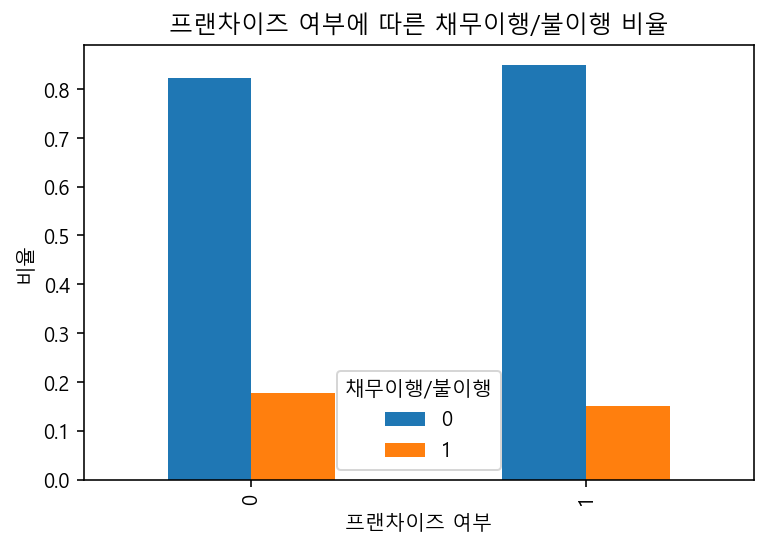

In [222]:
# FranchiseCode 변수에 따른 MIS_Status 비율 계산
FranchiseCode_mis_ratio = df3.groupby('FranchiseCode')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
FranchiseCode_mis_ratio.plot(kind='bar', stacked=False)
plt.xlabel('프랜차이즈 여부')
plt.ylabel('비율')
plt.title('프랜차이즈 여부에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 프랜차이즈가 아닐 때와 프랜차이즈일 때 모두 채무이행/불이행 비율이 비슷하다.
- 프랜차이즈일 때 채무 이행 비율이 살짝 더 높고, 채무불이행 비율이 살짝 더 낮다.
- 프랜차이즈 여부는 채무이행/불이행에 큰 영향을 주는 변수라고 보기 어렵지만, 프랜차이즈인 경우가 채무 이행 확률이 더 높다고는 볼 수 있다.

## (14) UrbanRural : 도시/농촌 여부

In [223]:
df3.UrbanRural

0         0
1         0
2         0
3         0
4         0
         ..
899159    0
899160    0
899161    0
899162    0
899163    0
Name: UrbanRural, Length: 888890, dtype: int64

=> 캐글 변수 설명에 의하면 1=urban, 2=rural, 0=undefined

In [224]:
# 0인 경우만 추출
df3[df3.UrbanRural==0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,NaN,28-Feb-99,60000,0,0,0,60000,48000,0,그외
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,01,1997-02-28,1997,...,NaN,31-May-97,40000,0,0,0,40000,32000,1,그외
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,08,1997-02-28,1997,...,NaN,31-Dec-97,287000,0,0,0,287000,215250,1,그외
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,01,1997-02-28,1997,...,NaN,30-Jun-97,35000,0,0,0,35000,28000,1,그외
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,NaN,14-May-97,229000,0,0,0,229000,229000,1,그외
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,NaN,30-Sep-97,70000,0,0,0,70000,56000,0,그외
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,NaN,31-Oct-97,85000,0,0,0,85000,42500,0,그외
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,NaN,30-Sep-97,300000,0,0,0,300000,225000,1,그외
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,01,1997-02-27,1997,...,8-Mar-00,31-Mar-97,75000,0,1,46383,75000,60000,1,그외


In [225]:
df3.UrbanRural.value_counts()

1    465258
0    319221
2    104411
Name: UrbanRural, dtype: int64

- <span style="color:Red">0을 가지는 경우가 30만개로 많다.</span>
- <span style="color:Red">State나 City 변수를 보고 0을 채워야 하나?</span>
- <span style="color:Blue">미국 인구 수를 기준으로 10위 안에 드는 State인 경우 도시(0), 아닌 경우 시골(1)로 재분류!</span>

#### UrbanRural 결측치 채우기
- 해당 시기에 미국의 인구 수 기준 상위 10개 주 = 도시 
- 도시에 해당하는 주 : 캘리포니아, 텍사스, 뉴욕, 플로리다, 일리노이, 펜실베니아, 오하이오, 미시간, 뉴저지, 조지아
- 'CA', 'TX', 'NY', 'FL', 'IL', 'PA', 'OH', 'MI', 'NJ', 'GA' 에 해당하는 urbanrural 결측치 -> 도시
- 나머지 주에 해당하는 urbanrural 결측치 -> 시골 로 변환

In [226]:
top10_states = ['CA', 'TX', 'NY', 'FL', 'IL', 'PA', 'OH', 'MI', 'NJ', 'GA']

In [227]:
# 'UrbanRural' 열의 결측치를 선택한 10개의 주에 따라 채우기
df3.loc[df3['State'].isin(top10_states), 'UrbanRural'] = 1
df3.loc[~df3['State'].isin(top10_states), 'UrbanRural'] = 2

In [228]:
#결측치 지워졌는지 확인
df3[df3['UrbanRural']==0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession


In [229]:
df3.UrbanRural.value_counts()

1    458608
2    430282
Name: UrbanRural, dtype: int64

In [230]:
# 도시(1)과 농촌(2)를 각각 도시(0)과 농촌(1)로 재분류
df3['UrbanRural'] = df3['UrbanRural'].replace({1: 0, 2: 1})
df3.UrbanRural.value_counts()

0    458608
1    430282
Name: UrbanRural, dtype: int64

### UrbanRural에 따른 MIS_Status 비율 확인

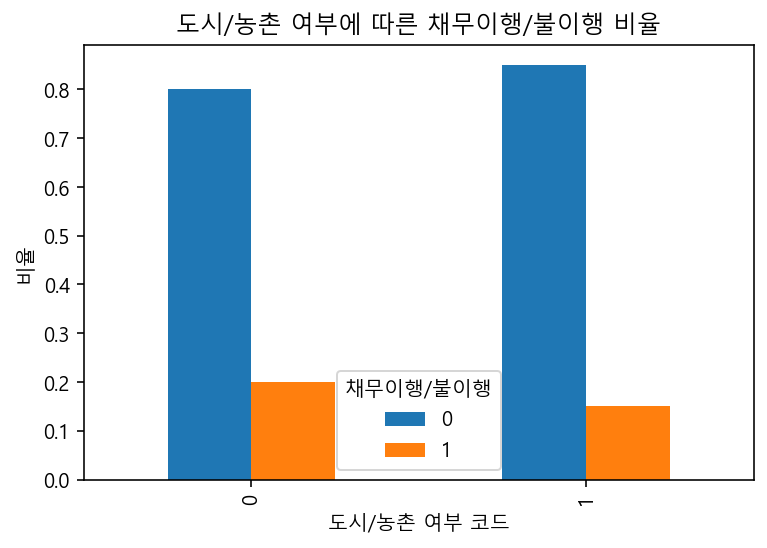

In [231]:
# UrbanRural 변수에 따른 MIS_Status 비율 계산
urbanrural_mis_ratio = df3.groupby('UrbanRural')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
urbanrural_mis_ratio.plot(kind='bar', stacked=False)
plt.xlabel('도시/농촌 여부 코드')
plt.ylabel('비율')
plt.title('도시/농촌 여부에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 대체적으로 도시와 농촌 간에 채무이행/불이행 비율에 큰 차이는 없는 것으로 보인다.
- 그러나 채무이행 비율이 더 높고, 채무불이행 비율이 더 낮은 그룹은 농촌이다.

### (15) RevLineCr : 리볼빙제도 사용 여부

In [232]:
df3.RevLineCr

0         N
1         N
2         N
3         N
4         N
         ..
899159    0
899160    Y
899161    N
899162    N
899163    N
Name: RevLineCr, Length: 888890, dtype: object

In [233]:
df3.RevLineCr.value_counts()

N    414165
0    255958
Y    199222
T     14983
1        22
R        14
`        11
2         6
C         2
5         1
4         1
3         1
.         1
7         1
Q         1
-         1
A         1
,         1
Name: RevLineCr, dtype: int64

- <span style="color:Red">Y랑 N만 있는 게 아님, 특히 0은 Y의 개수보다 많음</span>
- <span style="color:Blue">은행별로 표기가 통일되지 않아 발생한 데이터라 판단, 해당 변수 삭제</span>

In [234]:
df3 = df3.drop(columns=['RevLineCr'])
df3.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'LowDoc',
       'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SameState',
       'Recession'],
      dtype='object')

### (16) LowDoc : SBA 대출프로그램 신청 여부

In [235]:
df3.LowDoc

0         Y
1         Y
2         N
3         Y
4         N
         ..
899159    N
899160    N
899161    N
899162    Y
899163    N
Name: LowDoc, Length: 888890, dtype: object

In [236]:
df3.LowDoc.value_counts()

N    773253
Y    109686
0      1486
C       754
S       591
A       495
R        74
1         1
Name: LowDoc, dtype: int64

- <span style="color:Red">Y랑 N만 있는 게 아님.</span>
- <span style="color:Blue">데이터 설명 자료를 통해 (0,C,S,A,R,1)은 entry error임을 알 수 있었음. 따라서 Y랑 N만 남기고 나머지 값들은 제거.</span>

In [237]:
# Y랑 N 이외에 다른 값을 가진 경우, 해당 행을 제거
df4 = df3[df3['LowDoc'].isin(['Y', 'N'])]

In [238]:
df4

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,NaN,28-Feb-99,60000,0,0,0,60000,48000,0,그외
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,01,1997-02-28,1997,...,NaN,31-May-97,40000,0,0,0,40000,32000,1,그외
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,08,1997-02-28,1997,...,NaN,31-Dec-97,287000,0,0,0,287000,215250,1,그외
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,01,1997-02-28,1997,...,NaN,30-Jun-97,35000,0,0,0,35000,28000,1,그외
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,NaN,14-May-97,229000,0,0,0,229000,229000,1,그외
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,NaN,30-Sep-97,70000,0,0,0,70000,56000,0,그외
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,NaN,31-Oct-97,85000,0,0,0,85000,42500,0,그외
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,NaN,30-Sep-97,300000,0,0,0,300000,225000,1,그외
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,01,1997-02-27,1997,...,8-Mar-00,31-Mar-97,75000,0,1,46383,75000,60000,1,그외


In [239]:
# 0=No, 1=Yes로 재분류
df4['LowDoc'] = df4['LowDoc'].replace({'N': 0, 'Y': 1})
df4.NewExist.value_counts()

0    634975
1    247964
Name: NewExist, dtype: int64

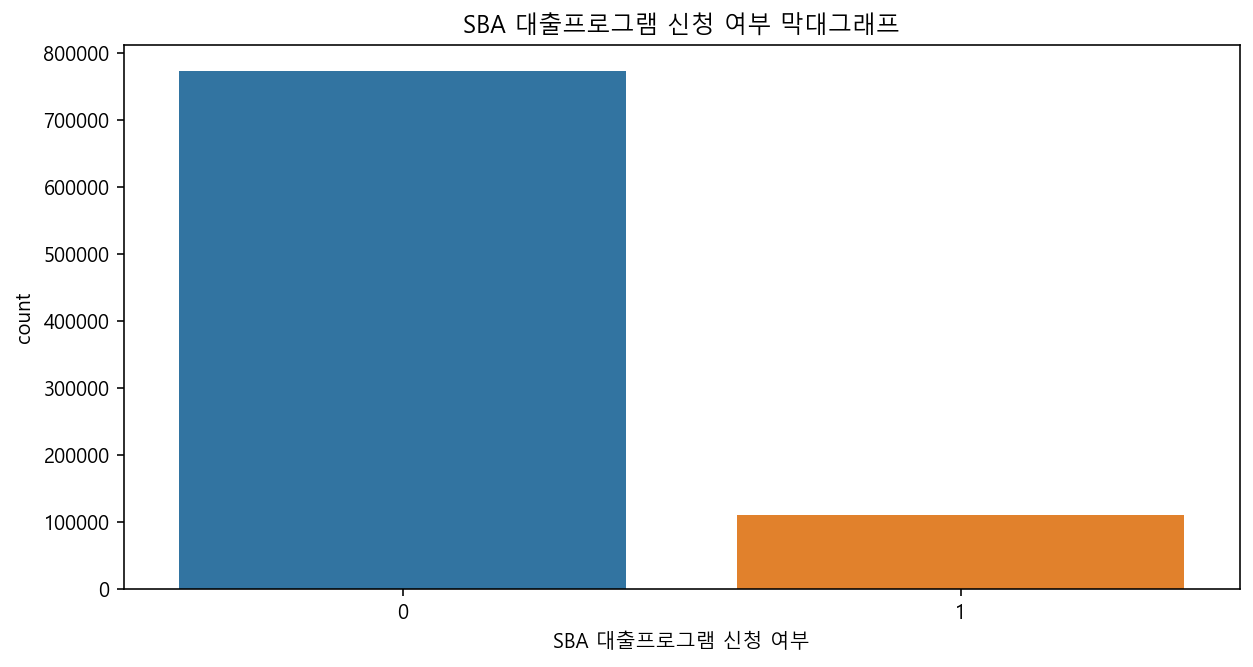

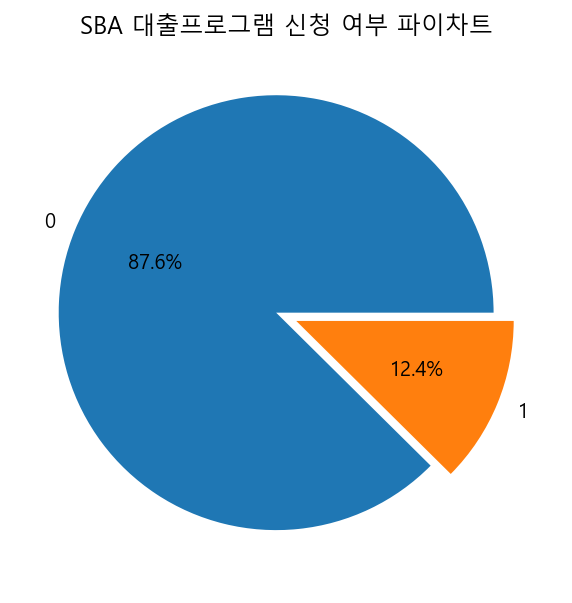

In [240]:
# 분포 확인하기
# 막대그래프
plt.figure(figsize=(10, 5))
sns.countplot(x='LowDoc', data=df4)
plt.title('SBA 대출프로그램 신청 여부 막대그래프')
plt.xlabel('SBA 대출프로그램 신청 여부')
plt.show()

# 파이차트
plt.figure(figsize=(10, 5))
df4['LowDoc'].value_counts().plot.pie(explode=[0.05, 0.05], autopct='%.1f%%')
plt.title('SBA 대출프로그램 신청 여부 파이차트')
plt.ylabel('')
plt.show()

=> SBA 대출프로그램 신청 X : 신청 O = 약 8.5 : 1.5 정도의 비율인 것으로 확인

### LowDoc에 따른 MIS_Status 비율 확인

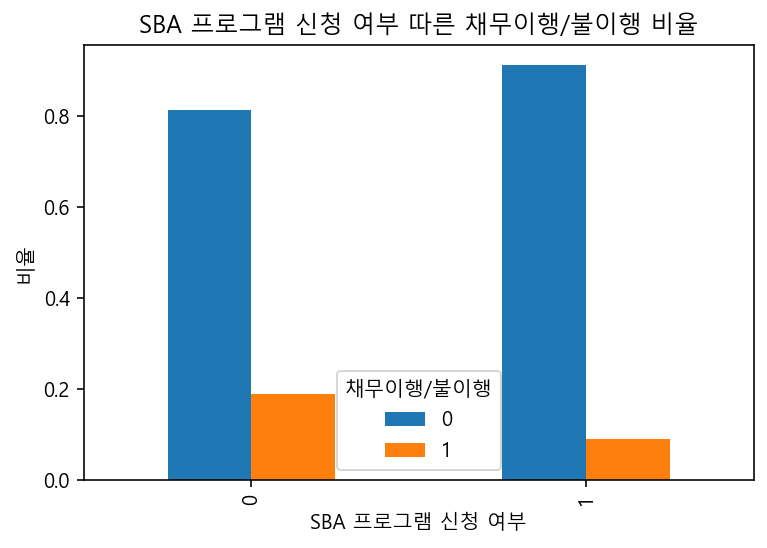

In [241]:
# LowDoc 변수에 따른 MIS_Status 비율 계산
lowdoc_mis_ratio = df4.groupby('LowDoc')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
lowdoc_mis_ratio.plot(kind='bar', stacked=False)
plt.xlabel('SBA 프로그램 신청 여부')
plt.ylabel('비율')
plt.title('SBA 프로그램 신청 여부 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 신청한 기업의 경우 그렇지 않은 기업에 비해 채무 이행 비율이 더 높게 나타났다.
- 신청한 기업의 경우 그렇지 않은 기업에 비해 채무 불이행 비율이 더 낮게 나타났다.
- 따라서 SBA 대출 프로그램을 신청한 기업이 채무를 이행할 확률이 더 높다고 볼 수 있다.

## (17) ChgOffDate : 채무 불이행으로 선언되는 날짜

In [242]:
df4.ChgOffDate

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
899159         NaN
899160         NaN
899161         NaN
899162    8-Mar-00
899163         NaN
Name: ChgOffDate, Length: 882939, dtype: object

In [243]:
df4.ChgOffDate.value_counts()

13-Mar-10    714
20-Feb-10    587
30-Jan-10    501
6-Feb-10     450
10-Jun-10    415
            ... 
16-Mar-98      1
13-Dec-96      1
7-Sep-03       1
18-Sep-99      1
20-Aug-89      1
Name: ChgOffDate, Length: 6330, dtype: int64

In [244]:
# NA 개수 확인
df4['ChgOffDate'].isna().sum()

727742

=> 약 70만개가 NA이다. DisbursementDate와 Term 조합해 결측치 대체할 예정

### 결측치 처리하기

## (18) DisbursementDate : 대금 지급일

In [245]:
df4['DisbursementDate']

0         28-Feb-99
1         31-May-97
2         31-Dec-97
3         30-Jun-97
4         14-May-97
            ...    
899159    30-Sep-97
899160    31-Oct-97
899161    30-Sep-97
899162    31-Mar-97
899163    31-May-97
Name: DisbursementDate, Length: 882939, dtype: object

In [246]:
df4['DisbursementDate'].isna().sum()

2113

=> 2121개 결측치는 전체 데이터의 약 0.23%을 차지하므로 제거해도 무방

In [247]:
df4 = df4.dropna(subset=['DisbursementDate'])
df4['DisbursementDate'].isna().sum()

0

In [248]:
# Term 변수에 결측치 있는지 확인
df4.Term.isna().sum()

0

In [249]:
# df4에서 DisbursementDate와 Term 컬럼 선택
date_term = df4[['DisbursementDate', 'Term']]

# DisbursementDate를 날짜로 변환
date_term['DisbursementDate'] = pd.to_datetime(date_term['DisbursementDate'], format='%d-%b-%y')

# Term에 해당하는 개월 수를 더하여 ChgOffDate2 변수 생성
date_term['ChgOffDate2'] = date_term['DisbursementDate'] + pd.to_timedelta(date_term['Term'], unit='D') * 30
date_term['ChgOffDate2']

0        2006-01-22
1        2002-05-05
2        2012-10-13
3        2002-06-04
4        2017-01-29
            ...    
899159   2002-09-04
899160   2002-10-05
899161   2006-08-14
899162   2002-03-05
899163   2001-05-10
Name: ChgOffDate2, Length: 880826, dtype: datetime64[ns]

In [250]:
df4['ChgOffDate2'] = date_term['ChgOffDate2']

In [251]:
df4.shape

(880826, 29)

## 범주형 변수 EDA까지 데이터 저장

In [299]:
df4.to_csv('df_category.csv', index=False)

## df_category 파일 불러오기

In [253]:
df_confirm = pd.read_csv('df_category.csv', low_memory=False)
df5 = df_confirm.copy() #원본 데이터

In [254]:
df5.shape

(880826, 29)

## 수치형 변수

## (19) Term : 대출 기간(개월)

In [255]:
df5.Term

0          84
1          60
2         180
3          60
4         240
         ... 
880821     60
880822     60
880823    108
880824     60
880825     48
Name: Term, Length: 880826, dtype: int64

In [256]:
df5.Term.value_counts()

84     226093
60      88715
240     85282
120     76637
300     44003
        ...  
396         1
398         1
402         1
403         1
511         1
Name: Term, Length: 411, dtype: int64

### 분포 확인하기

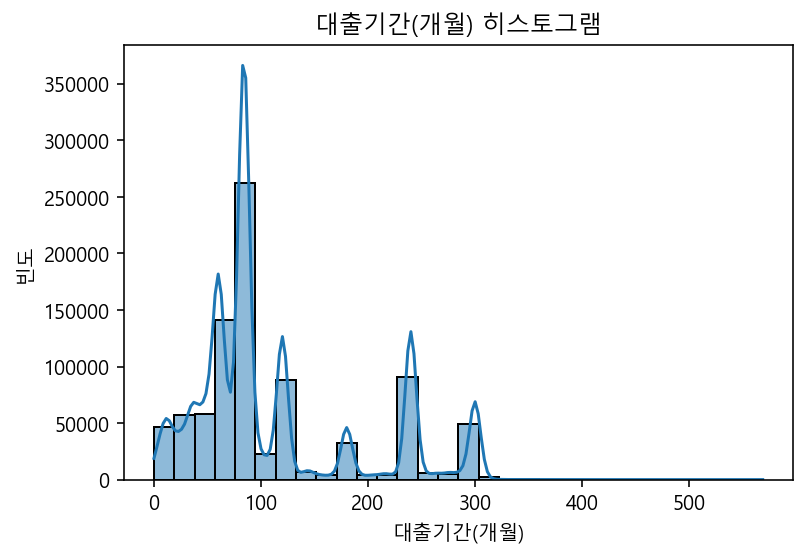

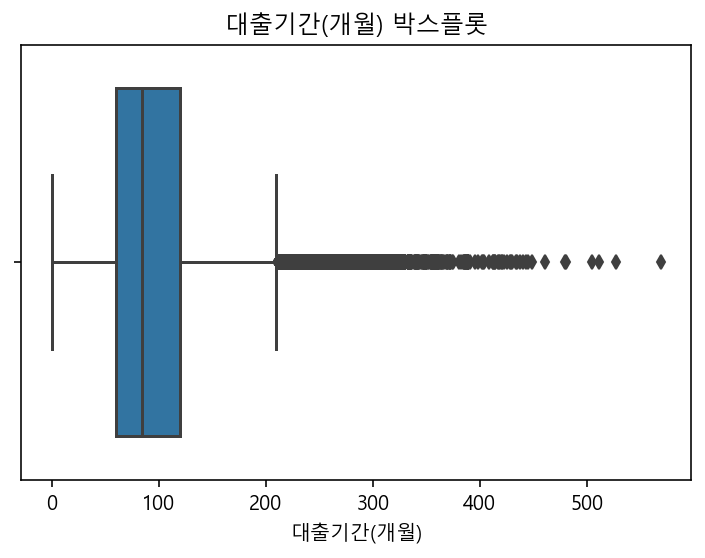

In [257]:
# 히스토그램
sns.histplot(df5['Term'], bins=30, kde=True)
plt.title('대출기간(개월) 히스토그램', fontsize=12)
plt.xlabel('대출기간(개월)')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df5['Term'])
plt.title('대출기간(개월) 박스플롯')
plt.xlabel('대출기간(개월)')
plt.show()

=> 이상치가 있는 것으로 보임.

In [258]:
print(df5.Term.max())

569


In [259]:
df5[df5['Term'] == 569]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2
538152,5407564004,D & D'S FLOORING & INTERIORS,CHARLOTTE,NC,28207,"READYCAP LENDING, LLC",CA,17,2002-05-17,2002,...,30-Jun-02,515000,0,0,0,515000,386250,0,그외,2049-03-25


In [260]:
df5[df5['Term'] >= 500]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2
379265,3739613007,THE INN ON THE LIBRARY LAWN,WESTPORT,NY,12993,JPMORGAN CHASE BANK NATL ASSOC,NY,17,1990-01-12,1990,...,30-Apr-90,307000,0,0,0,307000,260950,1,그외,2031-10-22
483856,4786884000,PACIFIC SURF PROPERTIES,EL CAJON,CA,92020,COMERICA BANK,TX,1,2001-08-07,2001,...,31-Aug-01,1332000,0,0,0,1332000,999000,0,그외,2044-12-13
538152,5407564004,D & D'S FLOORING & INTERIORS,CHARLOTTE,NC,28207,"READYCAP LENDING, LLC",CA,17,2002-05-17,2002,...,30-Jun-02,515000,0,0,0,515000,386250,0,그외,2049-03-25
766988,8316983003,"MASTER POTATOES, INC.",PLYMOUTH,MN,55447,ASSOCIATED BANK NATL ASSOC,MN,17,1995-05-05,1995,...,31-Jul-95,72165,0,0,0,72500,65250,1,그외,2037-07-20


=> 약 40년 이상이 만기인 대출 상품은 아예 불가능한 숫자가 아니므로 별도로 이상치 처리는 하지 않는다.

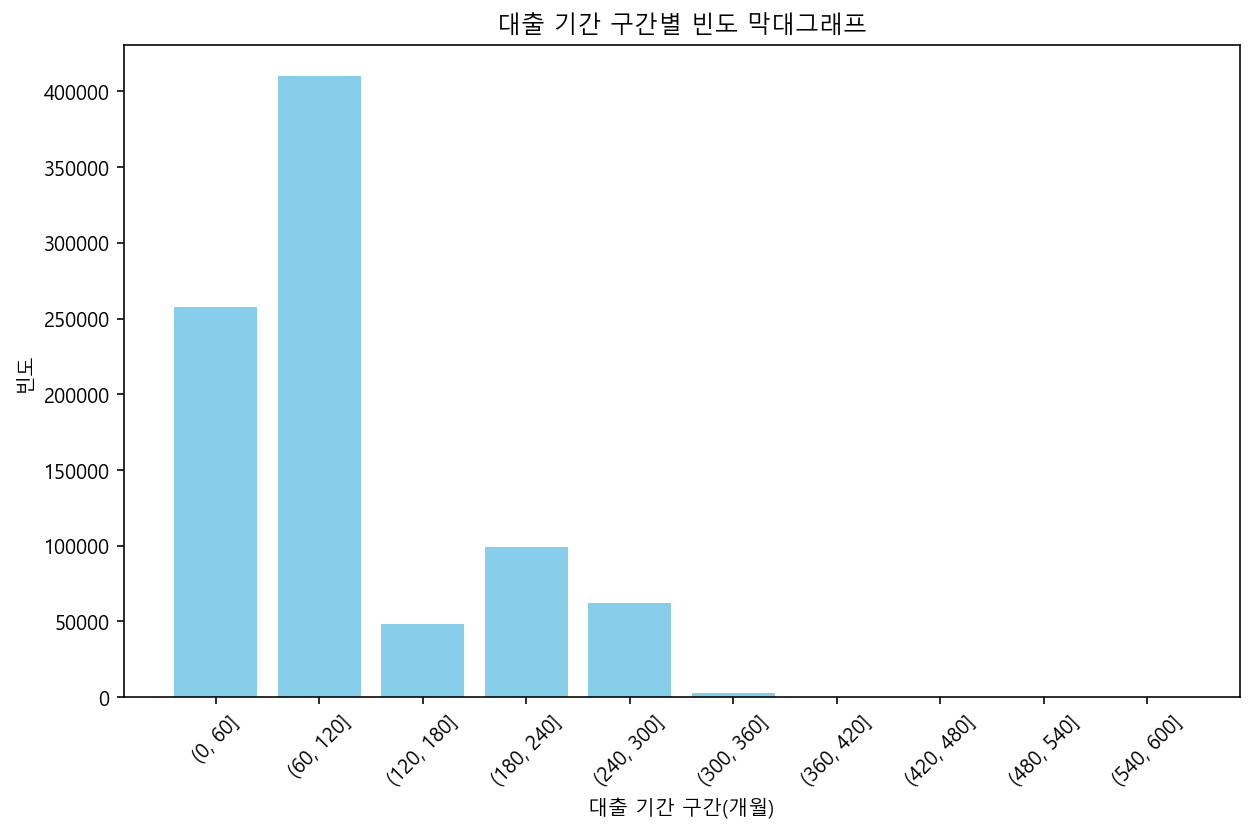

In [261]:
# 막대그래프로 시각화

# 대출 기간을 일정 구간으로 나누기 위한 구간 설정
bins = np.arange(0, df5['Term'].max() + 60, 60)  # 60개월 간격으로 구간 설정

# 대출 기간을 구간에 매핑
term_bins = pd.cut(df5['Term'], bins=bins)

# 각 구간의 빈도수 계산
term_counts = term_bins.value_counts().sort_index()

# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(term_counts.index.astype(str), term_counts.values, color='skyblue')
plt.xlabel('대출 기간 구간(개월)')
plt.ylabel('빈도')
plt.title('대출 기간 구간별 빈도 막대그래프')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()

- 5년 ~ 10년(60개월~120개월) 단위의 대출 기간이 가장 빈도가 높게 나타났다.
- 장기로 대출을 해주는 경우도 구간별로 1건씩 존재한다.

<span style="color:Blue">파생변수 생성(Term_re)</span>
- 단기 : 5년 미만(0)
- 중기 : 5년 이상 15년 미만(1)
- 장기 : 15년 이상(2)

In [262]:
# Term 변수를 단기, 중기, 장기로 나눠보기
df5['Term_re'] = pd.cut(df5['Term'], bins=[-float('inf'), 60, 180, float('inf')], labels=[0, 1, 2])

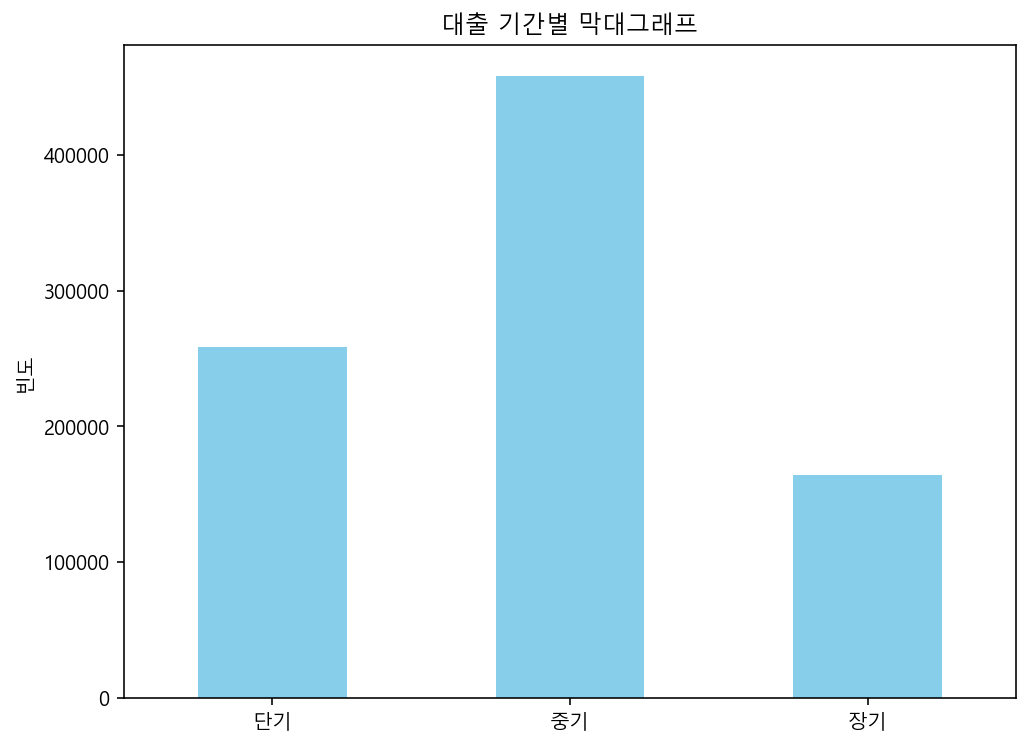

In [263]:
# Term_re 열의 값에 따라 막대그래프 생성
plt.figure(figsize=(8, 6))
df5['Term_re'] = df5['Term_re'].replace({0: '단기', 1: '중기', 2: '장기'})
df5['Term_re'].value_counts().loc[['단기', '중기', '장기']].plot(kind='bar', color='skyblue')

plt.title('대출 기간별 막대그래프')
plt.xlabel('')
plt.ylabel('빈도')
plt.xticks(rotation=0)
plt.show()

중기 > 단기 > 장기 순으로 대출 기간이 분포하고 있다.

### Term에 따른 MIS_Status 비율 확인

In [264]:
# Term_re에 따른 MIS_Status의 비율 계산
term_mis_counts = df5.groupby(['Term_re', 'MIS_Status']).size().unstack()
display(term_mis_counts)

term_mis_counts = term_mis_counts.div(term_mis_counts.sum(axis=1), axis=0)
display(term_mis_counts)

MIS_Status,0,1
Term_re,,
단기,157516,100987
장기,158752,5398
중기,409715,48458


MIS_Status,0,1
Term_re,,
단기,0.609339,0.390661
장기,0.967115,0.032885
중기,0.894236,0.105764


In [265]:
tmp = pd.DataFrame(term_mis_counts)
tmp

MIS_Status,0,1
Term_re,,
단기,0.609339,0.390661
장기,0.967115,0.032885
중기,0.894236,0.105764


In [266]:
# 새로운 행 순서를 정의합니다. 예를 들어, [2, 0, 1]로 순서를 변경합니다.
new_order = ['단기','중기','장기']

# reindex를 사용하여 행 순서를 변경합니다.
tmp = tmp.reindex(new_order)
tmp

MIS_Status,0,1
Term_re,,
단기,0.609339,0.390661
중기,0.894236,0.105764
장기,0.967115,0.032885


<Figure size 1080x576 with 0 Axes>

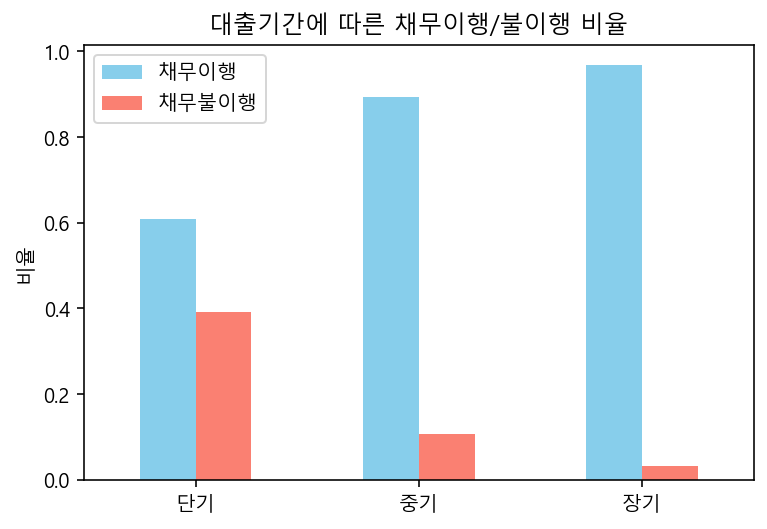

In [267]:
# 막대그래프로 시각화
plt.figure(figsize=(15, 8))
tmp.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])

# 그래프 제목과 축 라벨 설정
plt.title('대출기간에 따른 채무이행/불이행 비율')
plt.xlabel('')
plt.ylabel('비율')

# 범례 추가
plt.legend(['채무이행', '채무불이행'], title='')
plt.xticks(rotation=0)
plt.show()

- 대출 기간이 길어질수록 채무 이행 비율이 높아진다.
- 대출 기간이 길어질수록 채무 불이행 비율이 낮아진다.
- 따라서 장기 대출 상품일수록 채무 이행 확률이 높고, 채무 불이행 확률이 낮다고 볼 수 있다.
- 단기 대출 상품의 경우, 채무 불이행 확률이 다른 상품에 비해 높다고 볼 수 있다.
- <span style="color:Blue">=> 이제 막 비즈니스를 시작한 중소기업의 경우, 대출의 만기가 길수록 비즈니스가 성장한 시점이 되어 상환 능력이 더욱 커진다는 것을 의미한다.</span>

In [268]:
df5['Term_re'] = df5['Term_re'].replace({'단기': 0, '중기':1, '장기':2})

## (20) NoEmp : 직원 수

In [271]:
df5.NoEmp

0          4
1          2
2          7
3          2
4         14
          ..
880821     6
880822     6
880823    26
880824     6
880825     1
Name: NoEmp, Length: 880826, dtype: int64

In [272]:
df5.NoEmp.value_counts().sort_values(ascending=False)

1       150162
2       135250
3        88826
4        72284
5        59182
         ...  
1550         1
4012         1
4658         1
479          1
357          1
Name: NoEmp, Length: 594, dtype: int64

=> 직원 수가 1명인 경우가 제일 많음? 

In [273]:
# 기술통계량 확인해봤을 때, NoEmp의 최솟값이 0인 경우가 있었으므로, 0인 경우 추출
df5[df5.NoEmp == 0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re
1039,1007485003,Hoffman and Associates Dental,ORLANDO,FL,32826,WELLS FARGO BANK NATL ASSOC,SD,10,2003-08-01,2003,...,86000,0,0,0,86000,43000,0,0,2006-09-14,0
1042,1007495006,Hoffman and Associates Dental,ORLANDO,FL,32826,WELLS FARGO BANK NATL ASSOC,SD,10,2003-08-01,2003,...,36857,0,0,0,20000,10000,0,0,2006-12-15,0
1408,1009885009,"THE TIRE DEPOT, INC",BRANDON,MS,39047,TRUSTMARK NATIONAL BANK,MS,17,2004-01-15,2004,...,84168,0,0,0,50000,25000,1,0,2008-04-12,0
1461,1010355000,Tropical Smoothie Cafe and Del,MADISON,AL,35758,WELLS FARGO BANK NATL ASSOC,SD,1,2004-03-09,2004,...,125000,0,0,0,125000,62500,0,0,2009-08-05,0
1532,1010865000,The Matterhorn - Ice Cream & C,COLLEGEVILLE,PA,19426,UNIVEST BANK AND TRUST CO.,PA,1,2004-03-26,2004,...,65003,0,0,0,45000,22500,1,0,2009-07-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649976,6728795005,JH Group LLC,PEARL CITY,HI,96782,"AMERICAN SAVINGS BANK, FSB",HI,1,2014-03-18,2014,...,200000,0,0,0,200000,180000,1,0,2019-02-20,0
655140,6816425010,"Toasted Frog Fargo, LLC",FARGO,ND,58105,BANK FORWARD,ND,1,2014-05-06,2014,...,150000,0,0,0,150000,75000,1,0,2019-06-04,0
658503,6878215001,"Onsite Contractors, LLC",Harrison,OH,45030,THE HUNTINGTON NATIONAL BANK,OH,5,2014-06-05,2014,...,17200,0,0,0,17200,8600,1,0,2019-05-10,0
659487,6895265007,MARK DEMATTIA INCORPORATED,EWA BEACH,HI,96706,CENTRAL PACIFIC BANK,HI,18,2014-06-12,2014,...,50000,0,0,0,50000,25000,1,0,2019-05-17,0


- 기업별로 찾아보니, 가족 단위의 기업인데도 직원 수가 0인 것으로 보아 NoEmp == 0인 경우는 결측치라고 추측할 수 있음.
- NoEmp == 0 인 경우는 전체 데이터의 0.73%을 차지하므로 제거!

In [274]:
df5 = df5[df5['NoEmp'] != 0]

In [275]:
df5.shape

(874405, 30)

### 분포 확인하기

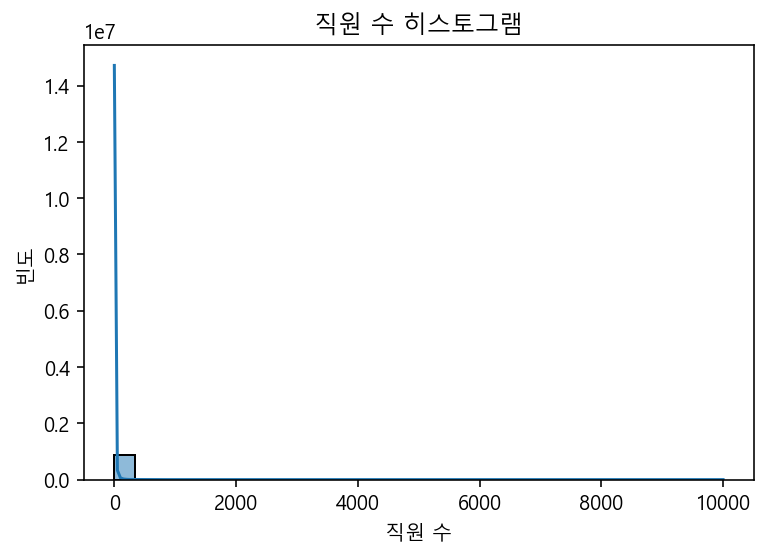

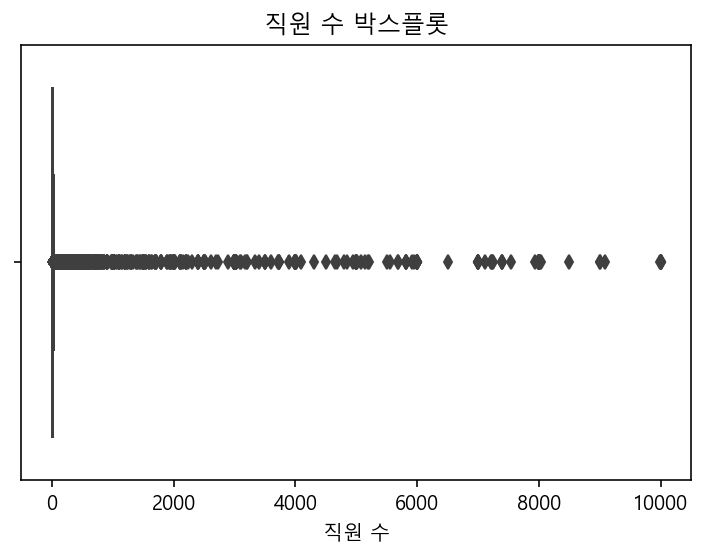

In [276]:
# 히스토그램
sns.histplot(df5['NoEmp'], bins=30, kde=True)
plt.title('직원 수 히스토그램', fontsize=12)
plt.xlabel('직원 수')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df5['NoEmp'])
plt.title('직원 수 박스플롯')
plt.xlabel('직원 수')
plt.show()

=> 이상치가 있는 것처럼 보임.

### 이상치 처리하기

In [277]:
print(df5.NoEmp.max())
print(df5.NoEmp.min())

9999
1


In [278]:
df5[df5['NoEmp'] > 9000]['NoEmp']

7676      9992
43592     9999
161010    9999
494019    9999
586826    9090
600449    9999
Name: NoEmp, dtype: int64

In [279]:
df5[df5['NoEmp'] == 1]['NoEmp']

7         1
10        1
14        1
29        1
46        1
         ..
880806    1
880807    1
880812    1
880816    1
880825    1
Name: NoEmp, Length: 150162, dtype: int64

- 직원 수가 9999이면 이상치 처리를 9999로 한 거라고 생각했는데, 막상 9999로 처리된 데이터는 4개에 불과했다.
- 그래도 중소기업이면 직원 수가 9000명 이상이면 너무 많은 것 같은데 따로 기준이 나와있는 게 있는지?

In [280]:
# 미국 중소기업 직원 수 기준이 최대 1500명이므로 1500명 이하인 경우만 추출
df5[df5['NoEmp'] <= 1500]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,60000,0,0,0,60000,48000,0,0,2006-01-22,1
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1,1997-02-28,1997,...,40000,0,0,0,40000,32000,1,0,2002-05-05,0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,8,1997-02-28,1997,...,287000,0,0,0,287000,215250,1,0,2012-10-13,1
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1,1997-02-28,1997,...,35000,0,0,0,35000,28000,1,0,2002-06-04,0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,229000,0,0,0,229000,229000,1,0,2017-01-29,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880821,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,70000,0,0,0,70000,56000,0,0,2002-09-04,0
880822,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,85000,0,0,0,85000,42500,0,0,2002-10-05,0
880823,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,300000,0,0,0,300000,225000,1,0,2006-08-14,1
880824,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,1,1997-02-27,1997,...,75000,0,1,46383,75000,60000,1,0,2002-03-05,0


=> 전체 데이터의 약 99% 차지! 따라서 1500 이하인 경우만 남기고 진행하기!

In [281]:
df6 = df5[df5['NoEmp'] <= 1500]
df6.shape

(874220, 30)

### <span style="color:Blue">파생변수 생성(smallmedium)</span>
- 500명 미만(소기업) = 0, 500명 이상 1500명 이하(중기업) =1로 재분류

In [282]:
# NoEmp 값이 500 미만이면 0, 500 이상이면 1을 할당하는 함수 정의
def categorize_size(x):
    if x < 500:
        return 0
    else:
        return 1

# apply 함수를 사용하여 smallmedium 파생 변수 생성
df6['smallmedium'] = df6['NoEmp'].apply(categorize_size)

In [283]:
display(df6[['NoEmp','smallmedium']].head())
display(df6[['NoEmp','smallmedium']].tail())

,NoEmp,smallmedium
0,4,0
1,2,0
2,7,0
3,2,0
4,14,0


,NoEmp,smallmedium
880821,6,0
880822,6,0
880823,26,0
880824,6,0
880825,1,0


In [284]:
# smallmedium이 1인 경우가 잘 안보여서 따로 추출
df6[df6['smallmedium'] == 1]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium
8113,1055924002,"CORPORATE MAINT MGMT SVCS, INC",ST. LOUIS,MO,63139,CASS COMMERCIAL BANK,MO,17,1997-03-21,1997,...,0,0,0,100000,80000,1,0,1999-07-21,0,1
11091,1080954002,"BRANDYWINE BUILDING SERVICES,",WILMINGTON,DE,19804,WELLS FARGO BANK NATL ASSOC,PA,13,1997-04-01,1997,...,0,0,0,325000,243750,0,0,2004-11-24,1,1
18400,1136894008,GARRIS PLASTERING,GARDEN GROVE,CA,92843,MORTGAGE CAP. DEVEL CORP,CA,5,1997-04-16,1997,...,0,0,0,416000,416000,1,0,2017-04-02,2,1
34747,1270784000,SNELLING PERSONNEL,BELLE MEAD,NJ,8502,"TD BANK, NATIONAL ASSOCIATION",PA,8,1997-05-22,1997,...,0,0,0,200000,150000,0,0,2006-01-28,1,1
45849,1363584009,"MOORE'S CAFETERIA SERVICES, LT",SAN ANTONIO,TX,78219,BANK OF AMERICA NATL ASSOC,NC,1,1997-06-18,1997,...,0,0,0,100000,50000,0,0,1998-07-26,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861029,9539323006,"MOORE'S CAFETERIA SERVICES, LT",SAN ANTONIO,TX,78219,BANK OF AMERICA NATL ASSOC,TX,14,1996-09-12,1996,...,0,0,0,60000,30000,1,0,2002-06-04,0,1
863918,9589753004,ICOM MECHANICAL INC.,SAN JOSE,CA,95112,"CAPITAL ACCESS GROUP, INC.",CA,18,1996-09-27,1996,...,0,0,0,721000,721000,1,0,2016-10-02,2,1
865144,9625053004,TURTLE MOUNTAIN MFG CO.,BELCOURT,ND,58316,STARION FINANCIAL,ND,10,1996-10-08,1997,...,0,0,0,250000,187500,1,0,2001-12-05,0,1
869280,9750044007,"MOJAVE LABORATORIES, INC.",OAK PARK HEIGHTS,MN,55082,LAKE ELMO BANK,MN,10,2006-01-23,2006,...,0,1,169478,1500000,1350000,1,0,2006-09-28,0,1


### NoEmp에 따른 MIS_Status 비율 확인하기

<Figure size 1080x576 with 0 Axes>

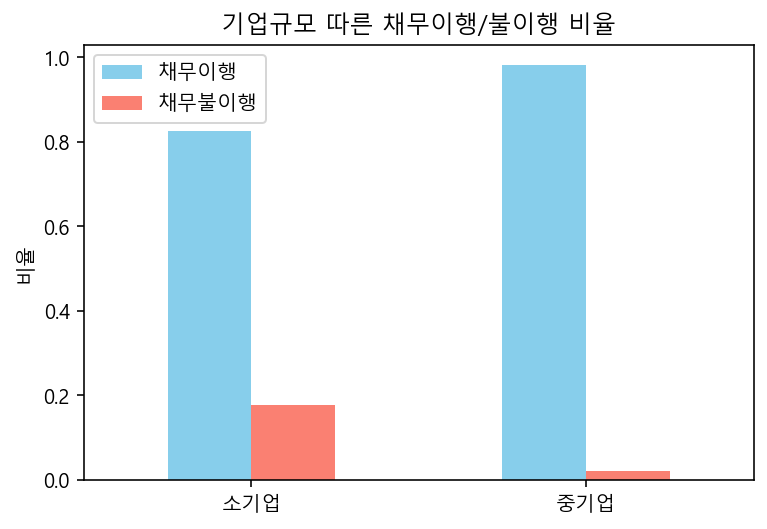

In [285]:
# smallmedium 변수에 따른 MIS_Status 비율 계산
df6['smallmedium'] = df6['smallmedium'].replace({0: '소기업', 1: '중기업'})
noemp_mis_ratio = df6.groupby('smallmedium')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
plt.figure(figsize=(15, 8))
noemp_mis_ratio.plot(kind='bar', stacked=False, color=['skyblue','salmon'])
plt.xlabel('')
plt.ylabel('비율')
plt.title('기업규모 따른 채무이행/불이행 비율')
plt.legend(['채무이행', '채무불이행'],title='')
plt.xticks(rotation=0)
plt.show()

- 중소기업 중에서도 그나마 규모가 큰 경우(1), 채무 이행 비율이 1에 가깝다,
- 또한 중기업에 해당하는 경우, 채무 불이행 비율은 0에 가깝다.
- 소기업의 경우 채무 이행 확률은 0.8, 채무 불이행 확률은 0.2로 나타났다.
- <span style="color:Blue">=> 이를 통해 중소기업 중에서도 규모가 더 큰 경우에는 규모가 작은 소기업에 비해 채무 상환 능력이 더 크다는 것을 알 수 있다.</span>=>

In [286]:
df6['smallmedium'] = df6['smallmedium'].replace({'소기업': 0, '중기업': 1})

### NoEmp = CreateJob + RetainedJob인지 확인해보기

In [287]:
# NoEmp 값이 CreateJob과 RetainedJob을 더해서 나온 값인지 확인
is_matched = df6.apply(lambda row: row['NoEmp'] == row['CreateJob'] + row['RetainedJob'], axis=1)
is_matched

0         False
1         False
2         False
3         False
4          True
          ...  
880821    False
880822    False
880823    False
880824    False
880825    False
Length: 874220, dtype: bool

In [288]:
is_matched[is_matched == True].sum()

275048

=> 직원 수 = 신규 직원 수 + 기존 직원 수인 경우는 약 27만 건으로 약 30%였다. 따라서 꼭 직원 수의 값이 신규 + 기존 직원이라고 보기에는 어렵다.

## (21) CreateJob : 신규 직원 수

In [289]:
df6.CreateJob

0         0
1         0
2         0
3         0
4         7
         ..
880821    0
880822    0
880823    0
880824    0
880825    0
Name: CreateJob, Length: 874220, dtype: int64

In [290]:
df6.CreateJob.value_counts()

0       613744
1        60825
2        55625
3        27739
4        19760
         ...  
1200         1
129          1
171          1
169          1
1530         1
Name: CreateJob, Length: 240, dtype: int64

### 분포 확인하기

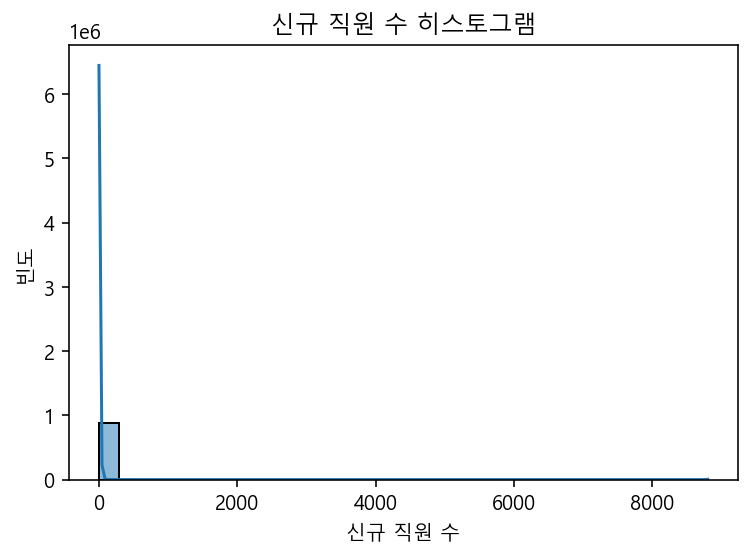

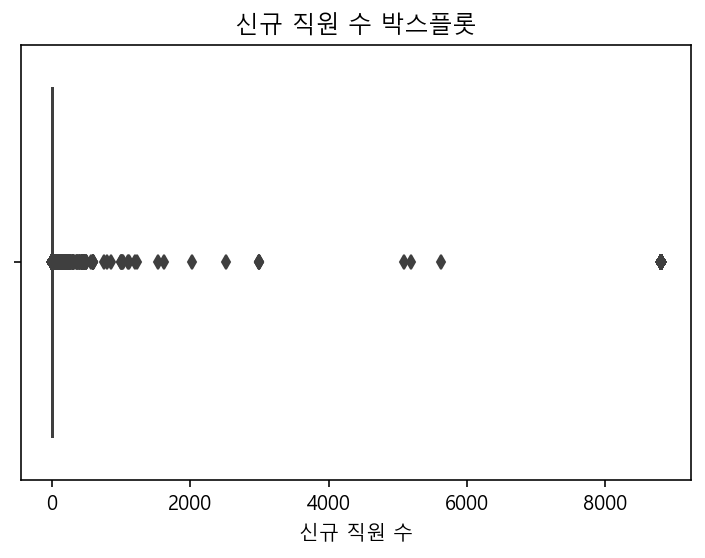

In [291]:
# 히스토그램
sns.histplot(df6['CreateJob'], bins=30, kde=True)
plt.title('신규 직원 수 히스토그램', fontsize=12)
plt.xlabel('신규 직원 수')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df6['CreateJob'])
plt.title('신규 직원 수 박스플롯')
plt.xlabel('신규 직원 수')
plt.show()

=> 이상치가 있는 것처럼 보임.

### 이상치 처리하기

In [292]:
print(df6.CreateJob.max())
print(df6.CreateJob.min())

8800
0


In [293]:
df6[df6['CreateJob'] == 8800]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium
230858,2662583007,"JOHNNYCAKE HILL ASSOCIATES, A","MIDDLETOWN,",RI,2840,OCEAN ST. BUS. DEVEL AUTHORITY,RI,18,1986-06-30,1986,...,0,0,0,227000,227000,1,0,2006-08-27,2,0
231052,2663953002,DENTAL EYE CARE ASSOCIATES,ST. GEORGE,UT,84770,MOUNTAIN W. SMALL BUS. FINAN,UT,8,1986-06-30,1986,...,0,0,0,314000,314000,1,0,2007-01-21,2,0
231059,2664003001,TRI-STATE BATTERY ELECT & COMP,PADUCAH,KY,42001,U.S. BANK NATIONAL ASSOCIATION,KY,2,1986-07-01,1986,...,0,1,136865,155000,129425,1,0,1990-06-18,0,0
231108,2664373007,"MCKAY LINCOLN MERCURY, INC.",COON RAPIDS,MN,55433,CENTRAL MINNESOTA DEVEL CO,MN,17,1986-07-02,1986,...,0,0,0,500000,500000,1,0,2007-03-04,2,0
231115,2664403003,"FOUR CROWN, INC.",OAK PARK HEIGHTS,MN,55082,MINNESOTA BUS. FINAN CORP,MN,1,1986-07-02,1986,...,0,0,0,233000,233000,1,0,2006-07-30,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240496,2728093006,"CARPENTER TRANSFER, INC.",WILMINGTON,DE,19899,DELAWARE COMMUN DEVEL CORP,DE,14,1986-09-30,1986,...,0,0,0,152000,152000,1,0,2007-12-02,2,0
240500,2728163003,SHANNON TOWING INC/LHK INC,LYNNWOOD,WA,98036,EVERGREEN BUSINESS CAPITAL,WA,13,1986-09-30,1986,...,0,0,0,291000,291000,1,0,2006-10-29,2,0
240515,2728253006,FIORANO TILE IMPORTS INC.,ELMONT,NY,11003,LONG ISLAND DEVEL CORP,NY,17,1986-09-30,1986,...,0,0,0,350000,350000,1,0,2008-09-28,2,0
240517,2728263009,MARINER PERFORMANCE,SANTEE,CA,92071,CDC SMALL BUS. FINAN CORP,CA,6,1986-09-30,1986,...,0,0,0,331000,331000,1,0,2006-09-03,2,0


In [294]:
# 신규 직원 수가 8800명인 경우의 기업명 추출해보기(모두 같은 기업인지 확인)
df6[df6['CreateJob'] == 8800]['Name'].value_counts()

GULL INDUSTRIES, INC.             1
CAPE COD CONVENTION BUREAU        1
JACK T. ELMORE                    1
WHEEL OF GOLD DBA CHINESE VILL    1
ROGAR MANUFACTURING CORPORATIO    1
                                 ..
S & R EGG FARM INC                1
HUTCHINS PHOTOGRAPHY, INC.        1
PARTY LAND                        1
HOTSY OF KS %RICHARD GELVIN       1
TRI-STATE BATTERY ELECT & COMP    1
Name: Name, Length: 628, dtype: int64

- 기업이 모두 다르므로 8800이 정말 신규 직원 수가 8800명이라고 생각하기에는 무리가 있어 보인다.
- 이상치 처리가 필요해보인다.

In [295]:
# NoEmp와 마찬가지로 1500명을 기준으로 추출해보기
df6[df6['CreateJob'] <= 1500]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,0,0,0,60000,48000,0,0,2006-01-22,1,0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1,1997-02-28,1997,...,0,0,0,40000,32000,1,0,2002-05-05,0,0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,8,1997-02-28,1997,...,0,0,0,287000,215250,1,0,2012-10-13,1,0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1,1997-02-28,1997,...,0,0,0,35000,28000,1,0,2002-06-04,0,0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,0,0,0,229000,229000,1,0,2017-01-29,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880821,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,0,0,0,70000,56000,0,0,2002-09-04,0,0
880822,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,0,0,0,85000,42500,0,0,2002-10-05,0,0
880823,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,0,0,0,300000,225000,1,0,2006-08-14,1,0
880824,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,1,1997-02-27,1997,...,0,1,46383,75000,60000,1,0,2002-03-05,0,0


=> 전체 데이터의 약 99.9% 차지하므로 1500명을 기준으로 자르기

In [296]:
df7 = df6[df6['CreateJob'] <= 1500]
df7.shape

(873581, 31)

### CreateJob에 따른 MIS_Status 비율 확인

### <span style="color:Blue">파생변수 생성(createjob2)</span>
- 0인~3인 : 0
- 4인~20인 : 1
- 21인 이상 : 2

In [300]:
df7['createjob2'] = pd.cut(df7['CreateJob'], bins=[-float('inf'), 3, 20, float('inf')], labels=[0, 1, 2])

In [301]:
df7[['CreateJob', 'createjob2']].head()

,CreateJob,createjob2
0,0,0
1,0,0
2,0,0
3,0,0
4,7,1


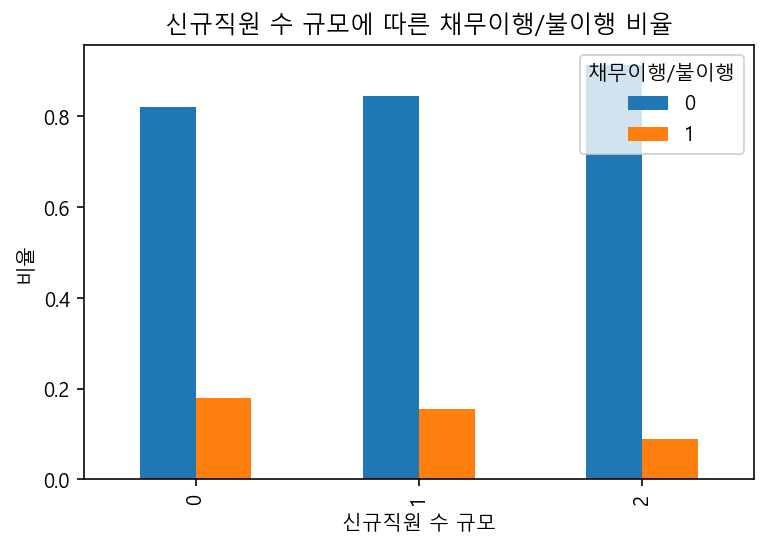

In [302]:
# createjob2 변수에 따른 MIS_Status 비율 계산
createjob2_ratio = df7.groupby('createjob2')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
createjob2_ratio.plot(kind='bar', stacked=False)
plt.xlabel('신규직원 수 규모')
plt.ylabel('비율')
plt.title('신규직원 수 규모에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 신규 직원 수가 많을수록(2), 채무 이행 비율은 1에 가깝다. 또한 채무 불이행 비율은 0에 가깝다.
- <span style="color:Blue">이를 통해 신규 직원 수가 많을수록 해당 기업은 채용 과정에서 발생하는 비용을 부담할 수 있는 능력이 있고(=규모가 크고), 따라서 채무 상환 능력이 있다.</span>

## (22) RetainedJob : 기존 직원 수

In [303]:
df7.RetainedJob

0         0
1         0
2         0
3         0
4         7
         ..
880821    0
880822    0
880823    0
880824    0
880825    0
Name: RetainedJob, Length: 873581, dtype: int64

In [304]:
df7.RetainedJob.value_counts()

0      427927
1       85610
2       74383
3       48490
4       38635
        ...  
262         1
260         1
259         1
255         1
247         1
Name: RetainedJob, Length: 349, dtype: int64

### 분포 확인하기

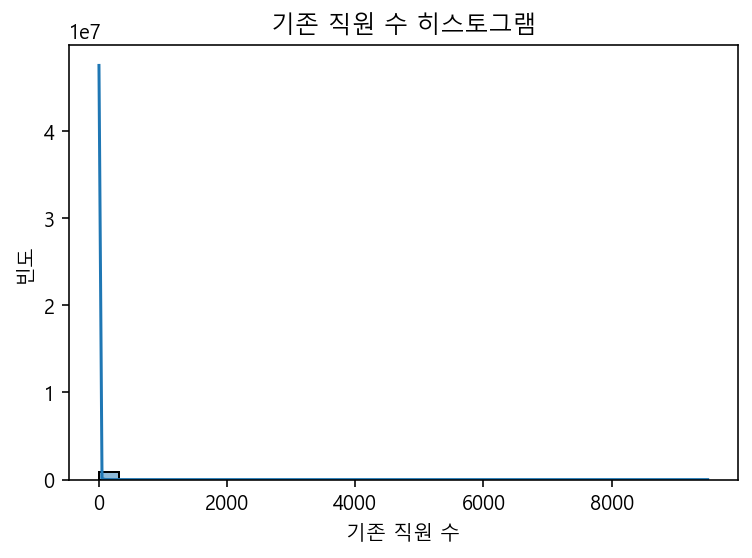

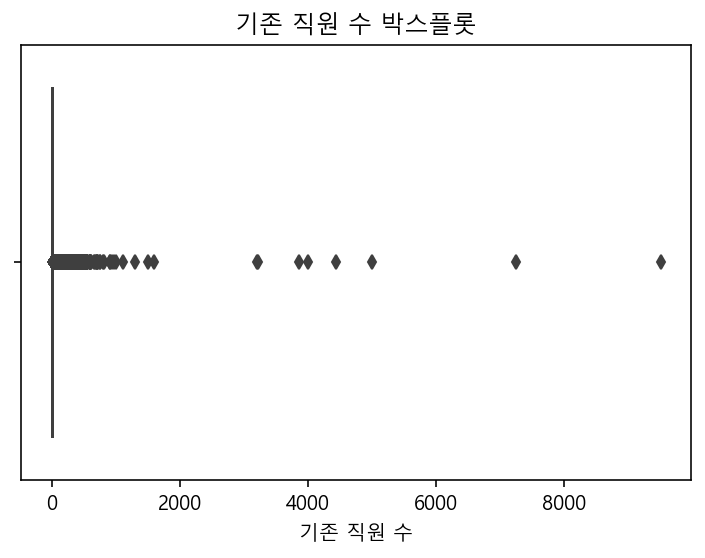

In [305]:
# 히스토그램
sns.histplot(df7['RetainedJob'], bins=30, kde=True)
plt.title('기존 직원 수 히스토그램', fontsize=12)
plt.xlabel('기존 직원 수')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df7['RetainedJob'])
plt.title('기존 직원 수 박스플롯')
plt.xlabel('기존 직원 수')
plt.show()

=> 이상치가 있는 것처럼 보임.

### 이상치 처리하기

In [306]:
print(df7.RetainedJob.max())
print(df7.RetainedJob.min())

9500
0


In [307]:
# 기존 직원 수가 9500명인 경우만 추출
df7[df7['RetainedJob'] == 9500]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2
105797,1792306007,ACAPULCO MEXICAN RESTAURANT,AMARILLO,TX,79101,WELLS FARGO BANK NATL ASSOC,CA,1,2006-04-19,2006,...,0,0,170000,127500,0,0,2030-12-20,2,0,0


In [308]:
# 기존 직원 수가 8000명 이상인 경우만 추출
df7[df7['RetainedJob'] >= 8000]['RetainedJob'].value_counts()

9500    1
Name: RetainedJob, dtype: int64

In [309]:
df7[df7['RetainedJob'] <= 1500]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,0,0,60000,48000,0,0,2006-01-22,1,0,0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1,1997-02-28,1997,...,0,0,40000,32000,1,0,2002-05-05,0,0,0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,8,1997-02-28,1997,...,0,0,287000,215250,1,0,2012-10-13,1,0,0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1,1997-02-28,1997,...,0,0,35000,28000,1,0,2002-06-04,0,0,0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,0,0,229000,229000,1,0,2017-01-29,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880821,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,0,0,70000,56000,0,0,2002-09-04,0,0,0
880822,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,0,0,85000,42500,0,0,2002-10-05,0,0,0
880823,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,0,0,300000,225000,1,0,2006-08-14,1,0,0
880824,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,1,1997-02-27,1997,...,1,46383,75000,60000,1,0,2002-03-05,0,0,0


In [310]:
df8 = df7[df7['RetainedJob'] <= 1500]

In [311]:
df8.shape

(873572, 32)

### RetainedJob에 따른 MIS_Status 비율 확인

### <span style="color:Blue">파생변수 생성(retainedjob2)</span>
- 0인~3인 : 0
- 4인~20인 : 1
- 21인 이상 : 2

In [312]:
df8['retainedjob2'] = pd.cut(df8['RetainedJob'], bins=[-float('inf'), 3, 20, float('inf')], labels=[0, 1, 2])

In [313]:
df8[['RetainedJob', 'retainedjob2']]

,RetainedJob,retainedjob2
0,0,0
1,0,0
2,0,0
3,0,0
4,7,1
...,...,...
880821,0,0
880822,0,0
880823,0,0
880824,0,0


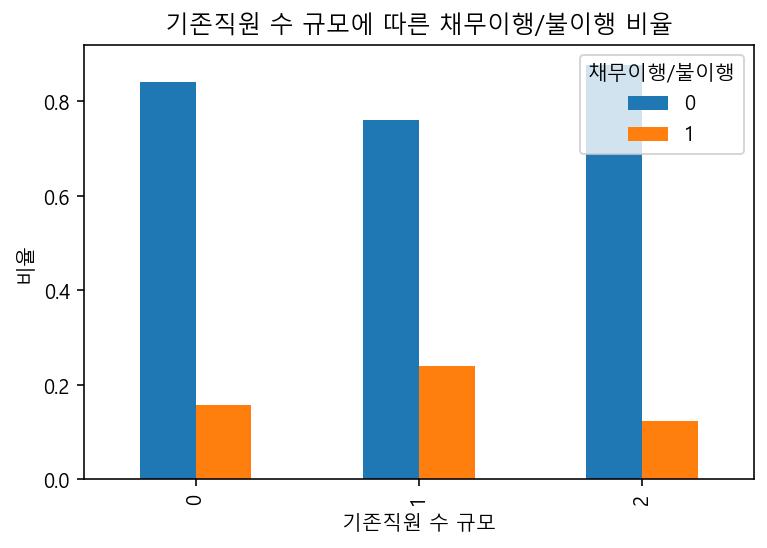

In [314]:
# retainedjob2 변수에 따른 MIS_Status 비율 계산
retainedjob2_ratio = df8.groupby('retainedjob2')['MIS_Status'].value_counts(normalize=True).unstack()

# 시각화
retainedjob2_ratio.plot(kind='bar', stacked=False)
plt.xlabel('기존직원 수 규모')
plt.ylabel('비율')
plt.title('기존직원 수 규모에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

- 기존직원 수 규모가 가장 큰 기업의 경우 채무이행 비율이 높다. 또한 해당 기업은 채무 불이행 비율도 낮다.
- 기존직원 수 규모가 중간 정도인 경우에는 채무 이행 비율이 가장 낮고, 채무 불이행 비율이 가장 높았다.
- => 이를 통해 규모가 일정 수준 이상이 되어야 채무 상환 능력이 있음을 알 수 있다.

In [315]:
df8['retainedjob2'].value_counts()

0    636410
1    198147
2     39015
Name: retainedjob2, dtype: int64

## (23) DisbursementGross : 지급된 금액

In [316]:
df8.DisbursementGross

0          60000
1          40000
2         287000
3          35000
4         229000
           ...  
880821     70000
880822     85000
880823    300000
880824     75000
880825     30000
Name: DisbursementGross, Length: 873572, dtype: int64

In [317]:
df8.DisbursementGross.value_counts()

50000      42584
100000     35999
25000      26072
150000     22847
10000      20202
           ...  
704100         1
675450         1
906889         1
1090714        1
10245          1
Name: DisbursementGross, Length: 116400, dtype: int64

### 분포 확인하기

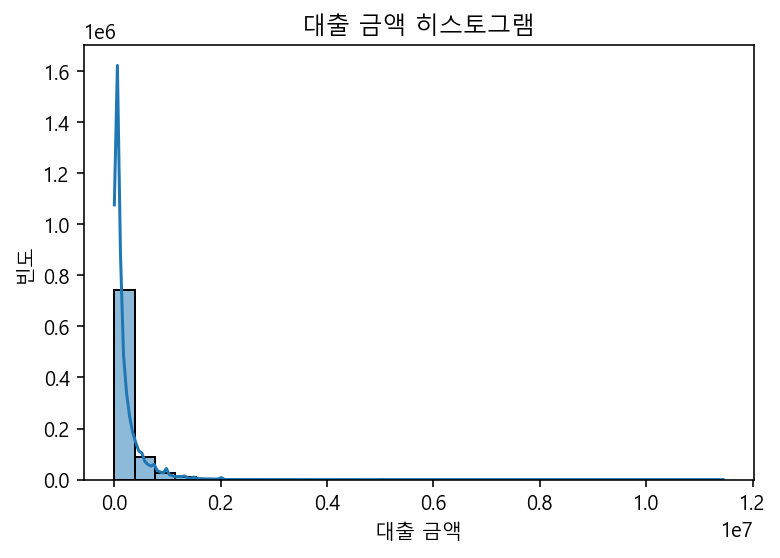

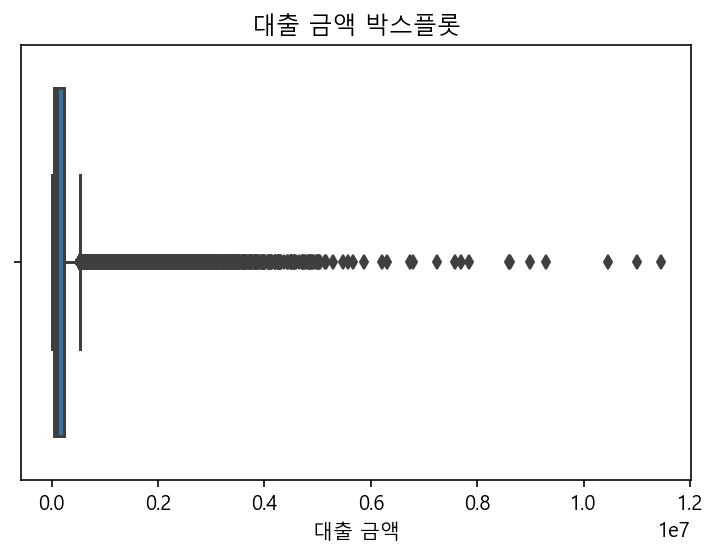

In [318]:
# 히스토그램
sns.histplot(df8['DisbursementGross'], bins=30, kde=True)
plt.title('대출 금액 히스토그램', fontsize=12)
plt.xlabel('대출 금액')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df8['DisbursementGross'])
plt.title('대출 금액 박스플롯')
plt.xlabel('대출 금액')
plt.show()

=> 이상치가 있는 것처럼 보임

### 이상치 처리하기

In [319]:
print(df8.DisbursementGross.max())
print(df8.DisbursementGross.min())

11446325
4000


최댓값은 114억, 최솟값은 400만원

In [320]:
# 100억 이상 추출
df8[df8['DisbursementGross'] > 10000000]['DisbursementGross']

353939    11446325
374131    11000000
814598    10465000
Name: DisbursementGross, dtype: int64

<span style="color:Red">기업에게 100억 이상의 돈을 대출해준다는 게 가능한가?(3건)</span>
- 미국에서 중소기업에게 대출해줄 수 있는 금액은 최대 500만 달러라고 한다. 

In [321]:
# 50억 이상 추출
len(df8[df8['DisbursementGross'] > 5000000]['DisbursementGross'])

23

<span style="color:Red">기업에게 50억 이상의 돈을 대출해준다는 게 가능한가?(23건)</span>

#### 50억 이상의 돈을 대출하는 건 불가능하다고 판단하여 23건 제거

In [322]:
df9 = df8[df8['DisbursementGross'] <= 5000000]
df9

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,ChgOffPrinGr,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,0,60000,48000,0,0,2006-01-22,1,0,0,0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1,1997-02-28,1997,...,0,40000,32000,1,0,2002-05-05,0,0,0,0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,8,1997-02-28,1997,...,0,287000,215250,1,0,2012-10-13,1,0,0,0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1,1997-02-28,1997,...,0,35000,28000,1,0,2002-06-04,0,0,0,0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,0,229000,229000,1,0,2017-01-29,2,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880821,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,0,70000,56000,0,0,2002-09-04,0,0,0,0
880822,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,0,85000,42500,0,0,2002-10-05,0,0,0,0
880823,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,0,300000,225000,1,0,2006-08-14,1,0,0,0
880824,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,1,1997-02-27,1997,...,46383,75000,60000,1,0,2002-03-05,0,0,0,0


### <span style="color:Blue">파생변수 생성(dis_re)</span>
- 1천만원 미만 : 0
- 1천만원 이상 ~ 5천만원 미만 : 1
- 5천만원 이상 ~ 1억 미만 : 2
- 1억 이상 ~ 5억 미만 : 3
- 5억 이상 ~ 10억 미만 : 4
- 10억 이상 : 5

In [323]:
df9['dis_re'] = pd.cut(df9['DisbursementGross'],
                       bins=[-float('inf'), 10000, 50000, 100000, 500000, 1000000, float('inf')],
                       labels=[0, 1, 2, 3, 4, 5],
                       right=False)

df9[['DisbursementGross', 'dis_re']]

,DisbursementGross,dis_re
0,60000,2
1,40000,1
2,287000,3
3,35000,1
4,229000,3
...,...,...
880821,70000,2
880822,85000,2
880823,300000,3
880824,75000,2


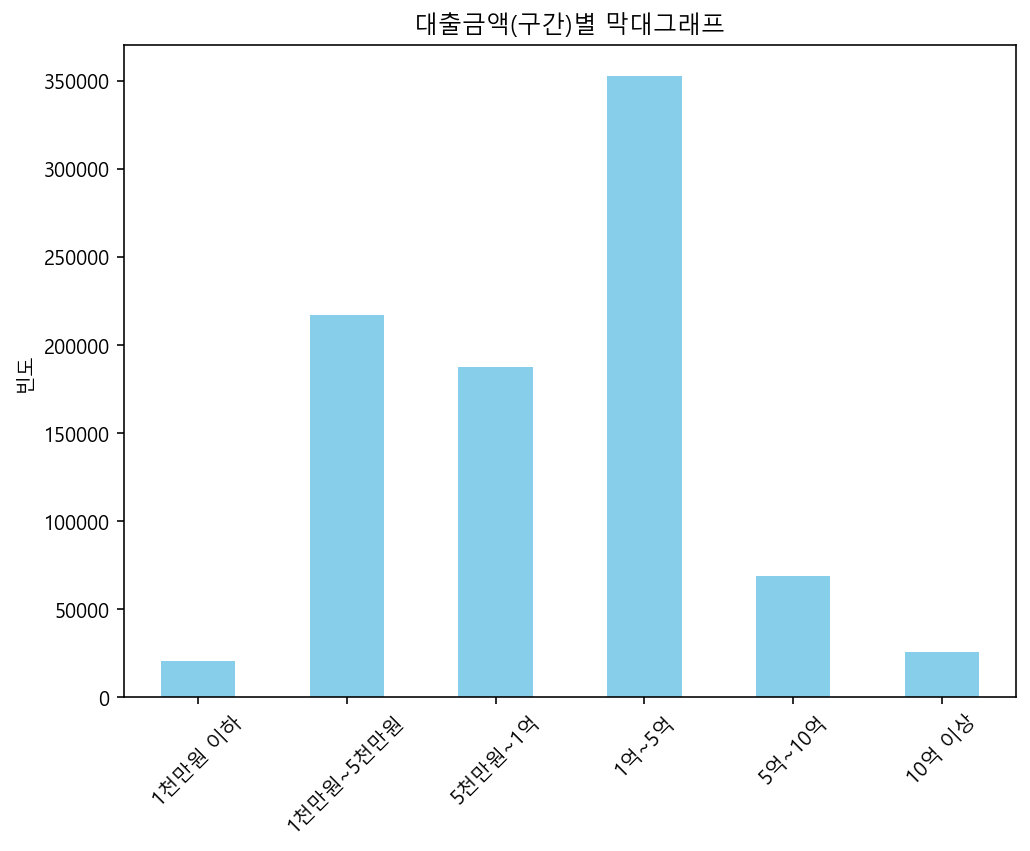

In [324]:
# dis_re 열의 값에 따라 막대그래프 생성
plt.figure(figsize=(8, 6))
df9['dis_re'] = df9['dis_re'].replace({0: '1천만원 이하', 1: '1천만원~5천만원', 2: '5천만원~1억', 3:'1억~5억', 4:'5억~10억',
                                        5: '10억 이상'})
df9['dis_re'].value_counts().loc[['1천만원 이하', '1천만원~5천만원', '5천만원~1억','1억~5억','5억~10억','10억 이상']].plot(kind='bar', color='skyblue')


plt.title('대출금액(구간)별 막대그래프') #지급된 금액 막대그래프보다 이해하기 쉽게
plt.xlabel('')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.show()

- 은행은 1억 이상 ~ 5억 미만의 대출 상품을 가장 많이 판 것을 알 수 있다.

In [325]:
df9['dis_re'] = df9['dis_re'].replace({'1천만원 이하':0, '1천만원~5천만원': 1, '5천만원~1억':2, '1억~5억':3, '5억~10억':4,
                                        '10억 이상':5})

## (24) BalanceGross : 미결제 총액

In [326]:
df9.BalanceGross

0         0
1         0
2         0
3         0
4         0
         ..
880821    0
880822    0
880823    0
880824    0
880825    0
Name: BalanceGross, Length: 873549, dtype: int64

### 분포 확인하기

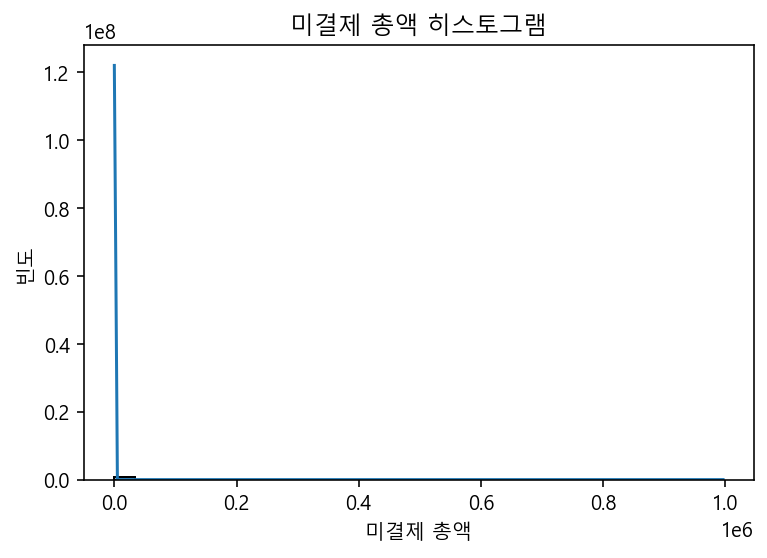

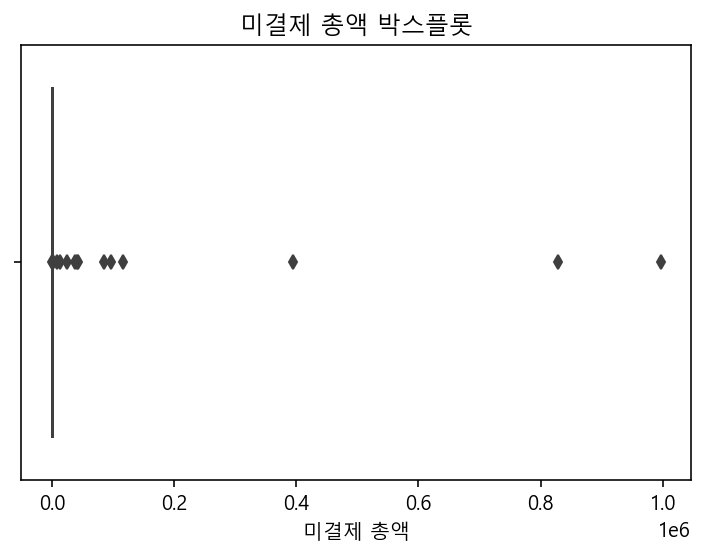

In [327]:
# 히스토그램
sns.histplot(df9['BalanceGross'], bins=30, kde=True)
plt.title('미결제 총액 히스토그램', fontsize=12)
plt.xlabel('미결제 총액')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df9['BalanceGross'])
plt.title('미결제 총액 박스플롯')
plt.xlabel('미결제 총액')
plt.show()

=> 이상치가 있는 것처럼 보임.

### 이상치 처리하기

In [328]:
df9.BalanceGross.value_counts()

0         873535
12750          1
25000          1
9111           1
37100          1
1760           1
96908          1
84617          1
827875         1
43127          1
600            1
115820         1
996262         1
41509          1
395476         1
Name: BalanceGross, dtype: int64

- 대부분이 미결제총액이 0인 경우이다.
- 미결제총액의 정의에 따르면 계약에 따라 대출의 원금과 이자 등을 합산한 총액이다.
- 따라서 채무 불이행 기업의 경우 0이 아닌 값이 나와야 한다고 생각했는데 데이터 대부분이 0이 나와서 의문이 들었다.
- 어차피 현재 시점이 언제인지 확인할 수 없고, BalanceGross 대신 ChgOffPrinGr 변수로 확인이 가능한 부분이라고 생각한다.

In [329]:
df9 = df9.drop(columns=['BalanceGross'])
df9.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'LowDoc',
       'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'MIS_Status',
       'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SameState', 'Recession',
       'ChgOffDate2', 'Term_re', 'smallmedium', 'createjob2', 'retainedjob2',
       'dis_re'],
      dtype='object')

In [330]:
df9.shape

(873549, 33)

## (25) ChgOffPrinGr : 청구된 금액(회수 불가능 금액)

In [331]:
df9.ChgOffPrinGr

0             0
1             0
2             0
3             0
4             0
          ...  
880821        0
880822        0
880823        0
880824    46383
880825        0
Name: ChgOffPrinGr, Length: 873549, dtype: int64

In [332]:
df9.ChgOffPrinGr.value_counts()

0         720479
50000       2084
10000       1734
35000       1318
25000       1292
           ...  
27034          1
202139         1
76210          1
74163          1
62127          1
Name: ChgOffPrinGr, Length: 80979, dtype: int64

### 분포 확인하기

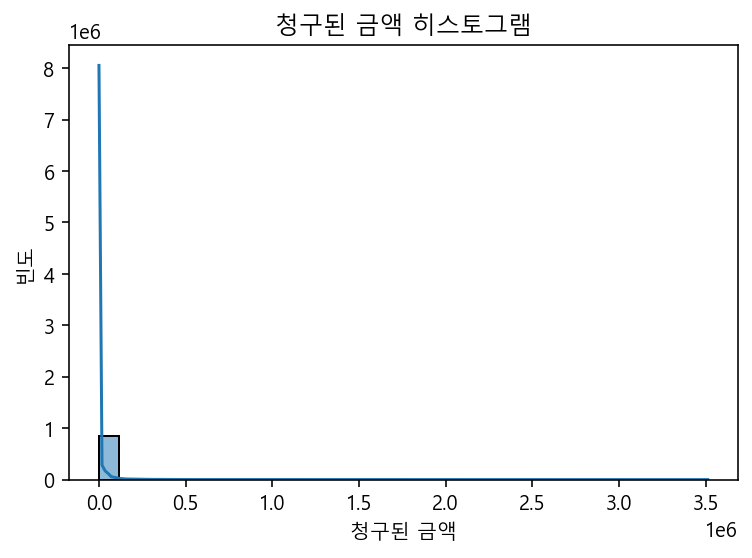

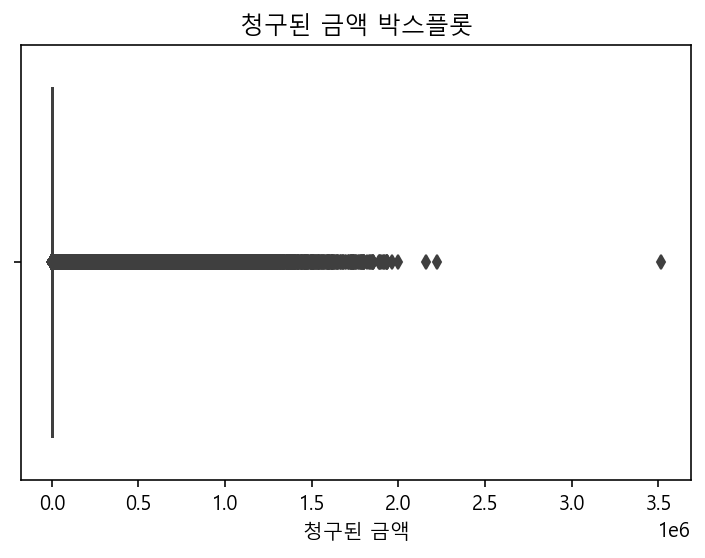

In [333]:
# 히스토그램
sns.histplot(df9['ChgOffPrinGr'], bins=30, kde=True)
plt.title('청구된 금액 히스토그램', fontsize=12)
plt.xlabel('청구된 금액')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df9['ChgOffPrinGr'])
plt.title('청구된 금액 박스플롯')
plt.xlabel('청구된 금액')
plt.show()

=> 이상치가 있는 것처럼 보임.

### 이상치 처리하기

In [334]:
print(df9.ChgOffPrinGr.max())

3512596


=> 최댓값은 35억으로 50억 이하의 값이 나왔다. 따라서 별도의 이상치 처리는 하지 않는다.

In [335]:
df9[df9['ChgOffPrinGr'] == 3512596]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
206390,2484004000,"SUPERIOR WHOLESALE, INC.",ROCHESTER,NY,14609,KEYBANK NATIONAL ASSOCIATION,OH,20,1998-11-16,1999,...,1550000,615350,0,0,2005-12-25,1,0,0,0,5


In [336]:
df9[df9['ChgOffPrinGr'] == 3512596]['DisbursementGross']

206390    1550000
Name: DisbursementGross, dtype: int64

=> 이 기업은 15억을 대출받았는데, 회수 불가능 금액이 35억이 나왔다. 혹시 2번 대출을 받았는지 확인해보기

In [337]:
df9[df9['Name'] == 'SUPERIOR WHOLESALE, INC.']

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
206390,2484004000,"SUPERIOR WHOLESALE, INC.",ROCHESTER,NY,14609,KEYBANK NATIONAL ASSOCIATION,OH,20,1998-11-16,1999,...,1550000,615350,0,0,2005-12-25,1,0,0,0,5


=> 한 건밖에 나오지 않았음!

#### 지급된 금액 < 회수 불가능 금액인 경우 추출해보기

In [338]:
df9[df9['DisbursementGross'] < df9['ChgOffPrinGr']]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
423,1003493006,"SONJI, INC.",ROCHESTER,NY,14615,JPMORGAN CHASE BANK NATL ASSOC,NY,5,1980-07-01,1980,...,195642,140400,1,0,1992-02-09,1,0,0,0,3
1854,1012895002,Guaranteed Mortgage of Minneso,CRYSTAL,MN,55428,"M&I, A BRANCH OF",WI,7,2004-06-04,2004,...,175200,131400,0,0,2023-10-22,2,0,0,0,3
2287,1015733003,"NATIONAL STEEL DRUM CO., INC.",PHILADELPHIA,PA,19134,WELLS FARGO BANK NATL ASSOC,PA,1,1980-07-31,1980,...,500000,450000,1,0,1987-04-17,1,0,0,0,4
2447,1016735008,"J.E.P Industrial Sales,Inc.",EL PASO,TX,79936,BANK OF AMERICA NATL ASSOC,NC,20,2004-06-23,2004,...,35000,17500,0,0,2007-06-16,0,0,0,0,1
2839,1019255001,Carol M Andres dba Carol's Con,SANDUSKY,OH,44870,"PNC BANK, NATIONAL ASSOCIATION",DE,1,2004-06-30,2004,...,50000,25000,0,0,2005-03-28,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877024,9910631008,BENNETT SALES + SERVICE,TAMWORTH,NH,3886,FDIC/BONHAM-BANKEAST,NH,5,1978-07-19,1978,...,70000,63000,1,0,1993-05-23,1,0,0,0,2
877675,9925693010,"CROOKED CREEK, INC",BAXLEY,GA,31513,CHARTERBANK,GA,17,1997-01-28,1997,...,550000,412500,1,0,2017-07-19,2,0,0,0,4
877760,9927983007,"TUBS TO GO SPA MFG., LLP",HELENA,MT,59635,VALLEY BK OF HELENA A DIVISION,MT,10,1997-01-29,1997,...,170000,127500,1,0,2006-01-13,1,0,0,0,3
877871,9930073006,PARAGON SURVEYING,SANTA CLARA,UT,84765,ZIONS FIRST NATIONAL BANK,UT,13,1997-01-29,1997,...,45916,36732,1,0,2000-05-14,0,0,0,0,1


=> 1051개가 은행에서 대출 받은 금액보다 청구된 금액이 더 큰 경우!

In [339]:
default = df9[(df9['ChgOffPrinGr'] != 0) & (df9['MIS_Status'] == 1)]
default

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,13,1980-06-02,1980,...,600000,499998,0,0,1984-04-02,0,0,0,0,4
36,1000554001,PAUL E. & JUDY A. FAATZ,KINSMAN,OH,44428,CORTLAND SAVINGS & BK. CO.,OH,14,1997-02-28,1997,...,47000,37600,1,0,2008-09-30,1,0,0,0,1
43,1000653000,LARRY SCHOETTMER FORD INC,EDINBURGH,IN,46124,JPMORGAN CHASE BANK NATL ASSOC,IN,10,1980-06-11,1980,...,200000,150000,1,0,1990-06-09,1,0,0,0,3
58,1000726007,NEW DIMENSION HOMES INC,CLINTON (CENSUS NAME FOR CLINT,ME,4927,WELLS FARGO BANK NATL ASSOC,SD,5,2006-02-07,2006,...,1350000,1012500,0,0,2019-11-17,1,0,0,1,5
60,1000735003,Mykols Marine Inc.,Spring Lake,MI,49417,WELLS FARGO BANK NATL ASSOC,SD,4,1997-03-31,1997,...,25000,12500,0,0,1998-09-26,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880733,9993873007,"PC PALACE, LTD",CAMP HILL,PA,17011,MANUFACTURERS & TRADERS TR CO,NY,17,1997-02-27,1997,...,150000,112500,0,0,2005-12-15,1,0,0,0,3
880794,9995033006,"MCARTHUR DEVELOPMENT, INC.",CHATTANOOGA,TN,37416,FIRST VOLUNTEER BANK,TN,5,1997-02-27,1997,...,125000,93750,1,0,1997-09-27,0,0,0,0,3
880801,9995143004,MR. GOODCENTS,OVERLAND PARK,KS,66212,METCALF BANK,KS,8,1997-02-27,1997,...,100000,80000,1,0,2000-11-11,0,0,0,0,3
880806,9995213001,CITY CONSTRUCTION CORPORATION,MARLTON,NJ,8053,BANCO POPULAR NORTH AMERICA,NJ,5,1997-02-27,1997,...,150000,112500,1,0,2002-07-04,1,0,0,0,3


In [340]:
print(df9['ChgOffPrinGr'].min())
print(default['ChgOffPrinGr'].min())

0
1


청구된 금액이 겨우 1달러 뿐이라는 것도 상식적으로 받아들여지지는 않는다.

In [341]:
default[default['ChgOffPrinGr'] == 1]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
150510,2117753004,"MICHAEL HENEGEN, ATTORNEY",MOSCOW,ID,83843,KEYBANK NATIONAL ASSOCIATION,ID,18,1984-12-05,1985,...,25000,22500,1,0,1991-12-06,1,0,0,0,1
440536,4375583003,BAILEY LAND SURVEYING,NEW WILMINGTON,PA,16142,FIRST NATL BK OF PENNSYLVANIA,PA,20,1991-02-14,1991,...,103500,82800,1,0,1999-04-18,1,0,0,0,3


### default 데이터프레임에서 ChgoffPrinGr는 1인 2건 제거하기

In [343]:
df9[df9['ChgOffPrinGr'] ==1]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
150510,2117753004,"MICHAEL HENEGEN, ATTORNEY",MOSCOW,ID,83843,KEYBANK NATIONAL ASSOCIATION,ID,18,1984-12-05,1985,...,25000,22500,1,0,1991-12-06,1,0,0,0,1
440536,4375583003,BAILEY LAND SURVEYING,NEW WILMINGTON,PA,16142,FIRST NATL BK OF PENNSYLVANIA,PA,20,1991-02-14,1991,...,103500,82800,1,0,1999-04-18,1,0,0,0,3


In [344]:
df10= df9.drop(df9[df9['ChgOffPrinGr'] ==1].index)
df10.shape

(873547, 33)

In [345]:
# 채무불이행 default 갱신하기
default = df10[(df10['ChgOffPrinGr'] != 0) & (df10['MIS_Status'] == 1)]
default

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,13,1980-06-02,1980,...,600000,499998,0,0,1984-04-02,0,0,0,0,4
36,1000554001,PAUL E. & JUDY A. FAATZ,KINSMAN,OH,44428,CORTLAND SAVINGS & BK. CO.,OH,14,1997-02-28,1997,...,47000,37600,1,0,2008-09-30,1,0,0,0,1
43,1000653000,LARRY SCHOETTMER FORD INC,EDINBURGH,IN,46124,JPMORGAN CHASE BANK NATL ASSOC,IN,10,1980-06-11,1980,...,200000,150000,1,0,1990-06-09,1,0,0,0,3
58,1000726007,NEW DIMENSION HOMES INC,CLINTON (CENSUS NAME FOR CLINT,ME,4927,WELLS FARGO BANK NATL ASSOC,SD,5,2006-02-07,2006,...,1350000,1012500,0,0,2019-11-17,1,0,0,1,5
60,1000735003,Mykols Marine Inc.,Spring Lake,MI,49417,WELLS FARGO BANK NATL ASSOC,SD,4,1997-03-31,1997,...,25000,12500,0,0,1998-09-26,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880733,9993873007,"PC PALACE, LTD",CAMP HILL,PA,17011,MANUFACTURERS & TRADERS TR CO,NY,17,1997-02-27,1997,...,150000,112500,0,0,2005-12-15,1,0,0,0,3
880794,9995033006,"MCARTHUR DEVELOPMENT, INC.",CHATTANOOGA,TN,37416,FIRST VOLUNTEER BANK,TN,5,1997-02-27,1997,...,125000,93750,1,0,1997-09-27,0,0,0,0,3
880801,9995143004,MR. GOODCENTS,OVERLAND PARK,KS,66212,METCALF BANK,KS,8,1997-02-27,1997,...,100000,80000,1,0,2000-11-11,0,0,0,0,3
880806,9995213001,CITY CONSTRUCTION CORPORATION,MARLTON,NJ,8053,BANCO POPULAR NORTH AMERICA,NJ,5,1997-02-27,1997,...,150000,112500,1,0,2002-07-04,1,0,0,0,3


<span style="color:Blue">파생변수 생성(chgoff_re)</span>
- 1천만원 미만 : 0
- 1천만원 이상 ~ 5천만원 미만 : 1
- 5천만원 이상 ~ 1억 미만 : 2
- 1억 이상 ~ 5억 미만 : 3
- 5억 이상 ~ 10억 미만 : 4
- 10억 이상 : 5

In [346]:
default['chgoff_re'] = pd.cut(default['ChgOffPrinGr'],
                       bins=[-float('inf'), 10000, 50000, 100000, 500000, 1000000, float('inf')],
                       labels=[0, 1, 2, 3, 4, 5],
                       right=False)

default[['ChgOffPrinGr', 'chgoff_re']]

,ChgOffPrinGr,chgoff_re
6,208959,3
36,14084,1
43,44374,1
58,1043508,5
60,23484,1
...,...,...
880733,140812,3
880794,6351,0
880801,78494,2
880806,124847,3


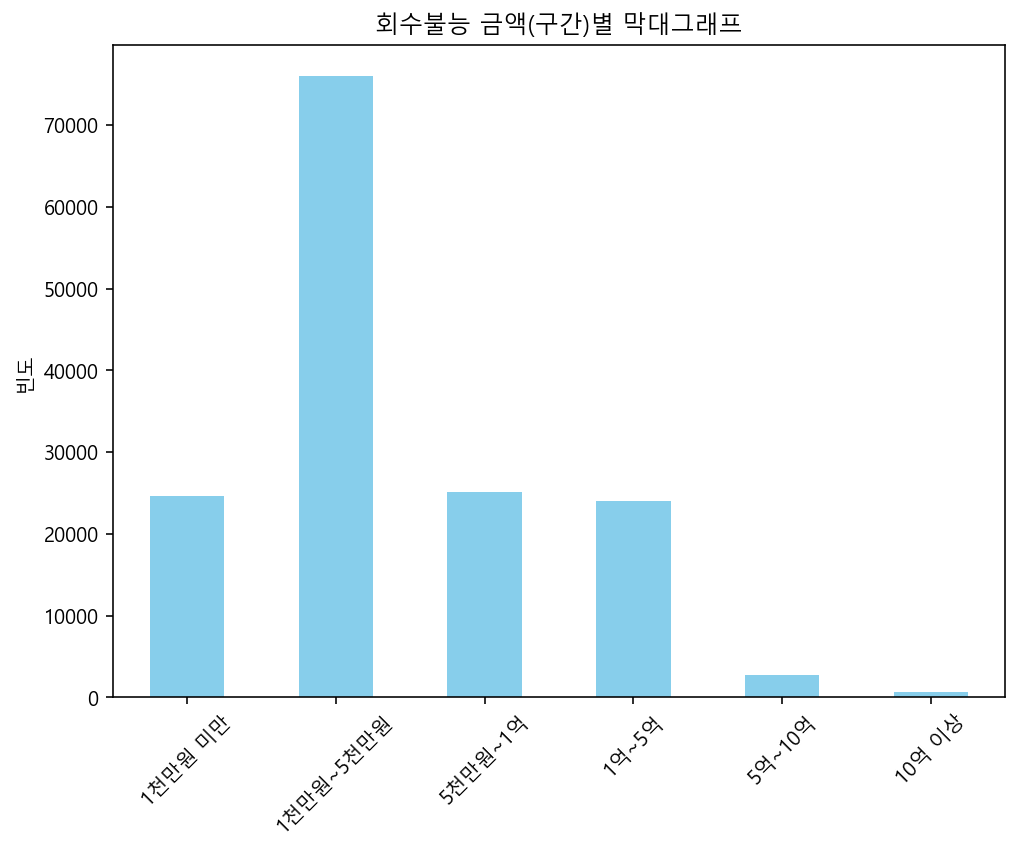

In [347]:
# chgoff_re 열의 값에 따라 막대그래프 생성
plt.figure(figsize=(8, 6))
default['chgoff_re'] = default['chgoff_re'].replace({0: '1천만원 미만', 1: '1천만원~5천만원', 2: '5천만원~1억', 3: '1억~5억',
                                                    4: '5억~10억', 5: '10억 이상'})
default['chgoff_re'].value_counts().loc[['1천만원 미만', '1천만원~5천만원', '5천만원~1억', '1억~5억','5억~10억','10억 이상']].plot(kind='bar', color='skyblue')

plt.title('회수불능 금액(구간)별 막대그래프')
plt.xlabel('')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.show()

=> 회수불능 금액의 구간이 1인 경우, 즉 1천만원 이상 5천만원 미만인 경우가 가장 많았다.

## (26) GrAppv : 은행 승인 대출금액

In [348]:
df10.GrAppv

0          60000
1          40000
2         287000
3          35000
4         229000
           ...  
880821     70000
880822     85000
880823    300000
880824     75000
880825     30000
Name: GrAppv, Length: 873547, dtype: int64

In [349]:
df10.GrAppv.value_counts()

50000      67740
100000     50045
25000      48691
10000      36539
150000     27022
           ...  
159584         1
202575         1
42809          1
1027800        1
34833          1
Name: GrAppv, Length: 21864, dtype: int64

### 분포 확인하기

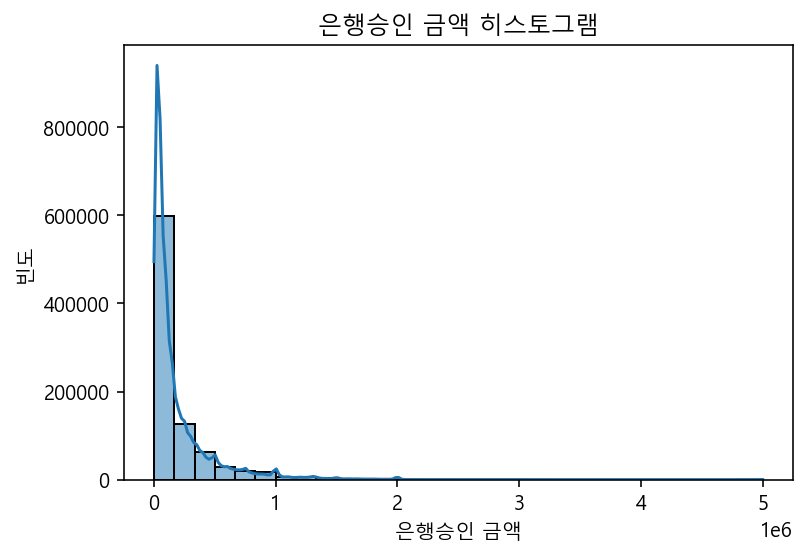

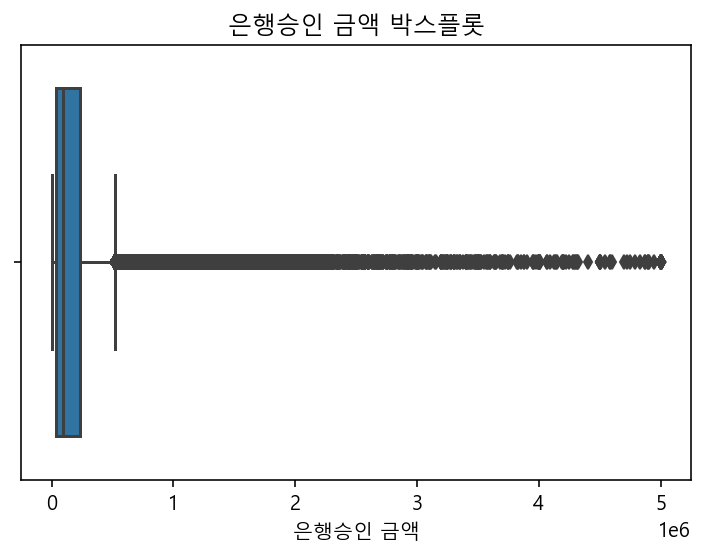

In [350]:
# 히스토그램
sns.histplot(df10['GrAppv'], bins=30, kde=True)
plt.title('은행승인 금액 히스토그램', fontsize=12)
plt.xlabel('은행승인 금액')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df10['GrAppv'])
plt.title('은행승인 금액 박스플롯')
plt.xlabel('은행승인 금액')
plt.show()

=> 이상치가 있는 것처럼 보임.

### 이상치 처리하기

In [351]:
print(df10.GrAppv.max())
print(df10.GrAppv.min())

5000000
1000


=> 은행 승인 금액의 최댓값은 50억, 최솟값은 100만원이다.

In [352]:
# 은행 승인 금액이 최댓값인 행만 추출
df10[df10['GrAppv'] == 5000000]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
433822,4314425000,Lewis Transportation Group LLC,SALT LAKE CITY,UT,84101,YELLOWSTONE BANK,MT,16,2010-10-15,2011,...,5000000,4500000,0,0,2014-10-11,0,0,0,2,5
436546,4338905007,FETTER PRINTING COMPANY & HABE,LOUISVILLE,KY,40217,STOCK YARDS BK & TR CO,KY,10,2010-10-28,2011,...,5000000,4500000,1,0,2020-11-09,1,0,0,2,5
438648,4358415010,"MISSISSIPPI DISTRIBUTORS, INC",BATESVILLE,MS,38606,GUARANTY BANK & TRUST CO.,MS,20,2010-11-09,2011,...,5000000,4500000,1,0,2035-09-23,2,0,0,0,5
438717,4358965000,Pasadena Travelodge,Pasadena,CA,91107,UNITED PACIFIC BANK,CA,1,2010-11-09,2011,...,5000000,4500000,1,0,2035-07-01,2,0,0,1,5
440289,4373345000,International Feed.com Corpora,LORETTO,MN,55357,BMO HARRIS BK NATL ASSOC,IL,20,2010-11-17,2011,...,5000000,4500000,0,0,2012-11-20,0,0,0,1,5
443395,4400535005,Ocean Plaza Beach Resort,TYBEE ISLAND,GA,31328,METRO CITY BANK,GA,1,2010-12-02,2011,...,5000000,4500000,1,0,2036-05-22,2,0,0,2,5
444179,4406975009,Chihade International Inc,ATLANTA,GA,30341,SUNTRUST BANK,GA,20,2010-12-06,2011,...,5000000,4500000,1,0,2011-12-27,0,0,0,1,5
444556,4410025009,"SEATTLE SAFETY, LLC",KENT,WA,98032,CATHAY BANK,WA,10,2010-12-07,2011,...,5000000,4500000,1,0,2013-09-15,0,0,1,2,5
445867,4420815003,Lily Group Inc.,SULLIVAN,IN,47882,FIRST FARMERS BANK AND TRUST,IN,12,2010-12-10,2011,...,5000000,4500000,1,0,2020-11-09,1,0,2,1,5
452798,4481495007,"Environmental Dynamics, Inc.",COLUMBIA,MO,65201,LANDMARK BANK NATL ASSOC,MO,10,2010-12-27,2011,...,5000000,4500000,1,0,2012-10-21,0,0,0,0,5


In [353]:
# 해당 기업에게 실제 대출해준 금액은?
df10[df10['GrAppv'] == 5000000]['DisbursementGross']

433822    5000000
436546    5000000
438648    5000000
438717    5000000
440289    5000000
443395    1500000
444179    5000000
444556    5000000
445867    5000000
452798    4444444
453039    5000000
456685    5000000
457671    5000000
464037    5000000
474079    2000000
482420    5000000
483317    5000000
486872    5000000
499863    5000000
499947    5000000
500040    5000000
518013    5000000
520209    5000000
522137    5000000
528793    5000000
529591    5000000
531554    5000000
539228    5000000
550912    5000000
553270    5000000
555281    5000000
580616    5000000
586597    5000000
Name: DisbursementGross, dtype: int64

=> 대부분 동일한 것으로 나타남!

### 은행 승인 금액 < 지급된 금액인 경우 추출

In [354]:
df10[df10['GrAppv'] < df10['DisbursementGross']]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
28,1000506000,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,6,2006-02-07,2006,...,100000,50000,0,0,2012-12-23,1,0,1,2,3
30,1000516003,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,5,2006-02-07,2006,...,35000,17500,1,0,2013-01-22,1,0,0,1,2
34,1000536009,HUTMACHER HOLDINGS INC,LEANDER,TX,78641,WELLS FARGO BANK NATL ASSOC,SD,14,2006-02-07,2006,...,25000,12500,0,0,2012-12-25,1,0,1,1,2
48,1000685001,ANYWHERE SPORTS PRODUCTIONS,Marina del Ray,CA,90292,WELLS FARGO BANK NATL ASSOC,SD,7,1997-03-25,1997,...,25000,12500,0,0,2004-09-24,1,0,0,0,1
65,1000756005,B&B DIPNETS,WASILLA,AK,99654,WELLS FARGO BANK NATL ASSOC,SD,10,2006-02-07,2006,...,30000,15000,0,0,2012-12-23,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880198,9982363001,PETER R. ACOCELLA P.C.,BABYLON,NY,11702,JPMORGAN CHASE BANK NATL ASSOC,IL,14,1997-02-24,1997,...,35000,17500,0,0,2000-08-15,0,0,0,0,1
880244,9983283003,"FALKENBERG, INC.",CLACKAMAS,OR,97015,JPMORGAN CHASE BANK NATL ASSOC,OR,7,1997-02-24,1997,...,200000,150000,1,0,1998-04-25,0,0,0,0,3
880288,9984153001,VICTORIAN MANOR RESTAURANT,GENESEO,IL,61254,WELLS FARGO BANK NATL ASSOC,SD,6,1997-02-24,1997,...,25000,12500,0,0,2002-07-05,0,0,0,0,1
880343,9985823003,"MINORITY TEMPORARY AGENCY, INC",NEW YORK,NY,10017,"C & A INVESTMENTS, INC",NY,10,1997-02-25,1997,...,100000,50000,1,0,1998-06-25,0,0,0,0,3


=> 전체 데이터의 약 17.4% 차지 대부분이 은행 승인 금액보다 적거나 같게 대출해준 것으로 보임.

## (27) SBA_Appv : SBA 승인 대출금액

In [355]:
df10['SBA_Appv']

0          48000
1          32000
2         215250
3          28000
4         229000
           ...  
880821     56000
880822     42500
880823    225000
880824     60000
880825     24000
Name: SBA_Appv, Length: 873547, dtype: int64

In [356]:
df10['SBA_Appv'].value_counts()

25000     48660
12500     38101
5000      29938
50000     24655
10000     16442
          ...  
892575        1
67340         1
124688        1
128786        1
45078         1
Name: SBA_Appv, Length: 37813, dtype: int64

### 분포 확인하기

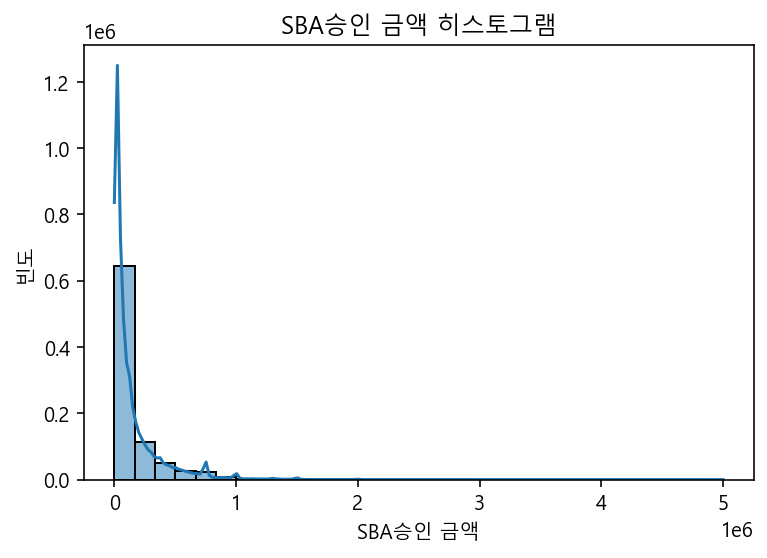

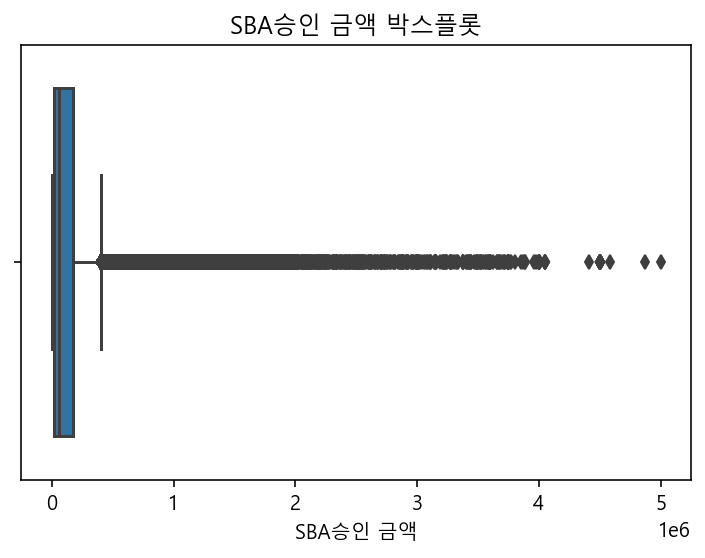

In [357]:
# 히스토그램
sns.histplot(df10['SBA_Appv'], bins=30, kde=True)
plt.title('SBA승인 금액 히스토그램', fontsize=12)
plt.xlabel('SBA승인 금액')
plt.ylabel('빈도')
plt.show()

# 박스플롯
sns.boxplot(df10['SBA_Appv'])
plt.title('SBA승인 금액 박스플롯')
plt.xlabel('SBA승인 금액')
plt.show()

=> 이상치가 있는 것으로 보임.

### 이상치 처리하기

In [358]:
print(df10['SBA_Appv'].max())
print(df10['SBA_Appv'].min())

5000000
500


=> SBA 승인 금액의 최댓값은 50억, 최솟값은 50만 원으로 은행과 최솟값 부분에서 차이를 보인다.

### 은행 승인 대출 금액 > SBA 승인 대출 금액인 경우 추출해보기

In [359]:
df10[df10['GrAppv'] > df10['SBA_Appv']]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,GrAppv,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,60000,48000,0,0,2006-01-22,1,0,0,0,2
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1,1997-02-28,1997,...,40000,32000,1,0,2002-05-05,0,0,0,0,1
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,8,1997-02-28,1997,...,287000,215250,1,0,2012-10-13,1,0,0,0,3
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1,1997-02-28,1997,...,35000,28000,1,0,2002-06-04,0,0,0,0,1
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,10,1997-02-28,1997,...,517000,387750,0,0,2007-05-09,1,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880821,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,70000,56000,0,0,2002-09-04,0,0,0,0,2
880822,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,85000,42500,0,0,2002-10-05,0,0,0,0,2
880823,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,300000,225000,1,0,2006-08-14,1,0,0,0,3
880824,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,1,1997-02-27,1997,...,75000,60000,1,0,2002-03-05,0,0,0,0,2


=> 전체 데이터의 약 92%을 차지한다. 따라서 은행이 SBA에 비해 대출 승인 금액 기준이 더 높다.

In [360]:
df10.shape

(873547, 33)

### <span style="color:Blue">파생변수 생성(appv_pct)</span>
- SBA_Appv / GrAppv

In [361]:
df10['appv_pct'] = df10['SBA_Appv'] / df10['GrAppv'] * 100

In [362]:
df10['appv_pct']

0          80.0
1          80.0
2          75.0
3          80.0
4         100.0
          ...  
880821     80.0
880822     50.0
880823     75.0
880824     80.0
880825     80.0
Name: appv_pct, Length: 873547, dtype: float64

In [363]:
# 은행 승인 대출 금액과 SBA 승인 대출 금액이 동일한 경우
df10[df10['appv_pct'] == 100]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re,appv_pct
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,17,1997-02-28,1997,...,229000,1,0,2017-01-29,2,0,1,1,3,100.0
14,1000214004,EBC INVESTMENTS LLC,WINSTON-SALEM,NC,27106,NORTHWEST PIEDMONT DEVEL CORPO,NC,8,1997-02-28,1997,...,225000,1,0,2017-09-03,2,0,2,0,3,100.0
29,1000514000,"SCROOGE'S SPIRIT, INC.",ANDERSON,SC,29621,CERTIFIED DEVEL CORP OF SO. CA,SC,17,1997-02-28,1997,...,291000,1,0,2017-10-01,2,0,1,0,3,100.0
68,1000774008,"ACADEMIE DE BALLET, INC.",CHESAPEAKE,VA,23220,TIDEWATER BUS. FINANCING CORP,VA,5,1997-02-28,1997,...,183000,1,0,2017-12-31,2,0,1,0,3,100.0
84,1000844005,"WOODLAND PUBLISHING, INC",PLEASANT GROVE,UT,84062,MOUNTAIN W. SMALL BUS. FINAN,UT,10,1997-02-28,1997,...,208000,1,0,2017-02-26,2,0,1,1,3,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880707,9993443007,"ZABUKOVIC MOTORS, INC.",PUEBLO WEST,CO,81007,SCEDD DEVELOPMENT COMPANY,CO,17,1997-02-27,1997,...,186000,1,0,2017-10-29,2,0,1,1,3,100.0
880709,9993483008,"DOLPHIN SHIRT CO., INC.",SAN LUIS OBISPO,CA,93401,COASTAL BUSINESS FINANCE,CA,17,1997-02-27,1997,...,233000,1,0,2017-04-02,2,0,1,2,3,100.0
880744,9994153005,"INNOVATIVE TOOL INTERNATIONAL,",CAMARILLO,CA,93010,CALIFORNIA STATEWIDE CERT. DEV,CA,5,1997-02-27,1997,...,265000,1,0,2017-01-29,2,0,1,1,3,100.0
880786,9994903005,ANCHOR POINT PRODUCTION,SALT LAKE CITY,UT,84102,MOUNTAIN W. SMALL BUS. FINAN,UT,16,1997-02-27,1997,...,349000,1,0,2018-04-29,2,0,1,1,3,100.0


=> 전체 데이터의 8% 차지

In [364]:
# SBA 승인 대출 금액 < 은행 승인 대출 금액
df10[df10['appv_pct'] < 100]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,SBA_Appv,SameState,Recession,ChgOffDate2,Term_re,smallmedium,createjob2,retainedjob2,dis_re,appv_pct
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,48000,0,0,2006-01-22,1,0,0,0,2,80.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1,1997-02-28,1997,...,32000,1,0,2002-05-05,0,0,0,0,1,80.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,8,1997-02-28,1997,...,215250,1,0,2012-10-13,1,0,0,0,3,75.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,1,1997-02-28,1997,...,28000,1,0,2002-06-04,0,0,0,0,1,80.0
5,1000084002,"B&T SCREW MACHINE COMPANY, INC",PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,10,1997-02-28,1997,...,387750,0,0,2007-05-09,1,0,0,0,4,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880821,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,56000,0,0,2002-09-04,0,0,0,0,2,80.0
880822,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,17,1997-02-27,1997,...,42500,0,0,2002-10-05,0,0,0,0,2,50.0
880823,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,10,1997-02-27,1997,...,225000,1,0,2006-08-14,1,0,0,0,3,75.0
880824,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,1,1997-02-27,1997,...,60000,1,0,2002-03-05,0,0,0,0,2,80.0


=> 전체 데이터의 92% 차지

## 미국 금리 데이터

In [365]:
df_interest = pd.read_csv('월별은행대출금리.csv')
df_interest

,DATE,DPRIME
0,1987-01-01,7.500
1,1987-02-01,7.500
2,1987-03-01,7.500
3,1987-04-01,7.750
4,1987-05-01,8.125
...,...,...
331,2014-08-01,3.250
332,2014-09-01,3.250
333,2014-10-01,3.250
334,2014-11-01,3.250


In [366]:
df_interest['DATE'] = pd.to_datetime(df_interest['DATE'], format='%Y-%m-%d')

In [367]:
df_interest['Year'] = df_interest['DATE'].dt.year
df_interest['Month'] = df_interest['DATE'].dt.month

df_interest[['DATE','Year', 'Month']]

,DATE,Year,Month
0,1987-01-01,1987,1
1,1987-02-01,1987,2
2,1987-03-01,1987,3
3,1987-04-01,1987,4
4,1987-05-01,1987,5
...,...,...,...
331,2014-08-01,2014,8
332,2014-09-01,2014,9
333,2014-10-01,2014,10
334,2014-11-01,2014,11


In [368]:
df10['DisbursementDate']

0         28-Feb-99
1         31-May-97
2         31-Dec-97
3         30-Jun-97
4         14-May-97
            ...    
880821    30-Sep-97
880822    31-Oct-97
880823    30-Sep-97
880824    31-Mar-97
880825    31-May-97
Name: DisbursementDate, Length: 873547, dtype: object

In [369]:
df10['DisbursementDate'] = pd.to_datetime(df10['DisbursementDate'], format='%d-%b-%y')

In [370]:
df10['Year'] = df10['DisbursementDate'].dt.year
df10['Month'] = df10['DisbursementDate'].dt.month

In [371]:
df10[['DisbursementDate','Year', 'Month']]

,DisbursementDate,Year,Month
0,1999-02-28,1999,2
1,1997-05-31,1997,5
2,1997-12-31,1997,12
3,1997-06-30,1997,6
4,1997-05-14,1997,5
...,...,...,...
880821,1997-09-30,1997,9
880822,1997-10-31,1997,10
880823,1997-09-30,1997,9
880824,1997-03-31,1997,3


In [372]:
merged_df = pd.merge(df10, df_interest, on=['Year', 'Month'], how='inner')
merged_df[['Year', 'Month', 'DPRIME']]

,Year,Month,DPRIME
0,1999,2,7.75
1,1999,2,7.75
2,1999,2,7.75
3,1999,2,7.75
4,1999,2,7.75
...,...,...,...
864742,1996,2,8.25
864743,1996,2,8.25
864744,1996,2,8.25
864745,1996,2,8.25


In [373]:
merged_df.shape

(864747, 38)

In [374]:
df10.shape

(873547, 36)

In [375]:
df_interest['DATE'].value_counts()

1989-11-01    1
2001-11-01    1
1995-03-01    1
2007-10-01    1
1989-06-01    1
             ..
2012-05-01    1
1992-07-01    1
2004-02-01    1
2004-01-01    1
2007-05-01    1
Name: DATE, Length: 336, dtype: int64

=> 1987~2014까지는 총 28개. 28*12=336이므로 정상

In [376]:
merged_df

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,Term_re,smallmedium,createjob2,retainedjob2,dis_re,appv_pct,Year,Month,DATE,DPRIME
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,17,1997-02-28,1997,...,1,0,0,0,2,80.0,1999,2,1999-02-01,7.75
1,1000935004,Hairline Inc.,Vancouver,WA,98663,WELLS FARGO BANK NATL ASSOC,SD,8,1997-04-08,1997,...,1,0,0,0,1,50.0,1999,2,1999-02-01,7.75
2,1003535008,Jason A. Philbrook,Rockland,ME,4841,KEYBANK NATIONAL ASSOCIATION,OH,2,1999-01-11,1999,...,1,0,0,0,3,50.0,1999,2,1999-02-01,7.75
3,1009994000,"ARROW ENTERPRISE, INC.",BILLINGS,MT,59101,WESTERN SECURITY BANK,MT,5,1997-03-04,1997,...,0,0,0,0,3,75.0,1999,2,1999-02-01,7.75
4,1011904005,"ROBIN E. JONES, D.D.S.",TACOMA,WA,98404,KEYBANK NATIONAL ASSOCIATION,OR,8,1997-03-05,1997,...,0,0,0,0,1,50.0,1999,2,1999-02-01,7.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864742,9022713002,"BJORK, LAURA BEAUTY CONSULTANT",DALE CITY,VA,22193,MANUFACTURERS & TRADERS TR CO,MD,2,1996-02-21,1996,...,0,0,0,0,0,80.0,1996,2,1996-02-01,8.25
864743,9035193000,"PROFESSIONALS FOR NONPROFITS,I",NEW YORK,NY,10022,BANCO POPULAR NORTH AMERICA,NY,5,1996-02-26,1996,...,1,0,0,0,2,80.0,1996,2,1996-02-01,8.25
864744,9256453010,NORTHAIRE MARKET INC,SHAKOPEE,MN,55379,FIDELITY BANK,MN,17,1996-05-07,1996,...,0,0,0,0,1,80.0,1996,2,1996-02-01,8.25
864745,9459933001,COMPUTER RENAISSANCE,CARY,NC,27511,FIRST-CITIZENS BK & TR CO,NC,17,1996-08-15,1996,...,1,0,0,0,3,80.0,1996,2,1996-02-01,8.25


In [377]:
merged_df['DPRIME'].value_counts()

8.250000     128229
8.500000      84935
4.000000      59272
3.250000      53232
4.750000      43108
              ...  
8.833333        134
10.894737       128
9.026316        107
10.075000        99
9.826087         97
Name: DPRIME, Length: 93, dtype: int64

In [378]:
# 소수점 2자리로 표기
merged_df['DPRIME'] = merged_df['DPRIME'].round(2)

In [379]:
merged_df['DPRIME'].value_counts()

8.25     128229
8.50      84935
4.00      59272
3.25      53232
4.75      43108
          ...  
8.83        134
10.89       128
9.03        107
10.07        99
9.83         97
Name: DPRIME, Length: 91, dtype: int64

### 은행 대출 금리에 따른 MIS_Status 비율 확인

### 파생변수 생성하기

In [380]:
merged_df['DPRIME'].min()

3.25

In [381]:
merged_df['DPRIME'].max()

11.5

In [382]:
merged_df['dprime2'] = np.where((merged_df['DPRIME'] >= 3.25) & (merged_df['DPRIME'] <= 10.00), 0, 1)

In [383]:
merged_df['dprime2']

0         0
1         0
2         0
3         0
4         0
         ..
864742    0
864743    0
864744    0
864745    0
864746    0
Name: dprime2, Length: 864747, dtype: int32

In [384]:
merged_df['dprime2'] = merged_df['dprime2'].replace({0: '저금리', 1: '고금리'})

In [385]:
# dprime2 변수에 따른 MIS_Status 비율 계산
dprime2_ratio = merged_df.groupby('dprime2')['MIS_Status'].value_counts(normalize=True).unstack()
dprime2_ratio

MIS_Status,0,1
dprime2,,
고금리,0.931829,0.068171
저금리,0.826244,0.173756


In [386]:
tmp2=pd.DataFrame(dprime2_ratio)
tmp2

MIS_Status,0,1
dprime2,,
고금리,0.931829,0.068171
저금리,0.826244,0.173756


In [387]:
# 새로운 행 순서를 정의합니다. 예를 들어, [2, 0, 1]로 순서를 변경합니다.
new_order = ['저금리','고금리']

# reindex를 사용하여 행 순서를 변경합니다.
tmp2 = tmp2.reindex(new_order)
tmp2

MIS_Status,0,1
dprime2,,
저금리,0.826244,0.173756
고금리,0.931829,0.068171


<Figure size 1080x576 with 0 Axes>

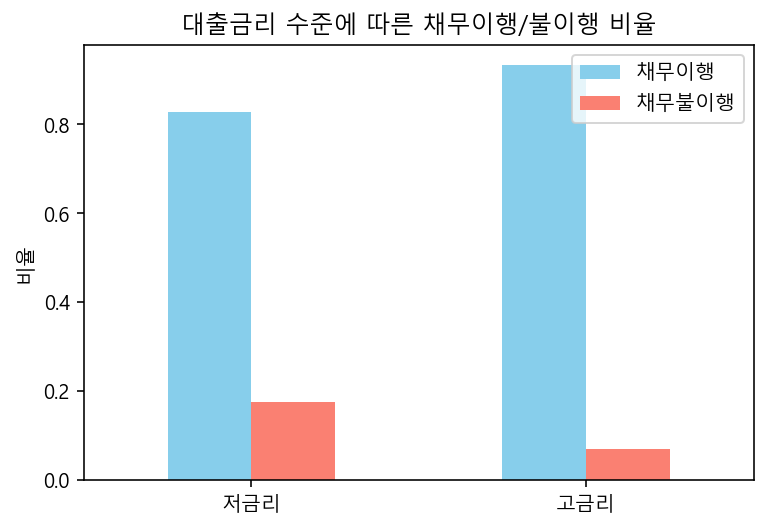

In [388]:
# 막대그래프로 시각화
plt.figure(figsize=(15, 8))
tmp2.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])
plt.xlabel('')
plt.ylabel('비율')
plt.title('대출금리 수준에 따른 채무이행/불이행 비율')
plt.legend(['채무이행', '채무불이행'], title='')
plt.xticks(rotation=0)
plt.show()

=> 고금리일 때 오히려 채무이행 비율이 높게 나왔다!

In [389]:
merged_df['dprime2'] = merged_df['dprime2'].replace({'저금리': 0, '고금리': 1})

In [390]:
df10 = merged_df

In [391]:
df10.shape

(864747, 39)

In [392]:
# 최종 데이터 저장
df10.to_csv('df_final2.csv', index=False)

In [393]:
df_confirm2 = pd.read_csv('df_final2.csv', low_memory=False)
df_final2 = df_confirm2.copy() #원본 데이터

In [394]:
df_final2.shape

(864747, 39)

## 성장 가능성 변수 만들기 전 최종 데이터 불러오기

In [395]:
df11=pd.read_csv('df_final2.csv')
df11.shape

(864747, 39)

### <span style="color:Blue">파생변수 생성(growth_potential)</span>
- 1) 산업 분류 코드를 기준으로 산업 분석(gp_1): NAICS 코드를 사용하여 특정 산업 분야의 기업을 찾고, 해당 주 내에 해당 산업 분야의 기업이 얼마나 많이 있는지를 분석. 이를 통해 해당 주의 특정 산업 분야의 밀집도를 확인 가능.( 20:60:20의 비율로 1,2,3)

- 2) 직원 수를 활용한 분석(gp_2): 주별로 직원 수를 기준으로 한 산업의 규모를 파악하여, 특정 산업이 해당 주에서 얼마나 큰 영향력을 가지는지를 확인. 직원 수가 많은 산업은 해당 주의 경제에 큰 영향을 미칠 가능성이 높음.

- 3) 창출된 직원 수 및 유지 직원 수를 고려한 분석(gp_3): 창출된 직원 수와 유지 직원 수를 종합적으로 고려하여 특정 산업의 성장과 안정성을 평가 가능. 산업이 적극적으로 새로운 일자리를 창출하고, 동시에 기존 일자리를 유지하는 경우 해당 주의 산업 밀집도를 높일 수 있음.

- -> 이러한 방법들을 종합적으로 활용하여 해당 산업의 경제적 영향력과 성장 가능성을 평가.
- -> 1대1대1의 비율로 합산하여 상위 20%, 60%, 20%의 순으로 1, 2, 3으로 라벨링
- 기업가치 상정 -> 안정성 & 성장성으로 파악
- 안정성과 성장성을 매출액 기준. But, 자산과 관련된 데이터 x.
- 매출액과 직원수는 양의 상관관계
- 미국의 경우 산업 밀집도가 높을수록 협력, 혜택 있음.( 주별 신용등급 다름)
- 따라서 이를 이용해 기업의 성장가능성을 파악 할 수 있는 파생변수 생성

In [97]:
# 각 산업별 기업 수를 해당 주 전체 기업 수로 나누어 밀집도 계산
df11['Density'] = df11.groupby(['State', 'NAICS'])['LoanNr_ChkDgt'].transform('count') / df11.groupby('State')['LoanNr_ChkDgt'].transform('count')

# 각 주별로 산업별 밀집도를 기준으로 상위 20%, 하위 20% 경계값 계산
df11['Upper_Threshold'] = df11.groupby('State')['Density'].transform(lambda x: x.quantile(0.8))
df11['Lower_Threshold'] = df11.groupby('State')['Density'].transform(lambda x: x.quantile(0.2))

# 각 주별로 산업별 밀집도를 기준으로 상위 20%, 하위 20%, 나머지를 구분하여 라벨 부여
df11['Label'] = 3  # 기본값은 3으로 설정
df11.loc[df11['Density'] > df11['Upper_Threshold'], 'Label'] = 1
df11.loc[df11['Density'] < df11['Lower_Threshold'], 'Label'] = 5

# gp_1 지표에 라벨 저장
gp_1 = df11.pivot_table(index='State', columns='NAICS', values='Label', fill_value=2)

# 피벗팅된 데이터프레임을 다시 플랫 데이터프레임으로 변환
flat_gp_1 = gp_1.stack().reset_index(name='value')
flat_gp_1.rename(columns={'NAICS': 'NAICS', 'Label': 'value'}, inplace=True)
gp_1 = flat_gp_1

# 결과 출력
print(gp_1)

     State  NAICS  value
0       AK      1      3
1       AK      2      5
2       AK      3      3
3       AK      4      5
4       AK      5      3
...    ...    ...    ...
1015    WY     16      5
1016    WY     17      1
1017    WY     18      5
1018    WY     19      5
1019    WY     20      5

[1020 rows x 3 columns]


In [98]:
df11['Label']

0         1
1         3
2         5
3         3
4         3
         ..
864742    3
864743    3
864744    3
864745    1
864746    3
Name: Label, Length: 864747, dtype: int64

In [99]:
# 각 주별 전체 직원 수 계산
total_employees_by_state = df11.groupby('State')['NoEmp'].sum()

# 각 산업별 주별 직원 수 계산
industry_employees_by_state = df11.groupby(['State', 'NAICS'])['NoEmp'].sum()

# 각 산업별 주별 직원 수를 해당 주의 전체 직원 수로 나누어 규모 계산
industry_size_by_state = industry_employees_by_state / total_employees_by_state

# 각 주별로 산업별 규모를 기준으로 상위 20%, 하위 20% 경계값 계산
upper_threshold_by_state = industry_size_by_state.groupby('State').quantile(0.8)
lower_threshold_by_state = industry_size_by_state.groupby('State').quantile(0.2)

# 각 주별로 산업별 규모를 기준으로 상위 20%, 하위 20%, 나머지를 구분하여 라벨 부여
industry_labels = pd.Series(3, index=industry_size_by_state.index)  # 기본값은 2로 설정

# lower_threshold_by_state의 인덱스를 industry_size_by_state의 인덱스와 맞춤
lower_threshold_by_state_aligned = lower_threshold_by_state.reindex(industry_size_by_state.index, level=0)

# 하위 30% 이하인 경우 라벨을 3으로 설정
industry_labels[industry_size_by_state < lower_threshold_by_state_aligned] = 5

# upper_threshold_by_state의 인덱스를 industry_size_by_state의 인덱스와 맞춤
upper_threshold_by_state_aligned = upper_threshold_by_state.reindex(industry_size_by_state.index, level=0)

# 상위 30% 이상인 경우 라벨을 1로 설정
industry_labels[industry_size_by_state > upper_threshold_by_state_aligned] = 1

# gp_2 지표 출력
gp_2 = industry_labels.reset_index(name='value')
print(gp_2)

    State  NAICS  value
0      AK      1      1
1      AK      2      3
2      AK      3      3
3      AK      4      3
4      AK      5      1
..    ...    ...    ...
987    WY     16      3
988    WY     17      1
989    WY     18      3
990    WY     19      5
991    WY     20      3

[992 rows x 3 columns]


In [100]:
# 각 주의 산업별로 CreateJob 및 RetainedJob을 합산
industry_jobs_by_state = df11.groupby(['State', 'NAICS'])[['CreateJob', 'RetainedJob']].sum()

# 각 주의 산업별로 CreateJob과 RetainedJob을 합친 후, 각 주에서의 상위 30%, 하위 30% 경계값 계산
upper_threshold_by_state = industry_jobs_by_state.groupby('State').quantile(0.8)
lower_threshold_by_state = industry_jobs_by_state.groupby('State').quantile(0.2)

# 각 주별로 산업별 규모를 기준으로 상위 20%, 하위 20%, 나머지를 구분하여 라벨 부여
labels = pd.Series(3, index=industry_jobs_by_state.index)  # 기본값은 2로 설정

# lower_threshold_by_state의 인덱스를 industry_jobs_by_state의 인덱스와 맞춤
lower_threshold_by_state_aligned = lower_threshold_by_state.reindex(industry_jobs_by_state.index, level=0)

# 하위 20% 이하인 경우 라벨을 3으로 설정
labels[(industry_jobs_by_state[['CreateJob', 'RetainedJob']] < lower_threshold_by_state_aligned).any(axis=1)] = 5

# upper_threshold_by_state의 인덱스를 industry_jobs_by_state의 인덱스와 맞춤
upper_threshold_by_state_aligned = upper_threshold_by_state.reindex(industry_jobs_by_state.index, level=0)

# 상위 20% 이상인 경우 라벨을 1로 설정
labels[(industry_jobs_by_state[['CreateJob', 'RetainedJob']] > upper_threshold_by_state_aligned).any(axis=1)] = 1

# 라벨링된 데이터프레임 생성
labeled_data = labels.reset_index(name='value')

# 결과 확인
print(labeled_data)

# gp_3에 할당
gp_3 = labeled_data

    State  NAICS  value
0      AK      1      1
1      AK      2      3
2      AK      3      3
3      AK      4      3
4      AK      5      3
..    ...    ...    ...
987    WY     16      3
988    WY     17      1
989    WY     18      3
990    WY     19      5
991    WY     20      3

[992 rows x 3 columns]


In [101]:
# gp_2의 변수명 확인
gp_2_columns = gp_2.columns
print(gp_2_columns)

Index(['State', 'NAICS', 'value'], dtype='object')


In [102]:
# gp_1 데이터프레임에 대해 NAICS를 기준으로 value 값을 합산
gp_1_sum = gp_1.groupby('NAICS')['value'].sum()

# gp_2 데이터프레임에 대해 NAICS를 기준으로 value 값을 합산
gp_2_sum = gp_2.groupby('NAICS')['value'].sum()

# gp_3 데이터프레임에 대해 NAICS를 기준으로 value 값을 합산
gp_3_sum = gp_3.groupby('NAICS')['value'].sum()

# 결과 확인
print(gp_1_sum)
print(gp_2_sum)
print(gp_3_sum)

NAICS
1     153
2     227
3     243
4     255
5     153
6     255
7     255
8     153
9     253
10    155
11    210
12    250
13    153
14    155
15    222
16    255
17     87
18    255
19    252
20    187
Name: value, dtype: int64
NAICS
1      57
2     151
3     175
4     153
5      77
6     185
7     173
8     143
9     159
10     63
11    178
12    226
13    139
14    141
15    200
16    157
17     51
18    153
19    246
20    149
Name: value, dtype: int64
NAICS
1      53
2     145
3     193
4     155
5      79
6     179
7     177
8     121
9     157
10     61
11    178
12    234
13    119
14    121
15    200
16    163
17     51
18    151
19    244
20    145
Name: value, dtype: int64


In [103]:
# gp_1_sum, gp_2_sum, gp_3_sum을 'NAICS'를 인덱스로 가지는 데이터프레임으로 변환
gp_1_sum_df = gp_1_sum.reset_index()
gp_2_sum_df = gp_2_sum.reset_index()
gp_3_sum_df = gp_3_sum.reset_index()

# gp_1_sum_df, gp_2_sum_df, gp_3_sum_df를 NAICS를 기준으로 병합
merged_df = gp_1_sum_df.merge(gp_2_sum_df, on='NAICS', suffixes=('_gp1', '_gp2'))
merged_df = merged_df.merge(gp_3_sum_df, on='NAICS', suffixes=('_gp1', '_gp3'))

# 결과 확인
print(merged_df)

    NAICS  value_gp1  value_gp2  value
0       1        153         57     53
1       2        227        151    145
2       3        243        175    193
3       4        255        153    155
4       5        153         77     79
5       6        255        185    179
6       7        255        173    177
7       8        153        143    121
8       9        253        159    157
9      10        155         63     61
10     11        210        178    178
11     12        250        226    234
12     13        153        139    119
13     14        155        141    121
14     15        222        200    200
15     16        255        157    163
16     17         87         51     51
17     18        255        153    151
18     19        252        246    244
19     20        187        149    145


In [104]:
# value_gp1, value_gp2, value를 더한 값을 가지는 열 추가
merged_df['value_fin'] = merged_df['value_gp1'] + merged_df['value_gp2'] + merged_df['value']

# 결과 확인
print(merged_df)

    NAICS  value_gp1  value_gp2  value  value_fin
0       1        153         57     53        263
1       2        227        151    145        523
2       3        243        175    193        611
3       4        255        153    155        563
4       5        153         77     79        309
5       6        255        185    179        619
6       7        255        173    177        605
7       8        153        143    121        417
8       9        253        159    157        569
9      10        155         63     61        279
10     11        210        178    178        566
11     12        250        226    234        710
12     13        153        139    119        411
13     14        155        141    121        417
14     15        222        200    200        622
15     16        255        157    163        575
16     17         87         51     51        189
17     18        255        153    151        559
18     19        252        246    244        742


In [105]:
# 'NAICS'와 'value_fin' 열만 선택
gp = merged_df[['NAICS', 'value_fin']]

# value_fin을 기준으로 라벨링하여 'growth_potential' 열 추가
gp['gp_fin'] = pd.qcut(gp['value_fin'], q=[0, 0.2, 0.8, 1], labels=[1, 2, 3])

# 결과 확인
print(gp)

    NAICS  value_fin gp_fin
0       1        263      1
1       2        523      2
2       3        611      2
3       4        563      2
4       5        309      1
5       6        619      3
6       7        605      2
7       8        417      2
8       9        569      2
9      10        279      1
10     11        566      2
11     12        710      3
12     13        411      2
13     14        417      2
14     15        622      3
15     16        575      2
16     17        189      1
17     18        559      2
18     19        742      3
19     20        481      2


In [106]:
# 'NAICS'와 'value_fin' 열만 선택
gp = merged_df[['NAICS', 'value_fin']]

# value_fin을 기준으로 라벨링하여 'gp_fin' 열 추가
gp['gp_fin'] = pd.qcut(gp['value_fin'], q=[0, 0.2, 0.8, 1], labels=[1, 2, 3])

# 'value_fin' 열 삭제
gp = gp.drop(columns=['value_fin'])

# 결과 확인
print(gp)

    NAICS gp_fin
0       1      1
1       2      2
2       3      2
3       4      2
4       5      1
5       6      3
6       7      2
7       8      2
8       9      2
9      10      1
10     11      2
11     12      3
12     13      2
13     14      2
14     15      3
15     16      2
16     17      1
17     18      2
18     19      3
19     20      2


In [107]:
# gp 데이터프레임을 딕셔너리로 변환
gp_dict = dict(zip(gp['NAICS'], gp['gp_fin']))

# df5의 각 행에 대해 반복하여 NAICS에 해당하는 gp_fin 값을 찾아서 할당
df11['growth_potential'] = df11['NAICS'].map(gp_dict)

In [108]:
df11_subset = df11[['NAICS', 'growth_potential']]
print(df11_subset)

        NAICS  growth_potential
0          17                 1
1          14                 2
2          18                 2
3           5                 1
4           8                 2
...       ...               ...
864742      1                 1
864743     10                 1
864744     20                 2
864745     17                 1
864746     20                 2

[864747 rows x 2 columns]


In [109]:
# 결측값 여부 확인
missing_values = df11['growth_potential'].isna().sum()

# 결과 출력
print("결측값 수:", missing_values)

결측값 수: 0


In [110]:
# growth_potential의 값에 따른 비율 계산
growth_potential_ratio = df11['growth_potential'].value_counts(normalize=True)

# 결과 출력
print(growth_potential_ratio)

2    0.513023
1    0.473845
3    0.013132
Name: growth_potential, dtype: float64


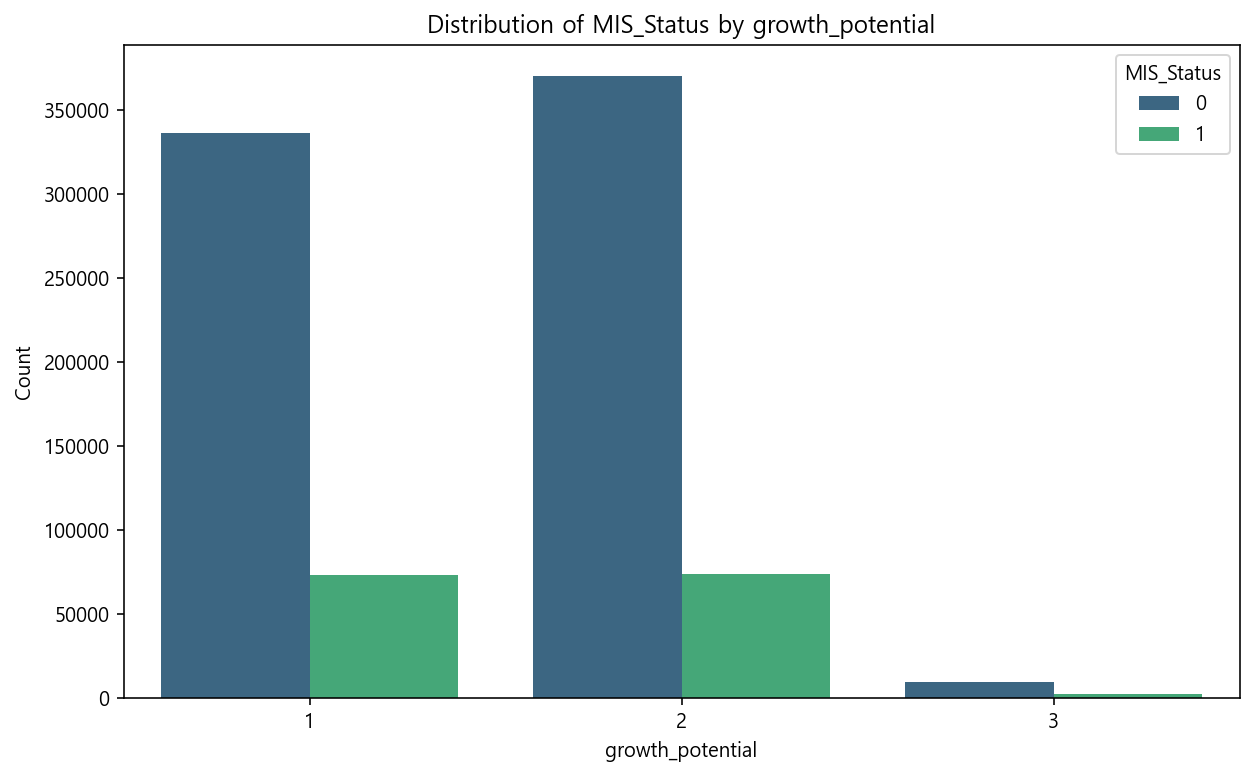

In [111]:
# 시각화 : 빈도
plt.figure(figsize=(10, 6))
sns.countplot(data=df11, x='growth_potential', hue='MIS_Status', palette='viridis')
plt.title('Distribution of MIS_Status by growth_potential')
plt.xlabel('growth_potential')
plt.ylabel('Count')
plt.show()

In [113]:
df11['growth_potential'] = df11['growth_potential'].replace({1: '높음', 2: '보통', 3:'낮음'})

In [114]:
# 각 growth_potential 값에 대한 MIS_Status의 분포를 수치로 확인
mis_status_distribution = df11.groupby('growth_potential')['MIS_Status'].value_counts(normalize=True).unstack()
mis_status_distribution

MIS_Status,0,1
growth_potential,,
낮음,0.830310,0.169690
높음,0.821206,0.178794
보통,0.834253,0.165747


In [115]:
tmp3=pd.DataFrame(mis_status_distribution)
tmp3

MIS_Status,0,1
growth_potential,,
낮음,0.830310,0.169690
높음,0.821206,0.178794
보통,0.834253,0.165747


In [116]:
# 새로운 행 순서를 정의합니다. 예를 들어, [2, 0, 1]로 순서를 변경합니다.
new_order = ['높음','보통','낮음']

# reindex를 사용하여 행 순서를 변경합니다.
tmp3 = tmp3.reindex(new_order)
tmp3

MIS_Status,0,1
growth_potential,,
높음,0.821206,0.178794
보통,0.834253,0.165747
낮음,0.830310,0.169690


<Figure size 1080x576 with 0 Axes>

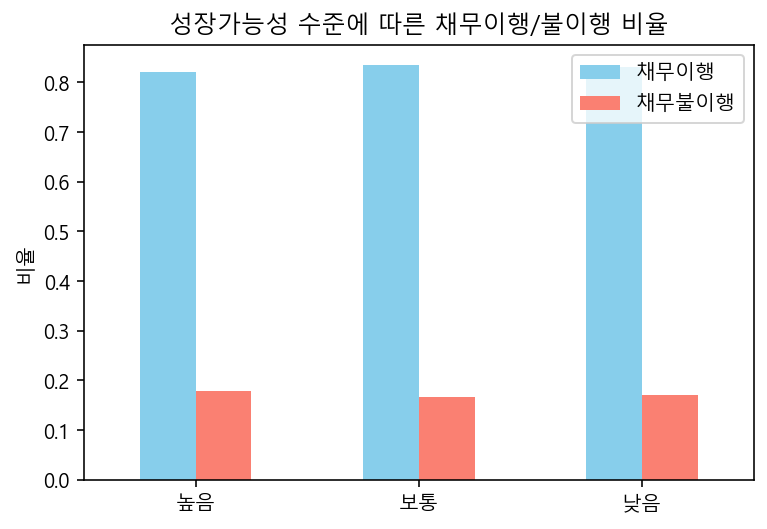

In [117]:
# 막대그래프로 시각화
plt.figure(figsize=(15, 8))
tmp3.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])
plt.xlabel('')
plt.ylabel('비율')
plt.title('성장가능성 수준에 따른 채무이행/불이행 비율')
plt.legend(['채무이행', '채무불이행'], title='')
plt.xticks(rotation=0)
plt.show()

MIS_Status distribution by growth_potential:
MIS_Status               0         1
growth_potential                    
1                 0.821206  0.178794
2                 0.834253  0.165747
3                 0.830310  0.169690


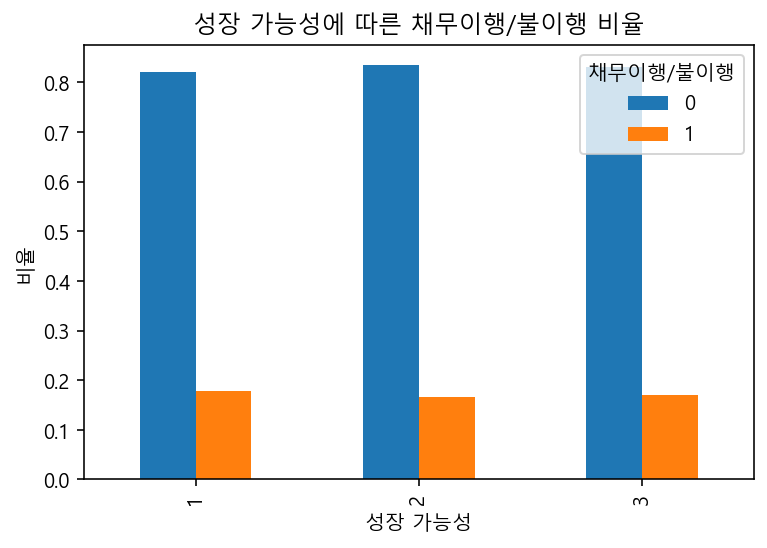

In [112]:
# 결과 출력
print("MIS_Status distribution by growth_potential:")
print(mis_status_distribution)

# 시각화
mis_status_distribution.plot(kind='bar', stacked=False)
plt.xlabel('성장 가능성')
plt.ylabel('비율')
plt.title('성장 가능성에 따른 채무이행/불이행 비율')
plt.legend(title='채무이행/불이행')
plt.show()

=> 비슷하게 나타남.

In [100]:
df11.shape

(864747, 44)

In [101]:
df11.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'LowDoc',
       'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'MIS_Status',
       'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'SameState', 'Recession',
       'ChgOffDate2', 'Term_re', 'smallmedium', 'createjob2', 'retainedjob2',
       'dis_re', 'appv_pct', 'Year', 'Month', 'DATE', 'DPRIME', 'dprime2',
       'Density', 'Upper_Threshold', 'Lower_Threshold', 'Label',
       'growth_potential'],
      dtype='object')

## 최종 데이터셋 저장

In [102]:
df11.to_csv('df_final3.csv', index=False)

In [103]:
# 확인
df_confirm3 = pd.read_csv('df_final3.csv', low_memory=False)
df_final3 = df_confirm3.copy() #원본 데이터
df_final3.shape

(864747, 44)

=> 이상 없음!